In [ ]:
!pip uninstall -y detectron2
!pip install torch torchvision torchaudio
!pip install cython pyyaml scipy termcolor tabulate black
!pip install 'git+https://github.com/facebookresearch/fvcore'
!pip install 'git+https://github.com/facebookresearch/iopath'
!pip install opencv-python-headless
!pip install git+https://github.com/facebookresearch/detectron2.git
import detectron2
print("Detectron2 installed successfully!")


In [2]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install pycocotools


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-x1lp6vo7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-x1lp6vo7
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.3 MB/s eta 0:00:0000:01
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6355140 sha256=c859fd9ea1ac322bf10f044fb8eb882b09232409e7fc745c14a76cbf0cdda683
  Stored in directory: /tmp/pip-ephem-wheel-cache-gogx_jp3/wheels/47/e5/15/94c80df2ba85

In [ ]:
import json

TRAIN_JSON = "/kaggle/input/jsons11/newjsons"

with open(TRAIN_JSON, "r") as f:
    data = json.load(f)

print(json.dumps(data["categories"], indent=4))  # Check class IDs and names
print(f"Total images: {len(data['images'])}")
print(f"Total annotations: {len(data['annotations'])}")


In [ ]:
import json

Valid_JSON = "/kaggle/working/validjsons"

with open(TRAIN_JSON, "r") as f:
    data = json.load(f)

print(json.dumps(data["categories"], indent=4))  # Check class IDs and names
print(f"Total images: {len(data['images'])}")
print(f"Total annotations: {len(data['annotations'])}")


In [ ]:
valid_annotations = [ann for ann in data["annotations"] if ann["bbox"][2] > 0 and ann["bbox"][3] > 0]
print(f"Valid annotations count: {len(valid_annotations)}")


In [ ]:
import torch
print(torch.__version__)  # Check PyTorch version
print(torch.cuda.is_available())  # Ensure CUDA is available
print(torch.cuda.get_device_name(0))  # Check GPU details


In [ ]:
import json

# Load one of your annotation files to check categories
with open(TRAIN_JSON, 'r') as f:
    data = json.load(f)

categories = data['categories']
print(categories)


In [ ]:
import json

def clean_annotations(input_json_path, output_json_path):
    # Load the annotations JSON file
    with open(input_json_path, 'r') as f:
        data = json.load(f)
    
    # Clean the categories: Remove categories with invalid names or duplicates
    valid_categories = []
    category_map = {}  # A mapping from category name to new id
    
    for category in data['categories']:
        if category['name'] != '-':  # Skip invalid categories
            if category['name'] not in category_map:  # Ensure no duplicates
                category_map[category['name']] = len(valid_categories)
                valid_categories.append(category)
    
    # Update the categories in the dataset
    data['categories'] = valid_categories
    
    # Clean up the annotations: Adjust category_ids to match the new mapping
    for annotation in data['annotations']:
        category_name = next((cat['name'] for cat in data['categories'] if cat['id'] == annotation['category_id']), None)
        if category_name:
            annotation['category_id'] = category_map[category_name]
    
    # Save the cleaned annotations to a new file
    with open(output_json_path, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Cleaned annotations saved to {output_json_path}")

# Example usage
input_json = f"{DATASET_PATH}/valid/_annotations.coco.json"  # Update with the actual path
output_json = '/kaggle/working/validjsons'  # Update with desired output path

clean_annotations(input_json, output_json)


In [ ]:
torch.cuda.empty_cache()


In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import torch
import os

# ✅ Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ✅ Correct dataset paths
DATASET_PATH = "/kaggle/input/blood-ds"
TRAIN_JSON = "/kaggle/input/jsons11/fixed_annotations.json"
TRAIN_IMAGES = f"{DATASET_PATH}/train"  # ✅ No separate "images" folder
VALID_JSON = "/kaggle/input/jsons11/fixedvalid_annotations.json"
VALID_IMAGES = f"{DATASET_PATH}/valid"  # ✅ No separate "images" folder

# ✅ Ensure dataset paths exist
assert os.path.exists(TRAIN_JSON), f"Missing: {TRAIN_JSON}"
assert os.path.exists(TRAIN_IMAGES), f"Missing: {TRAIN_IMAGES}"
assert os.path.exists(VALID_JSON), f"Missing: {VALID_JSON}"
assert os.path.exists(VALID_IMAGES), f"Missing: {VALID_IMAGES}"

# ✅ Register datasets correctly
register_coco_instances("blood_train", {}, TRAIN_JSON, TRAIN_IMAGES)
register_coco_instances("blood_valid", {}, VALID_JSON, VALID_IMAGES)

Using device: cuda


In [4]:


# ✅ Load configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("blood_train",)
cfg.DATASETS.TEST = ("blood_valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  
cfg.SOLVER.STEPS = []  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Adjust if you have more classes

# ✅ Ensure output directory exists
cfg.OUTPUT_DIR = "/kaggle/working/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# ✅ Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


model_final_f10217.pkl: 178MB [00:00, 230MB/s]                             
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
import json

def fix_category_ids(input_json_path, output_json_path):
    # Load the annotations JSON file
    with open(input_json_path, 'r') as f:
        data = json.load(f)
    
    # Build a mapping of category_ids to category names
    category_map = {category['id']: category['name'] for category in data['categories']}
    
    # Check and fix annotations
    invalid_category_count = 0
    for annotation in data['annotations']:
        category_id = annotation['category_id']
        if category_id not in category_map:
            print(f"Invalid category_id {category_id} found in annotations.")
            # Increment invalid category count
            invalid_category_count += 1
            # You can either skip these annotations or set them to a default valid category ID
            annotation['category_id'] = 0  # Set to a valid category_id (or the default one)
    
    if invalid_category_count > 0:
        print(f"Total invalid category_id entries found and fixed: {invalid_category_count}")
    
    # Save the fixed annotations to a new file
    with open(output_json_path, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Fixed annotations saved to {output_json_path}")

# Example usage
input_json = '/kaggle/input/jsons11/validjsons'  # Replace with actual path to your annotations JSON
output_json = '/kaggle/working/fixedvalid_annotations.json'  # Replace with the desired output path

fix_category_ids(input_json, output_json)


In [5]:
import shutil

shutil.copy("/kaggle/working/output/model_final.pth", "/kaggle/working/mask_rcnn_blood.pth")
print("Model saved as mask_rcnn_blood.pth")

Model saved as mask_rcnn_blood.pth


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

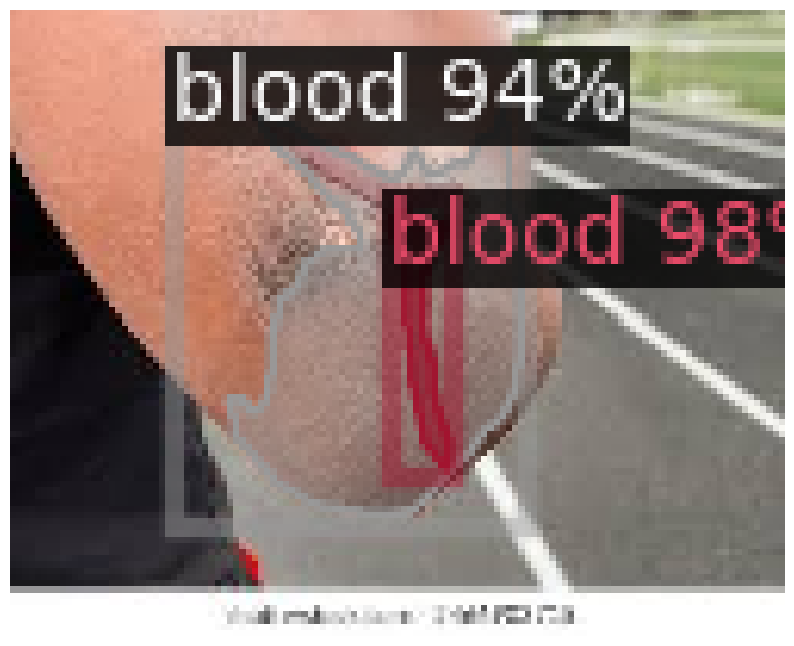

In [31]:
import cv2
import random
import os
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo

# Load configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "/kaggle/working/output/model_final.pth"  # Path to your trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # Set threshold for detection
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Adjust if you have more classes

# Create predictor
predictor = DefaultPredictor(cfg)

# # Load test dataset
# test_images_path = "/kaggle/input/blmodeltest/bltest.png"
# test_images = os.listdir(test_images_path)

# # Pick a random image
# random_image = random.choice(test_images)
# image_path = os.path.join(test_images_path, random_image)

# Read image
image = cv2.imread("/kaggle/input/blmodeltest/bltest7.jfif")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get predictions
outputs = predictor(image)

# Visualize results
v = Visualizer(image_rgb, MetadataCatalog.get("blood_valid"), scale=0.5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10, 10))
plt.imshow(v.get_image())
plt.axis("off")
plt.show()


In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Create evaluator
evaluator = COCOEvaluator("blood_valid", cfg, False, output_dir="/kaggle/working/output/")
val_loader = build_detection_test_loader(cfg, "blood_valid")

# Run evaluation
print("Running evaluation...")
metrics = inference_on_dataset(predictor.model, val_loader, evaluator)
print(metrics)


Running evaluation...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.587
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.575
 Average Recall  

## ResNet 101 MaskRCNN

In [32]:
import logging
from detectron2.utils.logger import setup_logger

# ✅ Set up logging
setup_logger()

# ✅ Load configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("blood_train",)
cfg.DATASETS.TEST = ("blood_valid",)
cfg.DATALOADER.NUM_WORKERS = 4  

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0002
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.WARMUP_FACTOR = 0.001
cfg.SOLVER.MAX_ITER = 6000
cfg.SOLVER.STEPS = [4000, 5500]  
cfg.SOLVER.GAMMA = 0.1  

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

cfg.SOLVER.AMP.ENABLED = True

cfg.OUTPUT_DIR = "/kaggle/working/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# ✅ Enable detailed logging
cfg.LOG_LEVEL = logging.DEBUG  # Set to INFO or DEBUG for detailed logs

# ✅ Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# ✅ Start logging
with open(f"{cfg.OUTPUT_DIR}/training_log.txt", "w") as log_file:
    logging.basicConfig(stream=log_file, level=logging.DEBUG)

trainer.train()

[02/12 20:00:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
model_final_a3ec72.pkl: 254MB [00:01, 236MB/s]                             


[02/12 20:00:27 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/de

[02/12 20:00:32 d2.utils.events]:  eta: 0:26:06  iter: 19  total_loss: 2.295  loss_cls: 0.6855  loss_box_reg: 0.8065  loss_mask: 0.6893  loss_rpn_cls: 0.1371  loss_rpn_loc: 0.01728    time: 0.2515  last_time: 0.2556  data_time: 0.0184  last_data_time: 0.0055   lr: 7.7924e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:00:37 d2.utils.events]:  eta: 0:23:32  iter: 39  total_loss: 2.284  loss_cls: 0.6382  loss_box_reg: 0.8779  loss_mask: 0.6852  loss_rpn_cls: 0.06768  loss_rpn_loc: 0.02021    time: 0.2445  last_time: 0.2097  data_time: 0.0057  last_data_time: 0.0068   lr: 1.5784e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:00:42 d2.utils.events]:  eta: 0:23:54  iter: 59  total_loss: 2.185  loss_cls: 0.5619  loss_box_reg: 0.7964  loss_mask: 0.6646  loss_rpn_cls: 0.03961  loss_rpn_loc: 0.009841    time: 0.2466  last_time: 0.2302  data_time: 0.0056  last_data_time: 0.0055   lr: 2.3776e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:00:47 d2.utils.events]:  eta: 0:23:46  iter: 79  total_loss: 2.059  loss_cls: 0.4835  loss_box_reg: 0.8039  loss_mask: 0.6469  loss_rpn_cls: 0.02008  loss_rpn_loc: 0.01276    time: 0.2454  last_time: 0.2097  data_time: 0.0053  last_data_time: 0.0050   lr: 3.1768e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:00:52 d2.utils.events]:  eta: 0:23:26  iter: 99  total_loss: 2.014  loss_cls: 0.4625  loss_box_reg: 0.8525  loss_mask: 0.6147  loss_rpn_cls: 0.0554  loss_rpn_loc: 0.01309    time: 0.2443  last_time: 0.2675  data_time: 0.0055  last_data_time: 0.0062   lr: 3.976e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:00:57 d2.utils.events]:  eta: 0:23:12  iter: 119  total_loss: 1.965  loss_cls: 0.4453  loss_box_reg: 0.8415  loss_mask: 0.6083  loss_rpn_cls: 0.01437  loss_rpn_loc: 0.01447    time: 0.2437  last_time: 0.2249  data_time: 0.0056  last_data_time: 0.0057   lr: 4.7752e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:01 d2.utils.events]:  eta: 0:23:03  iter: 139  total_loss: 1.823  loss_cls: 0.4249  loss_box_reg: 0.8091  loss_mask: 0.5488  loss_rpn_cls: 0.01883  loss_rpn_loc: 0.01102    time: 0.2421  last_time: 0.2254  data_time: 0.0058  last_data_time: 0.0058   lr: 5.5744e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:06 d2.utils.events]:  eta: 0:22:53  iter: 159  total_loss: 1.72  loss_cls: 0.3623  loss_box_reg: 0.8145  loss_mask: 0.5033  loss_rpn_cls: 0.008679  loss_rpn_loc: 0.006803    time: 0.2406  last_time: 0.2325  data_time: 0.0057  last_data_time: 0.0064   lr: 6.3736e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:11 d2.utils.events]:  eta: 0:22:46  iter: 179  total_loss: 1.695  loss_cls: 0.3603  loss_box_reg: 0.8362  loss_mask: 0.4466  loss_rpn_cls: 0.009737  loss_rpn_loc: 0.008389    time: 0.2390  last_time: 0.2611  data_time: 0.0054  last_data_time: 0.0048   lr: 7.1728e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:15 d2.utils.events]:  eta: 0:22:35  iter: 199  total_loss: 1.632  loss_cls: 0.3202  loss_box_reg: 0.7738  loss_mask: 0.4212  loss_rpn_cls: 0.02065  loss_rpn_loc: 0.01237    time: 0.2377  last_time: 0.2585  data_time: 0.0058  last_data_time: 0.0051   lr: 7.972e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:20 d2.utils.events]:  eta: 0:22:30  iter: 219  total_loss: 1.497  loss_cls: 0.2807  loss_box_reg: 0.7059  loss_mask: 0.4236  loss_rpn_cls: 0.02181  loss_rpn_loc: 0.0114    time: 0.2375  last_time: 0.2580  data_time: 0.0058  last_data_time: 0.0058   lr: 8.7712e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:24 d2.utils.events]:  eta: 0:22:22  iter: 239  total_loss: 1.653  loss_cls: 0.3244  loss_box_reg: 0.7898  loss_mask: 0.4371  loss_rpn_cls: 0.05335  loss_rpn_loc: 0.02219    time: 0.2372  last_time: 0.2213  data_time: 0.0057  last_data_time: 0.0058   lr: 9.5704e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:29 d2.utils.events]:  eta: 0:22:13  iter: 259  total_loss: 1.379  loss_cls: 0.2382  loss_box_reg: 0.7027  loss_mask: 0.3301  loss_rpn_cls: 0.03896  loss_rpn_loc: 0.01725    time: 0.2366  last_time: 0.2004  data_time: 0.0060  last_data_time: 0.0053   lr: 0.0001037  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:34 d2.utils.events]:  eta: 0:22:06  iter: 279  total_loss: 1.378  loss_cls: 0.2382  loss_box_reg: 0.717  loss_mask: 0.4002  loss_rpn_cls: 0.01202  loss_rpn_loc: 0.009184    time: 0.2361  last_time: 0.2609  data_time: 0.0053  last_data_time: 0.0060   lr: 0.00011169  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:38 d2.utils.events]:  eta: 0:21:59  iter: 299  total_loss: 1.263  loss_cls: 0.2111  loss_box_reg: 0.661  loss_mask: 0.3667  loss_rpn_cls: 0.02399  loss_rpn_loc: 0.007121    time: 0.2358  last_time: 0.2591  data_time: 0.0053  last_data_time: 0.0048   lr: 0.00011968  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:43 d2.utils.events]:  eta: 0:21:53  iter: 319  total_loss: 1.238  loss_cls: 0.1998  loss_box_reg: 0.6168  loss_mask: 0.3467  loss_rpn_cls: 0.02363  loss_rpn_loc: 0.01163    time: 0.2358  last_time: 0.2625  data_time: 0.0054  last_data_time: 0.0056   lr: 0.00012767  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:48 d2.utils.events]:  eta: 0:21:47  iter: 339  total_loss: 1.29  loss_cls: 0.2921  loss_box_reg: 0.5195  loss_mask: 0.3731  loss_rpn_cls: 0.02538  loss_rpn_loc: 0.01078    time: 0.2355  last_time: 0.2615  data_time: 0.0055  last_data_time: 0.0058   lr: 0.00013566  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:52 d2.utils.events]:  eta: 0:21:43  iter: 359  total_loss: 1.088  loss_cls: 0.1981  loss_box_reg: 0.4793  loss_mask: 0.3195  loss_rpn_cls: 0.02091  loss_rpn_loc: 0.008185    time: 0.2355  last_time: 0.2025  data_time: 0.0059  last_data_time: 0.0052   lr: 0.00014366  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:01:57 d2.utils.events]:  eta: 0:21:35  iter: 379  total_loss: 1.031  loss_cls: 0.1912  loss_box_reg: 0.4921  loss_mask: 0.3407  loss_rpn_cls: 0.02454  loss_rpn_loc: 0.007185    time: 0.2350  last_time: 0.2080  data_time: 0.0054  last_data_time: 0.0055   lr: 0.00015165  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:01 d2.utils.events]:  eta: 0:21:28  iter: 399  total_loss: 1.02  loss_cls: 0.1735  loss_box_reg: 0.4369  loss_mask: 0.3534  loss_rpn_cls: 0.02007  loss_rpn_loc: 0.007967    time: 0.2344  last_time: 0.2358  data_time: 0.0055  last_data_time: 0.0049   lr: 0.00015964  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:06 d2.utils.events]:  eta: 0:21:21  iter: 419  total_loss: 0.9335  loss_cls: 0.1747  loss_box_reg: 0.4018  loss_mask: 0.3029  loss_rpn_cls: 0.0155  loss_rpn_loc: 0.009564    time: 0.2341  last_time: 0.2320  data_time: 0.0054  last_data_time: 0.0050   lr: 0.00016763  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:11 d2.utils.events]:  eta: 0:21:17  iter: 439  total_loss: 0.9917  loss_cls: 0.1494  loss_box_reg: 0.4173  loss_mask: 0.2815  loss_rpn_cls: 0.0244  loss_rpn_loc: 0.008768    time: 0.2342  last_time: 0.2048  data_time: 0.0054  last_data_time: 0.0049   lr: 0.00017562  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:15 d2.utils.events]:  eta: 0:21:11  iter: 459  total_loss: 1.148  loss_cls: 0.2138  loss_box_reg: 0.4784  loss_mask: 0.3218  loss_rpn_cls: 0.04169  loss_rpn_loc: 0.01393    time: 0.2342  last_time: 0.2657  data_time: 0.0056  last_data_time: 0.0053   lr: 0.00018362  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:20 d2.utils.events]:  eta: 0:21:05  iter: 479  total_loss: 1.145  loss_cls: 0.1788  loss_box_reg: 0.5819  loss_mask: 0.3382  loss_rpn_cls: 0.02815  loss_rpn_loc: 0.01305    time: 0.2338  last_time: 0.2300  data_time: 0.0057  last_data_time: 0.0058   lr: 0.00019161  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:25 d2.utils.events]:  eta: 0:21:00  iter: 499  total_loss: 1.069  loss_cls: 0.1641  loss_box_reg: 0.4425  loss_mask: 0.2815  loss_rpn_cls: 0.02136  loss_rpn_loc: 0.01092    time: 0.2338  last_time: 0.2278  data_time: 0.0059  last_data_time: 0.0058   lr: 0.0001996  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:29 d2.utils.events]:  eta: 0:20:56  iter: 519  total_loss: 0.9438  loss_cls: 0.1443  loss_box_reg: 0.3911  loss_mask: 0.2925  loss_rpn_cls: 0.01517  loss_rpn_loc: 0.01068    time: 0.2337  last_time: 0.2629  data_time: 0.0057  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:34 d2.utils.events]:  eta: 0:20:50  iter: 539  total_loss: 1.206  loss_cls: 0.2039  loss_box_reg: 0.5401  loss_mask: 0.3322  loss_rpn_cls: 0.02486  loss_rpn_loc: 0.01694    time: 0.2336  last_time: 0.2260  data_time: 0.0057  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:38 d2.utils.events]:  eta: 0:20:44  iter: 559  total_loss: 0.8639  loss_cls: 0.1326  loss_box_reg: 0.4187  loss_mask: 0.2478  loss_rpn_cls: 0.009952  loss_rpn_loc: 0.008253    time: 0.2331  last_time: 0.2221  data_time: 0.0056  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:43 d2.utils.events]:  eta: 0:20:39  iter: 579  total_loss: 0.8812  loss_cls: 0.1621  loss_box_reg: 0.4751  loss_mask: 0.2648  loss_rpn_cls: 0.01771  loss_rpn_loc: 0.008915    time: 0.2330  last_time: 0.2292  data_time: 0.0057  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:47 d2.utils.events]:  eta: 0:20:32  iter: 599  total_loss: 1.182  loss_cls: 0.2199  loss_box_reg: 0.4298  loss_mask: 0.2978  loss_rpn_cls: 0.03217  loss_rpn_loc: 0.01063    time: 0.2326  last_time: 0.2246  data_time: 0.0058  last_data_time: 0.0054   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:52 d2.utils.events]:  eta: 0:20:26  iter: 619  total_loss: 0.8632  loss_cls: 0.1523  loss_box_reg: 0.3252  loss_mask: 0.2798  loss_rpn_cls: 0.02469  loss_rpn_loc: 0.008189    time: 0.2323  last_time: 0.1917  data_time: 0.0057  last_data_time: 0.0054   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:02:56 d2.utils.events]:  eta: 0:20:22  iter: 639  total_loss: 0.8461  loss_cls: 0.1445  loss_box_reg: 0.3419  loss_mask: 0.2586  loss_rpn_cls: 0.02061  loss_rpn_loc: 0.01274    time: 0.2321  last_time: 0.2247  data_time: 0.0060  last_data_time: 0.0065   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:01 d2.utils.events]:  eta: 0:20:17  iter: 659  total_loss: 0.7878  loss_cls: 0.1499  loss_box_reg: 0.3863  loss_mask: 0.3327  loss_rpn_cls: 0.01715  loss_rpn_loc: 0.008416    time: 0.2322  last_time: 0.2345  data_time: 0.0056  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:06 d2.utils.events]:  eta: 0:20:12  iter: 679  total_loss: 0.8679  loss_cls: 0.1396  loss_box_reg: 0.3628  loss_mask: 0.293  loss_rpn_cls: 0.0121  loss_rpn_loc: 0.007772    time: 0.2320  last_time: 0.2056  data_time: 0.0057  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:10 d2.utils.events]:  eta: 0:20:08  iter: 699  total_loss: 0.8475  loss_cls: 0.1536  loss_box_reg: 0.3242  loss_mask: 0.3051  loss_rpn_cls: 0.01607  loss_rpn_loc: 0.007627    time: 0.2322  last_time: 0.2651  data_time: 0.0055  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:15 d2.utils.events]:  eta: 0:20:04  iter: 719  total_loss: 0.9803  loss_cls: 0.1705  loss_box_reg: 0.3858  loss_mask: 0.2618  loss_rpn_cls: 0.01969  loss_rpn_loc: 0.009321    time: 0.2322  last_time: 0.2636  data_time: 0.0058  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:20 d2.utils.events]:  eta: 0:19:59  iter: 739  total_loss: 0.7328  loss_cls: 0.1078  loss_box_reg: 0.3202  loss_mask: 0.2311  loss_rpn_cls: 0.016  loss_rpn_loc: 0.01231    time: 0.2322  last_time: 0.2223  data_time: 0.0055  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:24 d2.utils.events]:  eta: 0:19:54  iter: 759  total_loss: 1.013  loss_cls: 0.2105  loss_box_reg: 0.4168  loss_mask: 0.3202  loss_rpn_cls: 0.02017  loss_rpn_loc: 0.01766    time: 0.2321  last_time: 0.2356  data_time: 0.0060  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:29 d2.utils.events]:  eta: 0:19:50  iter: 779  total_loss: 0.9711  loss_cls: 0.166  loss_box_reg: 0.4163  loss_mask: 0.2642  loss_rpn_cls: 0.01786  loss_rpn_loc: 0.01183    time: 0.2322  last_time: 0.2616  data_time: 0.0056  last_data_time: 0.0064   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:34 d2.utils.events]:  eta: 0:19:45  iter: 799  total_loss: 0.9451  loss_cls: 0.1638  loss_box_reg: 0.428  loss_mask: 0.2858  loss_rpn_cls: 0.01424  loss_rpn_loc: 0.009679    time: 0.2320  last_time: 0.2218  data_time: 0.0054  last_data_time: 0.0056   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:38 d2.utils.events]:  eta: 0:19:41  iter: 819  total_loss: 0.8088  loss_cls: 0.1424  loss_box_reg: 0.3483  loss_mask: 0.2268  loss_rpn_cls: 0.009524  loss_rpn_loc: 0.00765    time: 0.2321  last_time: 0.2218  data_time: 0.0056  last_data_time: 0.0060   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:43 d2.utils.events]:  eta: 0:19:36  iter: 839  total_loss: 0.9408  loss_cls: 0.1716  loss_box_reg: 0.4079  loss_mask: 0.2984  loss_rpn_cls: 0.01587  loss_rpn_loc: 0.01025    time: 0.2320  last_time: 0.2010  data_time: 0.0058  last_data_time: 0.0055   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:47 d2.utils.events]:  eta: 0:19:31  iter: 859  total_loss: 1.083  loss_cls: 0.1785  loss_box_reg: 0.4651  loss_mask: 0.3255  loss_rpn_cls: 0.01422  loss_rpn_loc: 0.01092    time: 0.2319  last_time: 0.2217  data_time: 0.0057  last_data_time: 0.0062   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:52 d2.utils.events]:  eta: 0:19:27  iter: 879  total_loss: 0.936  loss_cls: 0.152  loss_box_reg: 0.375  loss_mask: 0.3087  loss_rpn_cls: 0.0168  loss_rpn_loc: 0.01068    time: 0.2319  last_time: 0.2314  data_time: 0.0059  last_data_time: 0.0061   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:03:57 d2.utils.events]:  eta: 0:19:22  iter: 899  total_loss: 0.8467  loss_cls: 0.1407  loss_box_reg: 0.374  loss_mask: 0.2636  loss_rpn_cls: 0.01699  loss_rpn_loc: 0.01195    time: 0.2319  last_time: 0.1998  data_time: 0.0060  last_data_time: 0.0061   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:01 d2.utils.events]:  eta: 0:19:17  iter: 919  total_loss: 0.8359  loss_cls: 0.1605  loss_box_reg: 0.3523  loss_mask: 0.2579  loss_rpn_cls: 0.01998  loss_rpn_loc: 0.01143    time: 0.2319  last_time: 0.2307  data_time: 0.0055  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:06 d2.utils.events]:  eta: 0:19:13  iter: 939  total_loss: 0.8896  loss_cls: 0.1186  loss_box_reg: 0.4042  loss_mask: 0.236  loss_rpn_cls: 0.0169  loss_rpn_loc: 0.008595    time: 0.2319  last_time: 0.2306  data_time: 0.0055  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:11 d2.utils.events]:  eta: 0:19:08  iter: 959  total_loss: 0.7297  loss_cls: 0.09937  loss_box_reg: 0.3477  loss_mask: 0.2871  loss_rpn_cls: 0.008475  loss_rpn_loc: 0.004867    time: 0.2319  last_time: 0.2628  data_time: 0.0055  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:15 d2.utils.events]:  eta: 0:19:04  iter: 979  total_loss: 1.045  loss_cls: 0.1902  loss_box_reg: 0.4782  loss_mask: 0.2692  loss_rpn_cls: 0.01656  loss_rpn_loc: 0.01541    time: 0.2320  last_time: 0.2233  data_time: 0.0057  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:20 d2.utils.events]:  eta: 0:18:59  iter: 999  total_loss: 0.9219  loss_cls: 0.1143  loss_box_reg: 0.4312  loss_mask: 0.2601  loss_rpn_cls: 0.01148  loss_rpn_loc: 0.007333    time: 0.2318  last_time: 0.2028  data_time: 0.0053  last_data_time: 0.0056   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:24 d2.utils.events]:  eta: 0:18:51  iter: 1019  total_loss: 0.872  loss_cls: 0.1428  loss_box_reg: 0.3787  loss_mask: 0.2978  loss_rpn_cls: 0.01108  loss_rpn_loc: 0.0114    time: 0.2318  last_time: 0.2274  data_time: 0.0055  last_data_time: 0.0066   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:29 d2.utils.events]:  eta: 0:18:46  iter: 1039  total_loss: 1.115  loss_cls: 0.206  loss_box_reg: 0.4868  loss_mask: 0.3053  loss_rpn_cls: 0.01871  loss_rpn_loc: 0.01128    time: 0.2317  last_time: 0.2038  data_time: 0.0060  last_data_time: 0.0050   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:34 d2.utils.events]:  eta: 0:18:40  iter: 1059  total_loss: 0.9675  loss_cls: 0.1936  loss_box_reg: 0.4625  loss_mask: 0.2817  loss_rpn_cls: 0.01834  loss_rpn_loc: 0.008835    time: 0.2319  last_time: 0.2254  data_time: 0.0058  last_data_time: 0.0054   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:38 d2.utils.events]:  eta: 0:18:33  iter: 1079  total_loss: 0.943  loss_cls: 0.1574  loss_box_reg: 0.376  loss_mask: 0.3051  loss_rpn_cls: 0.01794  loss_rpn_loc: 0.00895    time: 0.2318  last_time: 0.2271  data_time: 0.0057  last_data_time: 0.0055   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:43 d2.utils.events]:  eta: 0:18:27  iter: 1099  total_loss: 0.8343  loss_cls: 0.1597  loss_box_reg: 0.3766  loss_mask: 0.2554  loss_rpn_cls: 0.01257  loss_rpn_loc: 0.0105    time: 0.2317  last_time: 0.2029  data_time: 0.0056  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:48 d2.utils.events]:  eta: 0:18:22  iter: 1119  total_loss: 0.7904  loss_cls: 0.1254  loss_box_reg: 0.3076  loss_mask: 0.253  loss_rpn_cls: 0.00978  loss_rpn_loc: 0.006132    time: 0.2317  last_time: 0.2612  data_time: 0.0055  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:52 d2.utils.events]:  eta: 0:18:17  iter: 1139  total_loss: 1.008  loss_cls: 0.1604  loss_box_reg: 0.456  loss_mask: 0.331  loss_rpn_cls: 0.01182  loss_rpn_loc: 0.007816    time: 0.2316  last_time: 0.2220  data_time: 0.0058  last_data_time: 0.0054   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:04:57 d2.utils.events]:  eta: 0:18:13  iter: 1159  total_loss: 0.8674  loss_cls: 0.1495  loss_box_reg: 0.3626  loss_mask: 0.2645  loss_rpn_cls: 0.00922  loss_rpn_loc: 0.008847    time: 0.2317  last_time: 0.2636  data_time: 0.0056  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:02 d2.utils.events]:  eta: 0:18:09  iter: 1179  total_loss: 0.91  loss_cls: 0.1576  loss_box_reg: 0.3969  loss_mask: 0.2544  loss_rpn_cls: 0.01088  loss_rpn_loc: 0.007466    time: 0.2319  last_time: 0.2269  data_time: 0.0060  last_data_time: 0.0054   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:06 d2.utils.events]:  eta: 0:18:05  iter: 1199  total_loss: 1.007  loss_cls: 0.2263  loss_box_reg: 0.4582  loss_mask: 0.272  loss_rpn_cls: 0.01694  loss_rpn_loc: 0.01142    time: 0.2319  last_time: 0.2586  data_time: 0.0058  last_data_time: 0.0062   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:11 d2.utils.events]:  eta: 0:18:00  iter: 1219  total_loss: 0.8515  loss_cls: 0.1421  loss_box_reg: 0.3639  loss_mask: 0.289  loss_rpn_cls: 0.009803  loss_rpn_loc: 0.005087    time: 0.2319  last_time: 0.2291  data_time: 0.0056  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:16 d2.utils.events]:  eta: 0:17:54  iter: 1239  total_loss: 0.8757  loss_cls: 0.1308  loss_box_reg: 0.3628  loss_mask: 0.2784  loss_rpn_cls: 0.01185  loss_rpn_loc: 0.007377    time: 0.2318  last_time: 0.2630  data_time: 0.0055  last_data_time: 0.0062   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:20 d2.utils.events]:  eta: 0:17:51  iter: 1259  total_loss: 0.8389  loss_cls: 0.1492  loss_box_reg: 0.3408  loss_mask: 0.2314  loss_rpn_cls: 0.01179  loss_rpn_loc: 0.008718    time: 0.2319  last_time: 0.2609  data_time: 0.0056  last_data_time: 0.0060   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:25 d2.utils.events]:  eta: 0:17:47  iter: 1279  total_loss: 0.789  loss_cls: 0.1417  loss_box_reg: 0.3457  loss_mask: 0.2647  loss_rpn_cls: 0.01808  loss_rpn_loc: 0.01299    time: 0.2319  last_time: 0.2626  data_time: 0.0053  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:30 d2.utils.events]:  eta: 0:17:42  iter: 1299  total_loss: 0.8441  loss_cls: 0.1525  loss_box_reg: 0.4047  loss_mask: 0.247  loss_rpn_cls: 0.01518  loss_rpn_loc: 0.011    time: 0.2319  last_time: 0.2296  data_time: 0.0055  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:34 d2.utils.events]:  eta: 0:17:38  iter: 1319  total_loss: 0.7827  loss_cls: 0.1182  loss_box_reg: 0.3436  loss_mask: 0.256  loss_rpn_cls: 0.009066  loss_rpn_loc: 0.006057    time: 0.2319  last_time: 0.2265  data_time: 0.0066  last_data_time: 0.0054   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:39 d2.utils.events]:  eta: 0:17:33  iter: 1339  total_loss: 0.8702  loss_cls: 0.1912  loss_box_reg: 0.4153  loss_mask: 0.2934  loss_rpn_cls: 0.01709  loss_rpn_loc: 0.01088    time: 0.2319  last_time: 0.2679  data_time: 0.0055  last_data_time: 0.0061   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:44 d2.utils.events]:  eta: 0:17:28  iter: 1359  total_loss: 0.9025  loss_cls: 0.1483  loss_box_reg: 0.438  loss_mask: 0.3104  loss_rpn_cls: 0.009017  loss_rpn_loc: 0.01118    time: 0.2318  last_time: 0.2055  data_time: 0.0055  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:48 d2.utils.events]:  eta: 0:17:24  iter: 1379  total_loss: 0.7214  loss_cls: 0.1412  loss_box_reg: 0.335  loss_mask: 0.2457  loss_rpn_cls: 0.01347  loss_rpn_loc: 0.006403    time: 0.2319  last_time: 0.2674  data_time: 0.0056  last_data_time: 0.0067   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:53 d2.utils.events]:  eta: 0:17:20  iter: 1399  total_loss: 1.013  loss_cls: 0.1365  loss_box_reg: 0.4308  loss_mask: 0.3156  loss_rpn_cls: 0.01586  loss_rpn_loc: 0.01324    time: 0.2319  last_time: 0.2238  data_time: 0.0057  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:05:57 d2.utils.events]:  eta: 0:17:14  iter: 1419  total_loss: 0.866  loss_cls: 0.116  loss_box_reg: 0.3443  loss_mask: 0.2882  loss_rpn_cls: 0.01191  loss_rpn_loc: 0.004823    time: 0.2317  last_time: 0.2221  data_time: 0.0058  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:02 d2.utils.events]:  eta: 0:17:09  iter: 1439  total_loss: 0.8021  loss_cls: 0.1425  loss_box_reg: 0.3985  loss_mask: 0.2598  loss_rpn_cls: 0.01152  loss_rpn_loc: 0.007175    time: 0.2316  last_time: 0.2318  data_time: 0.0060  last_data_time: 0.0069   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:07 d2.utils.events]:  eta: 0:17:05  iter: 1459  total_loss: 0.8179  loss_cls: 0.1312  loss_box_reg: 0.379  loss_mask: 0.2779  loss_rpn_cls: 0.01065  loss_rpn_loc: 0.00843    time: 0.2317  last_time: 0.2309  data_time: 0.0058  last_data_time: 0.0055   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:11 d2.utils.events]:  eta: 0:17:01  iter: 1479  total_loss: 0.801  loss_cls: 0.1206  loss_box_reg: 0.3177  loss_mask: 0.2966  loss_rpn_cls: 0.01297  loss_rpn_loc: 0.006798    time: 0.2317  last_time: 0.2652  data_time: 0.0059  last_data_time: 0.0079   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:16 d2.utils.events]:  eta: 0:16:57  iter: 1499  total_loss: 0.7922  loss_cls: 0.1318  loss_box_reg: 0.3555  loss_mask: 0.2515  loss_rpn_cls: 0.01283  loss_rpn_loc: 0.008978    time: 0.2316  last_time: 0.2296  data_time: 0.0057  last_data_time: 0.0056   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:21 d2.utils.events]:  eta: 0:16:53  iter: 1519  total_loss: 1.167  loss_cls: 0.2349  loss_box_reg: 0.5008  loss_mask: 0.3389  loss_rpn_cls: 0.02375  loss_rpn_loc: 0.01598    time: 0.2317  last_time: 0.2335  data_time: 0.0053  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:25 d2.utils.events]:  eta: 0:16:48  iter: 1539  total_loss: 0.7638  loss_cls: 0.1259  loss_box_reg: 0.3532  loss_mask: 0.254  loss_rpn_cls: 0.0138  loss_rpn_loc: 0.007077    time: 0.2317  last_time: 0.2206  data_time: 0.0058  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:30 d2.utils.events]:  eta: 0:16:44  iter: 1559  total_loss: 0.6416  loss_cls: 0.08659  loss_box_reg: 0.2991  loss_mask: 0.2406  loss_rpn_cls: 0.01003  loss_rpn_loc: 0.006848    time: 0.2316  last_time: 0.2217  data_time: 0.0056  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:34 d2.utils.events]:  eta: 0:16:40  iter: 1579  total_loss: 0.9577  loss_cls: 0.1965  loss_box_reg: 0.4424  loss_mask: 0.3415  loss_rpn_cls: 0.01209  loss_rpn_loc: 0.01069    time: 0.2316  last_time: 0.2259  data_time: 0.0058  last_data_time: 0.0065   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:39 d2.utils.events]:  eta: 0:16:38  iter: 1599  total_loss: 0.8394  loss_cls: 0.1418  loss_box_reg: 0.3542  loss_mask: 0.2646  loss_rpn_cls: 0.01364  loss_rpn_loc: 0.008566    time: 0.2316  last_time: 0.2036  data_time: 0.0059  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:43 d2.utils.events]:  eta: 0:16:33  iter: 1619  total_loss: 0.6945  loss_cls: 0.08506  loss_box_reg: 0.3328  loss_mask: 0.2615  loss_rpn_cls: 0.02209  loss_rpn_loc: 0.009346    time: 0.2315  last_time: 0.2249  data_time: 0.0052  last_data_time: 0.0047   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:48 d2.utils.events]:  eta: 0:16:29  iter: 1639  total_loss: 0.8369  loss_cls: 0.1625  loss_box_reg: 0.3267  loss_mask: 0.2704  loss_rpn_cls: 0.01825  loss_rpn_loc: 0.01058    time: 0.2315  last_time: 0.2636  data_time: 0.0058  last_data_time: 0.0066   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:53 d2.utils.events]:  eta: 0:16:24  iter: 1659  total_loss: 0.8384  loss_cls: 0.1408  loss_box_reg: 0.3856  loss_mask: 0.29  loss_rpn_cls: 0.01991  loss_rpn_loc: 0.009096    time: 0.2314  last_time: 0.2224  data_time: 0.0058  last_data_time: 0.0061   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:06:57 d2.utils.events]:  eta: 0:16:20  iter: 1679  total_loss: 0.7087  loss_cls: 0.1353  loss_box_reg: 0.3103  loss_mask: 0.2549  loss_rpn_cls: 0.01432  loss_rpn_loc: 0.00716    time: 0.2314  last_time: 0.2235  data_time: 0.0058  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:02 d2.utils.events]:  eta: 0:16:15  iter: 1699  total_loss: 0.8218  loss_cls: 0.1192  loss_box_reg: 0.3795  loss_mask: 0.2674  loss_rpn_cls: 0.01702  loss_rpn_loc: 0.008432    time: 0.2315  last_time: 0.2020  data_time: 0.0058  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:07 d2.utils.events]:  eta: 0:16:10  iter: 1719  total_loss: 0.7632  loss_cls: 0.1138  loss_box_reg: 0.3597  loss_mask: 0.2449  loss_rpn_cls: 0.01675  loss_rpn_loc: 0.007243    time: 0.2315  last_time: 0.2048  data_time: 0.0061  last_data_time: 0.0068   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:11 d2.utils.events]:  eta: 0:16:06  iter: 1739  total_loss: 0.7951  loss_cls: 0.1288  loss_box_reg: 0.4195  loss_mask: 0.2408  loss_rpn_cls: 0.01367  loss_rpn_loc: 0.008995    time: 0.2316  last_time: 0.2043  data_time: 0.0058  last_data_time: 0.0063   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:16 d2.utils.events]:  eta: 0:16:02  iter: 1759  total_loss: 0.9639  loss_cls: 0.1355  loss_box_reg: 0.4133  loss_mask: 0.3114  loss_rpn_cls: 0.0122  loss_rpn_loc: 0.008401    time: 0.2316  last_time: 0.2641  data_time: 0.0058  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:21 d2.utils.events]:  eta: 0:15:57  iter: 1779  total_loss: 0.8653  loss_cls: 0.1462  loss_box_reg: 0.3976  loss_mask: 0.3106  loss_rpn_cls: 0.01956  loss_rpn_loc: 0.01093    time: 0.2315  last_time: 0.2291  data_time: 0.0056  last_data_time: 0.0050   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:25 d2.utils.events]:  eta: 0:15:52  iter: 1799  total_loss: 0.6233  loss_cls: 0.06968  loss_box_reg: 0.3212  loss_mask: 0.203  loss_rpn_cls: 0.01084  loss_rpn_loc: 0.009605    time: 0.2314  last_time: 0.2289  data_time: 0.0056  last_data_time: 0.0048   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:30 d2.utils.events]:  eta: 0:15:48  iter: 1819  total_loss: 0.6847  loss_cls: 0.09763  loss_box_reg: 0.2726  loss_mask: 0.1995  loss_rpn_cls: 0.01192  loss_rpn_loc: 0.01034    time: 0.2315  last_time: 0.2596  data_time: 0.0058  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:35 d2.utils.events]:  eta: 0:15:44  iter: 1839  total_loss: 0.7814  loss_cls: 0.1366  loss_box_reg: 0.3964  loss_mask: 0.2321  loss_rpn_cls: 0.0122  loss_rpn_loc: 0.01144    time: 0.2315  last_time: 0.2282  data_time: 0.0056  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:39 d2.utils.events]:  eta: 0:15:39  iter: 1859  total_loss: 0.7973  loss_cls: 0.1019  loss_box_reg: 0.3613  loss_mask: 0.2875  loss_rpn_cls: 0.01056  loss_rpn_loc: 0.007349    time: 0.2315  last_time: 0.2026  data_time: 0.0060  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:44 d2.utils.events]:  eta: 0:15:35  iter: 1879  total_loss: 0.6602  loss_cls: 0.1186  loss_box_reg: 0.282  loss_mask: 0.2064  loss_rpn_cls: 0.00863  loss_rpn_loc: 0.008244    time: 0.2315  last_time: 0.1813  data_time: 0.0058  last_data_time: 0.0064   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:48 d2.utils.events]:  eta: 0:15:30  iter: 1899  total_loss: 0.7775  loss_cls: 0.1335  loss_box_reg: 0.3267  loss_mask: 0.2552  loss_rpn_cls: 0.009895  loss_rpn_loc: 0.005959    time: 0.2314  last_time: 0.2611  data_time: 0.0061  last_data_time: 0.0068   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:53 d2.utils.events]:  eta: 0:15:25  iter: 1919  total_loss: 0.9479  loss_cls: 0.1996  loss_box_reg: 0.3272  loss_mask: 0.3014  loss_rpn_cls: 0.01946  loss_rpn_loc: 0.01455    time: 0.2314  last_time: 0.2610  data_time: 0.0058  last_data_time: 0.0060   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:07:58 d2.utils.events]:  eta: 0:15:21  iter: 1939  total_loss: 0.6841  loss_cls: 0.1329  loss_box_reg: 0.3017  loss_mask: 0.1729  loss_rpn_cls: 0.01536  loss_rpn_loc: 0.01265    time: 0.2314  last_time: 0.2036  data_time: 0.0057  last_data_time: 0.0055   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:02 d2.utils.events]:  eta: 0:15:17  iter: 1959  total_loss: 0.7177  loss_cls: 0.1186  loss_box_reg: 0.3535  loss_mask: 0.2261  loss_rpn_cls: 0.01234  loss_rpn_loc: 0.009254    time: 0.2314  last_time: 0.2207  data_time: 0.0058  last_data_time: 0.0064   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:07 d2.utils.events]:  eta: 0:15:12  iter: 1979  total_loss: 0.8201  loss_cls: 0.1119  loss_box_reg: 0.3674  loss_mask: 0.2306  loss_rpn_cls: 0.0123  loss_rpn_loc: 0.007234    time: 0.2315  last_time: 0.2272  data_time: 0.0058  last_data_time: 0.0054   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:11 d2.utils.events]:  eta: 0:15:08  iter: 1999  total_loss: 0.8462  loss_cls: 0.1325  loss_box_reg: 0.3942  loss_mask: 0.2587  loss_rpn_cls: 0.0126  loss_rpn_loc: 0.008816    time: 0.2314  last_time: 0.2033  data_time: 0.0070  last_data_time: 0.0061   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:16 d2.utils.events]:  eta: 0:15:04  iter: 2019  total_loss: 0.8352  loss_cls: 0.1502  loss_box_reg: 0.3341  loss_mask: 0.2813  loss_rpn_cls: 0.01256  loss_rpn_loc: 0.008667    time: 0.2315  last_time: 0.2635  data_time: 0.0060  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:21 d2.utils.events]:  eta: 0:14:59  iter: 2039  total_loss: 0.8782  loss_cls: 0.1701  loss_box_reg: 0.3668  loss_mask: 0.2804  loss_rpn_cls: 0.009686  loss_rpn_loc: 0.00765    time: 0.2314  last_time: 0.2007  data_time: 0.0058  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:25 d2.utils.events]:  eta: 0:14:55  iter: 2059  total_loss: 0.7795  loss_cls: 0.1404  loss_box_reg: 0.3874  loss_mask: 0.2422  loss_rpn_cls: 0.01232  loss_rpn_loc: 0.007463    time: 0.2315  last_time: 0.2025  data_time: 0.0054  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:30 d2.utils.events]:  eta: 0:14:51  iter: 2079  total_loss: 0.7372  loss_cls: 0.1153  loss_box_reg: 0.3421  loss_mask: 0.2289  loss_rpn_cls: 0.01065  loss_rpn_loc: 0.006649    time: 0.2315  last_time: 0.2284  data_time: 0.0053  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:35 d2.utils.events]:  eta: 0:14:48  iter: 2099  total_loss: 0.8612  loss_cls: 0.1499  loss_box_reg: 0.3393  loss_mask: 0.332  loss_rpn_cls: 0.01269  loss_rpn_loc: 0.01179    time: 0.2315  last_time: 0.2006  data_time: 0.0058  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:40 d2.utils.events]:  eta: 0:14:43  iter: 2119  total_loss: 0.8259  loss_cls: 0.126  loss_box_reg: 0.3731  loss_mask: 0.2737  loss_rpn_cls: 0.01399  loss_rpn_loc: 0.009196    time: 0.2316  last_time: 0.2618  data_time: 0.0061  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:44 d2.utils.events]:  eta: 0:14:38  iter: 2139  total_loss: 0.7799  loss_cls: 0.1234  loss_box_reg: 0.3403  loss_mask: 0.2733  loss_rpn_cls: 0.01297  loss_rpn_loc: 0.004309    time: 0.2316  last_time: 0.2238  data_time: 0.0061  last_data_time: 0.0063   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:49 d2.utils.events]:  eta: 0:14:33  iter: 2159  total_loss: 0.8381  loss_cls: 0.1333  loss_box_reg: 0.372  loss_mask: 0.2378  loss_rpn_cls: 0.0161  loss_rpn_loc: 0.008779    time: 0.2315  last_time: 0.2219  data_time: 0.0058  last_data_time: 0.0060   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:53 d2.utils.events]:  eta: 0:14:28  iter: 2179  total_loss: 0.8111  loss_cls: 0.1335  loss_box_reg: 0.3413  loss_mask: 0.2753  loss_rpn_cls: 0.0113  loss_rpn_loc: 0.008865    time: 0.2315  last_time: 0.2233  data_time: 0.0059  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:08:58 d2.utils.events]:  eta: 0:14:23  iter: 2199  total_loss: 0.8943  loss_cls: 0.1463  loss_box_reg: 0.3745  loss_mask: 0.2792  loss_rpn_cls: 0.01259  loss_rpn_loc: 0.008097    time: 0.2315  last_time: 0.2598  data_time: 0.0054  last_data_time: 0.0047   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:02 d2.utils.events]:  eta: 0:14:19  iter: 2219  total_loss: 0.9909  loss_cls: 0.12  loss_box_reg: 0.4849  loss_mask: 0.2865  loss_rpn_cls: 0.01452  loss_rpn_loc: 0.00844    time: 0.2314  last_time: 0.2246  data_time: 0.0057  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:07 d2.utils.events]:  eta: 0:14:16  iter: 2239  total_loss: 0.8619  loss_cls: 0.1538  loss_box_reg: 0.4383  loss_mask: 0.2499  loss_rpn_cls: 0.01536  loss_rpn_loc: 0.01046    time: 0.2314  last_time: 0.2306  data_time: 0.0055  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:12 d2.utils.events]:  eta: 0:14:11  iter: 2259  total_loss: 0.8929  loss_cls: 0.1583  loss_box_reg: 0.379  loss_mask: 0.254  loss_rpn_cls: 0.02092  loss_rpn_loc: 0.009289    time: 0.2314  last_time: 0.2039  data_time: 0.0056  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:16 d2.utils.events]:  eta: 0:14:06  iter: 2279  total_loss: 0.9689  loss_cls: 0.1491  loss_box_reg: 0.4628  loss_mask: 0.2978  loss_rpn_cls: 0.01358  loss_rpn_loc: 0.007134    time: 0.2314  last_time: 0.2618  data_time: 0.0059  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:21 d2.utils.events]:  eta: 0:14:00  iter: 2299  total_loss: 0.8209  loss_cls: 0.1676  loss_box_reg: 0.3399  loss_mask: 0.2606  loss_rpn_cls: 0.01429  loss_rpn_loc: 0.01218    time: 0.2313  last_time: 0.2042  data_time: 0.0059  last_data_time: 0.0055   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:25 d2.utils.events]:  eta: 0:13:56  iter: 2319  total_loss: 0.7816  loss_cls: 0.1096  loss_box_reg: 0.3342  loss_mask: 0.2511  loss_rpn_cls: 0.01191  loss_rpn_loc: 0.007885    time: 0.2313  last_time: 0.2664  data_time: 0.0057  last_data_time: 0.0062   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:30 d2.utils.events]:  eta: 0:13:51  iter: 2339  total_loss: 0.6925  loss_cls: 0.08984  loss_box_reg: 0.3053  loss_mask: 0.256  loss_rpn_cls: 0.01185  loss_rpn_loc: 0.006978    time: 0.2313  last_time: 0.2342  data_time: 0.0063  last_data_time: 0.0069   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:35 d2.utils.events]:  eta: 0:13:47  iter: 2359  total_loss: 0.8884  loss_cls: 0.1523  loss_box_reg: 0.4248  loss_mask: 0.2478  loss_rpn_cls: 0.01919  loss_rpn_loc: 0.01668    time: 0.2313  last_time: 0.2636  data_time: 0.0058  last_data_time: 0.0062   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:39 d2.utils.events]:  eta: 0:13:41  iter: 2379  total_loss: 1.088  loss_cls: 0.1496  loss_box_reg: 0.4414  loss_mask: 0.3256  loss_rpn_cls: 0.02217  loss_rpn_loc: 0.01241    time: 0.2313  last_time: 0.2222  data_time: 0.0055  last_data_time: 0.0061   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:44 d2.utils.events]:  eta: 0:13:38  iter: 2399  total_loss: 0.6699  loss_cls: 0.1061  loss_box_reg: 0.2777  loss_mask: 0.2353  loss_rpn_cls: 0.01485  loss_rpn_loc: 0.007386    time: 0.2314  last_time: 0.2717  data_time: 0.0057  last_data_time: 0.0064   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:49 d2.utils.events]:  eta: 0:13:33  iter: 2419  total_loss: 0.637  loss_cls: 0.1114  loss_box_reg: 0.2916  loss_mask: 0.2056  loss_rpn_cls: 0.01428  loss_rpn_loc: 0.005173    time: 0.2314  last_time: 0.2296  data_time: 0.0057  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:53 d2.utils.events]:  eta: 0:13:29  iter: 2439  total_loss: 0.7026  loss_cls: 0.08592  loss_box_reg: 0.3257  loss_mask: 0.2922  loss_rpn_cls: 0.01257  loss_rpn_loc: 0.006907    time: 0.2313  last_time: 0.2210  data_time: 0.0053  last_data_time: 0.0049   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:09:58 d2.utils.events]:  eta: 0:13:24  iter: 2459  total_loss: 0.9061  loss_cls: 0.146  loss_box_reg: 0.3225  loss_mask: 0.2957  loss_rpn_cls: 0.01052  loss_rpn_loc: 0.009094    time: 0.2314  last_time: 0.2021  data_time: 0.0055  last_data_time: 0.0056   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:03 d2.utils.events]:  eta: 0:13:20  iter: 2479  total_loss: 0.7042  loss_cls: 0.1286  loss_box_reg: 0.3271  loss_mask: 0.2309  loss_rpn_cls: 0.01237  loss_rpn_loc: 0.009646    time: 0.2314  last_time: 0.2618  data_time: 0.0057  last_data_time: 0.0050   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:07 d2.utils.events]:  eta: 0:13:15  iter: 2499  total_loss: 0.6295  loss_cls: 0.08593  loss_box_reg: 0.2493  loss_mask: 0.2206  loss_rpn_cls: 0.007511  loss_rpn_loc: 0.006807    time: 0.2314  last_time: 0.2279  data_time: 0.0054  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:12 d2.utils.events]:  eta: 0:13:10  iter: 2519  total_loss: 0.8332  loss_cls: 0.1489  loss_box_reg: 0.3461  loss_mask: 0.2744  loss_rpn_cls: 0.009144  loss_rpn_loc: 0.01057    time: 0.2314  last_time: 0.2181  data_time: 0.0057  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:16 d2.utils.events]:  eta: 0:13:05  iter: 2539  total_loss: 0.6952  loss_cls: 0.1119  loss_box_reg: 0.2631  loss_mask: 0.2347  loss_rpn_cls: 0.01269  loss_rpn_loc: 0.007814    time: 0.2313  last_time: 0.2292  data_time: 0.0058  last_data_time: 0.0068   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:21 d2.utils.events]:  eta: 0:13:01  iter: 2559  total_loss: 0.8957  loss_cls: 0.1566  loss_box_reg: 0.3402  loss_mask: 0.2762  loss_rpn_cls: 0.01883  loss_rpn_loc: 0.01128    time: 0.2313  last_time: 0.2310  data_time: 0.0056  last_data_time: 0.0060   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:26 d2.utils.events]:  eta: 0:12:57  iter: 2579  total_loss: 0.785  loss_cls: 0.1264  loss_box_reg: 0.3439  loss_mask: 0.2414  loss_rpn_cls: 0.01307  loss_rpn_loc: 0.009706    time: 0.2314  last_time: 0.2613  data_time: 0.0056  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:30 d2.utils.events]:  eta: 0:12:52  iter: 2599  total_loss: 0.6268  loss_cls: 0.1107  loss_box_reg: 0.2757  loss_mask: 0.2155  loss_rpn_cls: 0.01469  loss_rpn_loc: 0.006261    time: 0.2313  last_time: 0.2012  data_time: 0.0057  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:35 d2.utils.events]:  eta: 0:12:48  iter: 2619  total_loss: 0.7636  loss_cls: 0.1139  loss_box_reg: 0.3016  loss_mask: 0.2555  loss_rpn_cls: 0.01213  loss_rpn_loc: 0.006577    time: 0.2313  last_time: 0.2013  data_time: 0.0057  last_data_time: 0.0060   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:40 d2.utils.events]:  eta: 0:12:44  iter: 2639  total_loss: 0.8409  loss_cls: 0.1063  loss_box_reg: 0.3498  loss_mask: 0.2431  loss_rpn_cls: 0.008727  loss_rpn_loc: 0.01002    time: 0.2313  last_time: 0.2605  data_time: 0.0056  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:44 d2.utils.events]:  eta: 0:12:39  iter: 2659  total_loss: 0.8607  loss_cls: 0.1289  loss_box_reg: 0.3542  loss_mask: 0.3005  loss_rpn_cls: 0.01217  loss_rpn_loc: 0.008115    time: 0.2312  last_time: 0.2323  data_time: 0.0060  last_data_time: 0.0055   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:49 d2.utils.events]:  eta: 0:12:32  iter: 2679  total_loss: 0.7729  loss_cls: 0.1475  loss_box_reg: 0.3701  loss_mask: 0.266  loss_rpn_cls: 0.01479  loss_rpn_loc: 0.01529    time: 0.2312  last_time: 0.2310  data_time: 0.0059  last_data_time: 0.0064   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:53 d2.utils.events]:  eta: 0:12:27  iter: 2699  total_loss: 0.8179  loss_cls: 0.1098  loss_box_reg: 0.39  loss_mask: 0.2662  loss_rpn_cls: 0.01465  loss_rpn_loc: 0.01139    time: 0.2311  last_time: 0.1991  data_time: 0.0061  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:10:58 d2.utils.events]:  eta: 0:12:24  iter: 2719  total_loss: 0.6908  loss_cls: 0.1166  loss_box_reg: 0.323  loss_mask: 0.2501  loss_rpn_cls: 0.0131  loss_rpn_loc: 0.007163    time: 0.2311  last_time: 0.2317  data_time: 0.0055  last_data_time: 0.0061   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:02 d2.utils.events]:  eta: 0:12:18  iter: 2739  total_loss: 0.8602  loss_cls: 0.1325  loss_box_reg: 0.3652  loss_mask: 0.2781  loss_rpn_cls: 0.01495  loss_rpn_loc: 0.007505    time: 0.2310  last_time: 0.2608  data_time: 0.0059  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:07 d2.utils.events]:  eta: 0:12:13  iter: 2759  total_loss: 0.8158  loss_cls: 0.1354  loss_box_reg: 0.3496  loss_mask: 0.2597  loss_rpn_cls: 0.01187  loss_rpn_loc: 0.009318    time: 0.2310  last_time: 0.2010  data_time: 0.0055  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:11 d2.utils.events]:  eta: 0:12:09  iter: 2779  total_loss: 0.757  loss_cls: 0.1585  loss_box_reg: 0.3161  loss_mask: 0.2593  loss_rpn_cls: 0.01592  loss_rpn_loc: 0.009503    time: 0.2310  last_time: 0.2736  data_time: 0.0054  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:16 d2.utils.events]:  eta: 0:12:04  iter: 2799  total_loss: 0.788  loss_cls: 0.1376  loss_box_reg: 0.3285  loss_mask: 0.2519  loss_rpn_cls: 0.01605  loss_rpn_loc: 0.008451    time: 0.2310  last_time: 0.1997  data_time: 0.0055  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:21 d2.utils.events]:  eta: 0:12:00  iter: 2819  total_loss: 0.7158  loss_cls: 0.1011  loss_box_reg: 0.2962  loss_mask: 0.2186  loss_rpn_cls: 0.008369  loss_rpn_loc: 0.007004    time: 0.2310  last_time: 0.2209  data_time: 0.0058  last_data_time: 0.0056   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:25 d2.utils.events]:  eta: 0:11:55  iter: 2839  total_loss: 0.6604  loss_cls: 0.1006  loss_box_reg: 0.3357  loss_mask: 0.2132  loss_rpn_cls: 0.01259  loss_rpn_loc: 0.006554    time: 0.2310  last_time: 0.2028  data_time: 0.0058  last_data_time: 0.0060   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:30 d2.utils.events]:  eta: 0:11:50  iter: 2859  total_loss: 1.029  loss_cls: 0.1507  loss_box_reg: 0.4714  loss_mask: 0.3597  loss_rpn_cls: 0.01021  loss_rpn_loc: 0.008544    time: 0.2309  last_time: 0.2235  data_time: 0.0058  last_data_time: 0.0048   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:34 d2.utils.events]:  eta: 0:11:46  iter: 2879  total_loss: 0.8384  loss_cls: 0.1289  loss_box_reg: 0.336  loss_mask: 0.2383  loss_rpn_cls: 0.01317  loss_rpn_loc: 0.008487    time: 0.2309  last_time: 0.2028  data_time: 0.0055  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:39 d2.utils.events]:  eta: 0:11:41  iter: 2899  total_loss: 0.7011  loss_cls: 0.09995  loss_box_reg: 0.3345  loss_mask: 0.2292  loss_rpn_cls: 0.01144  loss_rpn_loc: 0.00491    time: 0.2309  last_time: 0.2218  data_time: 0.0057  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:43 d2.utils.events]:  eta: 0:11:37  iter: 2919  total_loss: 0.9447  loss_cls: 0.1338  loss_box_reg: 0.4056  loss_mask: 0.2791  loss_rpn_cls: 0.01543  loss_rpn_loc: 0.01522    time: 0.2309  last_time: 0.2315  data_time: 0.0057  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:48 d2.utils.events]:  eta: 0:11:31  iter: 2939  total_loss: 0.6085  loss_cls: 0.1032  loss_box_reg: 0.2803  loss_mask: 0.2192  loss_rpn_cls: 0.01273  loss_rpn_loc: 0.006407    time: 0.2309  last_time: 0.2314  data_time: 0.0057  last_data_time: 0.0056   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:52 d2.utils.events]:  eta: 0:11:26  iter: 2959  total_loss: 0.7871  loss_cls: 0.136  loss_box_reg: 0.3415  loss_mask: 0.239  loss_rpn_cls: 0.01234  loss_rpn_loc: 0.008307    time: 0.2308  last_time: 0.2231  data_time: 0.0063  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:11:57 d2.utils.events]:  eta: 0:11:22  iter: 2979  total_loss: 0.7631  loss_cls: 0.1445  loss_box_reg: 0.3291  loss_mask: 0.2639  loss_rpn_cls: 0.01661  loss_rpn_loc: 0.01566    time: 0.2308  last_time: 0.2621  data_time: 0.0055  last_data_time: 0.0047   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:02 d2.utils.events]:  eta: 0:11:17  iter: 2999  total_loss: 0.7431  loss_cls: 0.1263  loss_box_reg: 0.3138  loss_mask: 0.2121  loss_rpn_cls: 0.0169  loss_rpn_loc: 0.008331    time: 0.2309  last_time: 0.2625  data_time: 0.0056  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:07 d2.utils.events]:  eta: 0:11:13  iter: 3019  total_loss: 0.6373  loss_cls: 0.09632  loss_box_reg: 0.2701  loss_mask: 0.2088  loss_rpn_cls: 0.008798  loss_rpn_loc: 0.008422    time: 0.2309  last_time: 0.2622  data_time: 0.0056  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:11 d2.utils.events]:  eta: 0:11:09  iter: 3039  total_loss: 0.6742  loss_cls: 0.1067  loss_box_reg: 0.2885  loss_mask: 0.2094  loss_rpn_cls: 0.01016  loss_rpn_loc: 0.006288    time: 0.2309  last_time: 0.2721  data_time: 0.0057  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:16 d2.utils.events]:  eta: 0:11:05  iter: 3059  total_loss: 0.8641  loss_cls: 0.1247  loss_box_reg: 0.3278  loss_mask: 0.29  loss_rpn_cls: 0.01021  loss_rpn_loc: 0.007695    time: 0.2309  last_time: 0.2240  data_time: 0.0057  last_data_time: 0.0062   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:20 d2.utils.events]:  eta: 0:10:59  iter: 3079  total_loss: 0.6719  loss_cls: 0.08818  loss_box_reg: 0.2995  loss_mask: 0.2403  loss_rpn_cls: 0.008145  loss_rpn_loc: 0.006162    time: 0.2309  last_time: 0.2250  data_time: 0.0057  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:25 d2.utils.events]:  eta: 0:10:55  iter: 3099  total_loss: 0.7197  loss_cls: 0.08827  loss_box_reg: 0.3364  loss_mask: 0.3078  loss_rpn_cls: 0.01311  loss_rpn_loc: 0.008998    time: 0.2309  last_time: 0.2027  data_time: 0.0060  last_data_time: 0.0063   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:30 d2.utils.events]:  eta: 0:10:50  iter: 3119  total_loss: 0.6805  loss_cls: 0.1293  loss_box_reg: 0.3015  loss_mask: 0.2309  loss_rpn_cls: 0.01783  loss_rpn_loc: 0.01121    time: 0.2309  last_time: 0.2202  data_time: 0.0059  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:34 d2.utils.events]:  eta: 0:10:46  iter: 3139  total_loss: 0.6267  loss_cls: 0.07207  loss_box_reg: 0.2253  loss_mask: 0.2218  loss_rpn_cls: 0.007633  loss_rpn_loc: 0.006232    time: 0.2309  last_time: 0.2282  data_time: 0.0057  last_data_time: 0.0069   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:39 d2.utils.events]:  eta: 0:10:41  iter: 3159  total_loss: 0.5254  loss_cls: 0.08071  loss_box_reg: 0.2553  loss_mask: 0.1986  loss_rpn_cls: 0.0095  loss_rpn_loc: 0.004832    time: 0.2309  last_time: 0.2237  data_time: 0.0060  last_data_time: 0.0063   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:44 d2.utils.events]:  eta: 0:10:37  iter: 3179  total_loss: 0.8237  loss_cls: 0.1367  loss_box_reg: 0.3636  loss_mask: 0.2656  loss_rpn_cls: 0.01465  loss_rpn_loc: 0.01208    time: 0.2310  last_time: 0.2220  data_time: 0.0059  last_data_time: 0.0066   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:48 d2.utils.events]:  eta: 0:10:32  iter: 3199  total_loss: 0.5937  loss_cls: 0.0992  loss_box_reg: 0.2571  loss_mask: 0.2246  loss_rpn_cls: 0.01003  loss_rpn_loc: 0.01134    time: 0.2310  last_time: 0.2313  data_time: 0.0058  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:53 d2.utils.events]:  eta: 0:10:28  iter: 3219  total_loss: 0.6637  loss_cls: 0.08587  loss_box_reg: 0.2755  loss_mask: 0.2669  loss_rpn_cls: 0.0108  loss_rpn_loc: 0.006226    time: 0.2310  last_time: 0.2629  data_time: 0.0056  last_data_time: 0.0047   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:12:58 d2.utils.events]:  eta: 0:10:24  iter: 3239  total_loss: 0.7474  loss_cls: 0.1232  loss_box_reg: 0.3164  loss_mask: 0.2831  loss_rpn_cls: 0.006571  loss_rpn_loc: 0.008202    time: 0.2310  last_time: 0.2330  data_time: 0.0064  last_data_time: 0.0065   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:02 d2.utils.events]:  eta: 0:10:19  iter: 3259  total_loss: 0.7423  loss_cls: 0.08947  loss_box_reg: 0.3352  loss_mask: 0.2072  loss_rpn_cls: 0.01821  loss_rpn_loc: 0.005228    time: 0.2310  last_time: 0.2016  data_time: 0.0056  last_data_time: 0.0059   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:07 d2.utils.events]:  eta: 0:10:14  iter: 3279  total_loss: 0.7456  loss_cls: 0.1041  loss_box_reg: 0.3496  loss_mask: 0.2405  loss_rpn_cls: 0.008643  loss_rpn_loc: 0.008195    time: 0.2310  last_time: 0.2292  data_time: 0.0056  last_data_time: 0.0065   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:11 d2.utils.events]:  eta: 0:10:10  iter: 3299  total_loss: 0.8523  loss_cls: 0.131  loss_box_reg: 0.3501  loss_mask: 0.2832  loss_rpn_cls: 0.01051  loss_rpn_loc: 0.008092    time: 0.2309  last_time: 0.2330  data_time: 0.0057  last_data_time: 0.0066   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:16 d2.utils.events]:  eta: 0:10:05  iter: 3319  total_loss: 0.5508  loss_cls: 0.1041  loss_box_reg: 0.2394  loss_mask: 0.1986  loss_rpn_cls: 0.008809  loss_rpn_loc: 0.007333    time: 0.2309  last_time: 0.2311  data_time: 0.0060  last_data_time: 0.0065   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:21 d2.utils.events]:  eta: 0:10:00  iter: 3339  total_loss: 0.7843  loss_cls: 0.1293  loss_box_reg: 0.3306  loss_mask: 0.2288  loss_rpn_cls: 0.0109  loss_rpn_loc: 0.008677    time: 0.2309  last_time: 0.2040  data_time: 0.0059  last_data_time: 0.0051   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:25 d2.utils.events]:  eta: 0:09:56  iter: 3359  total_loss: 0.6433  loss_cls: 0.08361  loss_box_reg: 0.3031  loss_mask: 0.2287  loss_rpn_cls: 0.006656  loss_rpn_loc: 0.00799    time: 0.2309  last_time: 0.2250  data_time: 0.0059  last_data_time: 0.0050   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:30 d2.utils.events]:  eta: 0:09:51  iter: 3379  total_loss: 0.6221  loss_cls: 0.08079  loss_box_reg: 0.2968  loss_mask: 0.2335  loss_rpn_cls: 0.007153  loss_rpn_loc: 0.007534    time: 0.2309  last_time: 0.2608  data_time: 0.0060  last_data_time: 0.0061   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:35 d2.utils.events]:  eta: 0:09:47  iter: 3399  total_loss: 0.6637  loss_cls: 0.08488  loss_box_reg: 0.3511  loss_mask: 0.2357  loss_rpn_cls: 0.005225  loss_rpn_loc: 0.005497    time: 0.2309  last_time: 0.2627  data_time: 0.0055  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:39 d2.utils.events]:  eta: 0:09:42  iter: 3419  total_loss: 0.688  loss_cls: 0.1125  loss_box_reg: 0.3229  loss_mask: 0.233  loss_rpn_cls: 0.01176  loss_rpn_loc: 0.007539    time: 0.2309  last_time: 0.2032  data_time: 0.0060  last_data_time: 0.0068   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:44 d2.utils.events]:  eta: 0:09:38  iter: 3439  total_loss: 0.733  loss_cls: 0.145  loss_box_reg: 0.3282  loss_mask: 0.2467  loss_rpn_cls: 0.01822  loss_rpn_loc: 0.008485    time: 0.2309  last_time: 0.2238  data_time: 0.0059  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:48 d2.utils.events]:  eta: 0:09:33  iter: 3459  total_loss: 0.7134  loss_cls: 0.1277  loss_box_reg: 0.2945  loss_mask: 0.2236  loss_rpn_cls: 0.008797  loss_rpn_loc: 0.008767    time: 0.2309  last_time: 0.2241  data_time: 0.0056  last_data_time: 0.0056   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:53 d2.utils.events]:  eta: 0:09:28  iter: 3479  total_loss: 0.582  loss_cls: 0.07815  loss_box_reg: 0.2911  loss_mask: 0.2265  loss_rpn_cls: 0.007779  loss_rpn_loc: 0.004866    time: 0.2309  last_time: 0.2027  data_time: 0.0054  last_data_time: 0.0048   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:13:57 d2.utils.events]:  eta: 0:09:24  iter: 3499  total_loss: 0.6645  loss_cls: 0.08952  loss_box_reg: 0.2793  loss_mask: 0.2468  loss_rpn_cls: 0.00643  loss_rpn_loc: 0.006605    time: 0.2308  last_time: 0.2427  data_time: 0.0057  last_data_time: 0.0088   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:02 d2.utils.events]:  eta: 0:09:19  iter: 3519  total_loss: 0.6705  loss_cls: 0.0986  loss_box_reg: 0.2891  loss_mask: 0.2272  loss_rpn_cls: 0.009042  loss_rpn_loc: 0.005037    time: 0.2309  last_time: 0.2609  data_time: 0.0060  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:07 d2.utils.events]:  eta: 0:09:15  iter: 3539  total_loss: 0.7369  loss_cls: 0.145  loss_box_reg: 0.2798  loss_mask: 0.2589  loss_rpn_cls: 0.01511  loss_rpn_loc: 0.008219    time: 0.2309  last_time: 0.2221  data_time: 0.0060  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:11 d2.utils.events]:  eta: 0:09:10  iter: 3559  total_loss: 0.6727  loss_cls: 0.1041  loss_box_reg: 0.3367  loss_mask: 0.2328  loss_rpn_cls: 0.00926  loss_rpn_loc: 0.008526    time: 0.2308  last_time: 0.2010  data_time: 0.0055  last_data_time: 0.0056   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:16 d2.utils.events]:  eta: 0:09:06  iter: 3579  total_loss: 0.9327  loss_cls: 0.1697  loss_box_reg: 0.4458  loss_mask: 0.2355  loss_rpn_cls: 0.01484  loss_rpn_loc: 0.01111    time: 0.2308  last_time: 0.2042  data_time: 0.0056  last_data_time: 0.0066   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:21 d2.utils.events]:  eta: 0:09:01  iter: 3599  total_loss: 0.6498  loss_cls: 0.118  loss_box_reg: 0.2961  loss_mask: 0.2348  loss_rpn_cls: 0.01064  loss_rpn_loc: 0.008432    time: 0.2308  last_time: 0.2238  data_time: 0.0059  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:25 d2.utils.events]:  eta: 0:08:57  iter: 3619  total_loss: 0.7594  loss_cls: 0.1067  loss_box_reg: 0.3506  loss_mask: 0.238  loss_rpn_cls: 0.01183  loss_rpn_loc: 0.007255    time: 0.2308  last_time: 0.2221  data_time: 0.0057  last_data_time: 0.0055   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:30 d2.utils.events]:  eta: 0:08:52  iter: 3639  total_loss: 0.7482  loss_cls: 0.1103  loss_box_reg: 0.3317  loss_mask: 0.2079  loss_rpn_cls: 0.008054  loss_rpn_loc: 0.009527    time: 0.2309  last_time: 0.2300  data_time: 0.0060  last_data_time: 0.0062   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:35 d2.utils.events]:  eta: 0:08:48  iter: 3659  total_loss: 0.7599  loss_cls: 0.1011  loss_box_reg: 0.3392  loss_mask: 0.2138  loss_rpn_cls: 0.01065  loss_rpn_loc: 0.006986    time: 0.2309  last_time: 0.2596  data_time: 0.0058  last_data_time: 0.0048   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:39 d2.utils.events]:  eta: 0:08:44  iter: 3679  total_loss: 0.8762  loss_cls: 0.1247  loss_box_reg: 0.4189  loss_mask: 0.3152  loss_rpn_cls: 0.01589  loss_rpn_loc: 0.008477    time: 0.2309  last_time: 0.2277  data_time: 0.0057  last_data_time: 0.0064   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:44 d2.utils.events]:  eta: 0:08:40  iter: 3699  total_loss: 0.8134  loss_cls: 0.1162  loss_box_reg: 0.3761  loss_mask: 0.2469  loss_rpn_cls: 0.01323  loss_rpn_loc: 0.0103    time: 0.2309  last_time: 0.2230  data_time: 0.0058  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:48 d2.utils.events]:  eta: 0:08:35  iter: 3719  total_loss: 0.7067  loss_cls: 0.1264  loss_box_reg: 0.3602  loss_mask: 0.2502  loss_rpn_cls: 0.01199  loss_rpn_loc: 0.01012    time: 0.2309  last_time: 0.2301  data_time: 0.0059  last_data_time: 0.0060   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:53 d2.utils.events]:  eta: 0:08:31  iter: 3739  total_loss: 0.7398  loss_cls: 0.1032  loss_box_reg: 0.3918  loss_mask: 0.2282  loss_rpn_cls: 0.008277  loss_rpn_loc: 0.004922    time: 0.2309  last_time: 0.2636  data_time: 0.0054  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:14:58 d2.utils.events]:  eta: 0:08:27  iter: 3759  total_loss: 0.6837  loss_cls: 0.1232  loss_box_reg: 0.3276  loss_mask: 0.2266  loss_rpn_cls: 0.008576  loss_rpn_loc: 0.01095    time: 0.2309  last_time: 0.2660  data_time: 0.0055  last_data_time: 0.0073   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:03 d2.utils.events]:  eta: 0:08:23  iter: 3779  total_loss: 0.9099  loss_cls: 0.1226  loss_box_reg: 0.3806  loss_mask: 0.3568  loss_rpn_cls: 0.01269  loss_rpn_loc: 0.009066    time: 0.2309  last_time: 0.2621  data_time: 0.0058  last_data_time: 0.0065   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:07 d2.utils.events]:  eta: 0:08:18  iter: 3799  total_loss: 0.8185  loss_cls: 0.1213  loss_box_reg: 0.3323  loss_mask: 0.3026  loss_rpn_cls: 0.01474  loss_rpn_loc: 0.01256    time: 0.2310  last_time: 0.2250  data_time: 0.0058  last_data_time: 0.0064   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:12 d2.utils.events]:  eta: 0:08:13  iter: 3819  total_loss: 0.7005  loss_cls: 0.1  loss_box_reg: 0.2976  loss_mask: 0.2088  loss_rpn_cls: 0.009266  loss_rpn_loc: 0.005534    time: 0.2310  last_time: 0.2610  data_time: 0.0057  last_data_time: 0.0048   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:16 d2.utils.events]:  eta: 0:08:09  iter: 3839  total_loss: 0.7516  loss_cls: 0.1128  loss_box_reg: 0.3131  loss_mask: 0.2446  loss_rpn_cls: 0.008778  loss_rpn_loc: 0.008559    time: 0.2309  last_time: 0.2619  data_time: 0.0055  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:21 d2.utils.events]:  eta: 0:08:05  iter: 3859  total_loss: 0.8765  loss_cls: 0.1522  loss_box_reg: 0.3695  loss_mask: 0.2603  loss_rpn_cls: 0.01463  loss_rpn_loc: 0.01589    time: 0.2309  last_time: 0.2364  data_time: 0.0058  last_data_time: 0.0062   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:26 d2.utils.events]:  eta: 0:08:01  iter: 3879  total_loss: 0.6712  loss_cls: 0.07583  loss_box_reg: 0.2753  loss_mask: 0.277  loss_rpn_cls: 0.01533  loss_rpn_loc: 0.006881    time: 0.2310  last_time: 0.2050  data_time: 0.0055  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:30 d2.utils.events]:  eta: 0:07:56  iter: 3899  total_loss: 0.5338  loss_cls: 0.05995  loss_box_reg: 0.2427  loss_mask: 0.1948  loss_rpn_cls: 0.009592  loss_rpn_loc: 0.005972    time: 0.2309  last_time: 0.2003  data_time: 0.0058  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:35 d2.utils.events]:  eta: 0:07:51  iter: 3919  total_loss: 0.6592  loss_cls: 0.1126  loss_box_reg: 0.29  loss_mask: 0.2388  loss_rpn_cls: 0.01215  loss_rpn_loc: 0.007359    time: 0.2309  last_time: 0.2025  data_time: 0.0062  last_data_time: 0.0066   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:39 d2.utils.events]:  eta: 0:07:47  iter: 3939  total_loss: 0.6849  loss_cls: 0.1014  loss_box_reg: 0.3007  loss_mask: 0.2515  loss_rpn_cls: 0.01227  loss_rpn_loc: 0.006464    time: 0.2309  last_time: 0.2238  data_time: 0.0059  last_data_time: 0.0058   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:44 d2.utils.events]:  eta: 0:07:42  iter: 3959  total_loss: 0.6032  loss_cls: 0.08027  loss_box_reg: 0.2829  loss_mask: 0.1979  loss_rpn_cls: 0.00549  loss_rpn_loc: 0.00613    time: 0.2308  last_time: 0.1810  data_time: 0.0056  last_data_time: 0.0052   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:48 d2.utils.events]:  eta: 0:07:38  iter: 3979  total_loss: 0.7138  loss_cls: 0.1301  loss_box_reg: 0.2647  loss_mask: 0.2256  loss_rpn_cls: 0.01149  loss_rpn_loc: 0.007974    time: 0.2308  last_time: 0.1991  data_time: 0.0057  last_data_time: 0.0053   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:53 d2.utils.events]:  eta: 0:07:33  iter: 3999  total_loss: 0.6917  loss_cls: 0.1357  loss_box_reg: 0.3056  loss_mask: 0.2342  loss_rpn_cls: 0.009121  loss_rpn_loc: 0.007299    time: 0.2307  last_time: 0.2625  data_time: 0.0055  last_data_time: 0.0057   lr: 0.0002  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:15:57 d2.utils.events]:  eta: 0:07:28  iter: 4019  total_loss: 0.7953  loss_cls: 0.1488  loss_box_reg: 0.3239  loss_mask: 0.2247  loss_rpn_cls: 0.01581  loss_rpn_loc: 0.007322    time: 0.2307  last_time: 0.2043  data_time: 0.0055  last_data_time: 0.0057   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:02 d2.utils.events]:  eta: 0:07:23  iter: 4039  total_loss: 0.7869  loss_cls: 0.09498  loss_box_reg: 0.3318  loss_mask: 0.2795  loss_rpn_cls: 0.01014  loss_rpn_loc: 0.007052    time: 0.2307  last_time: 0.2306  data_time: 0.0059  last_data_time: 0.0048   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:07 d2.utils.events]:  eta: 0:07:19  iter: 4059  total_loss: 0.8615  loss_cls: 0.1264  loss_box_reg: 0.3642  loss_mask: 0.2491  loss_rpn_cls: 0.009378  loss_rpn_loc: 0.006232    time: 0.2307  last_time: 0.1756  data_time: 0.0057  last_data_time: 0.0067   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:11 d2.utils.events]:  eta: 0:07:15  iter: 4079  total_loss: 0.595  loss_cls: 0.08537  loss_box_reg: 0.2808  loss_mask: 0.2072  loss_rpn_cls: 0.008205  loss_rpn_loc: 0.007005    time: 0.2307  last_time: 0.2645  data_time: 0.0056  last_data_time: 0.0050   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:16 d2.utils.events]:  eta: 0:07:11  iter: 4099  total_loss: 0.6996  loss_cls: 0.09686  loss_box_reg: 0.304  loss_mask: 0.2563  loss_rpn_cls: 0.01111  loss_rpn_loc: 0.00956    time: 0.2308  last_time: 0.2611  data_time: 0.0053  last_data_time: 0.0049   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:21 d2.utils.events]:  eta: 0:07:06  iter: 4119  total_loss: 0.7669  loss_cls: 0.1275  loss_box_reg: 0.3716  loss_mask: 0.2332  loss_rpn_cls: 0.01271  loss_rpn_loc: 0.01261    time: 0.2308  last_time: 0.2034  data_time: 0.0058  last_data_time: 0.0052   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:25 d2.utils.events]:  eta: 0:07:02  iter: 4139  total_loss: 0.6783  loss_cls: 0.1243  loss_box_reg: 0.2974  loss_mask: 0.2072  loss_rpn_cls: 0.01214  loss_rpn_loc: 0.00952    time: 0.2308  last_time: 0.2629  data_time: 0.0055  last_data_time: 0.0055   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:30 d2.utils.events]:  eta: 0:06:58  iter: 4159  total_loss: 0.8112  loss_cls: 0.1271  loss_box_reg: 0.3702  loss_mask: 0.2667  loss_rpn_cls: 0.01631  loss_rpn_loc: 0.007756    time: 0.2308  last_time: 0.2617  data_time: 0.0057  last_data_time: 0.0062   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:35 d2.utils.events]:  eta: 0:06:53  iter: 4179  total_loss: 0.6169  loss_cls: 0.1169  loss_box_reg: 0.2461  loss_mask: 0.2121  loss_rpn_cls: 0.00913  loss_rpn_loc: 0.006324    time: 0.2308  last_time: 0.2243  data_time: 0.0059  last_data_time: 0.0059   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:39 d2.utils.events]:  eta: 0:06:48  iter: 4199  total_loss: 0.5974  loss_cls: 0.0921  loss_box_reg: 0.2688  loss_mask: 0.2208  loss_rpn_cls: 0.01096  loss_rpn_loc: 0.007813    time: 0.2308  last_time: 0.2326  data_time: 0.0060  last_data_time: 0.0056   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:44 d2.utils.events]:  eta: 0:06:44  iter: 4219  total_loss: 0.7298  loss_cls: 0.1409  loss_box_reg: 0.2974  loss_mask: 0.2159  loss_rpn_cls: 0.01135  loss_rpn_loc: 0.01005    time: 0.2308  last_time: 0.2034  data_time: 0.0060  last_data_time: 0.0058   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:48 d2.utils.events]:  eta: 0:06:39  iter: 4239  total_loss: 0.7067  loss_cls: 0.0949  loss_box_reg: 0.3104  loss_mask: 0.2365  loss_rpn_cls: 0.01057  loss_rpn_loc: 0.01057    time: 0.2308  last_time: 0.2014  data_time: 0.0058  last_data_time: 0.0048   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:53 d2.utils.events]:  eta: 0:06:34  iter: 4259  total_loss: 0.622  loss_cls: 0.1075  loss_box_reg: 0.2954  loss_mask: 0.1875  loss_rpn_cls: 0.01061  loss_rpn_loc: 0.01017    time: 0.2307  last_time: 0.2305  data_time: 0.0057  last_data_time: 0.0053   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:16:57 d2.utils.events]:  eta: 0:06:29  iter: 4279  total_loss: 0.5361  loss_cls: 0.09447  loss_box_reg: 0.2422  loss_mask: 0.2155  loss_rpn_cls: 0.008142  loss_rpn_loc: 0.004178    time: 0.2307  last_time: 0.2246  data_time: 0.0057  last_data_time: 0.0050   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:02 d2.utils.events]:  eta: 0:06:25  iter: 4299  total_loss: 0.7661  loss_cls: 0.1  loss_box_reg: 0.358  loss_mask: 0.2711  loss_rpn_cls: 0.01059  loss_rpn_loc: 0.005909    time: 0.2307  last_time: 0.2041  data_time: 0.0059  last_data_time: 0.0058   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:06 d2.utils.events]:  eta: 0:06:20  iter: 4319  total_loss: 0.722  loss_cls: 0.09211  loss_box_reg: 0.3333  loss_mask: 0.2545  loss_rpn_cls: 0.01105  loss_rpn_loc: 0.006529    time: 0.2307  last_time: 0.2618  data_time: 0.0059  last_data_time: 0.0056   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:11 d2.utils.events]:  eta: 0:06:16  iter: 4339  total_loss: 0.876  loss_cls: 0.1463  loss_box_reg: 0.3637  loss_mask: 0.2329  loss_rpn_cls: 0.01225  loss_rpn_loc: 0.00959    time: 0.2306  last_time: 0.2612  data_time: 0.0059  last_data_time: 0.0056   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:16 d2.utils.events]:  eta: 0:06:12  iter: 4359  total_loss: 0.7749  loss_cls: 0.1569  loss_box_reg: 0.333  loss_mask: 0.2057  loss_rpn_cls: 0.009667  loss_rpn_loc: 0.01362    time: 0.2307  last_time: 0.2605  data_time: 0.0056  last_data_time: 0.0047   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:20 d2.utils.events]:  eta: 0:06:07  iter: 4379  total_loss: 0.7509  loss_cls: 0.1053  loss_box_reg: 0.2961  loss_mask: 0.2484  loss_rpn_cls: 0.008855  loss_rpn_loc: 0.004533    time: 0.2307  last_time: 0.2633  data_time: 0.0054  last_data_time: 0.0067   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:25 d2.utils.events]:  eta: 0:06:03  iter: 4399  total_loss: 0.5934  loss_cls: 0.08456  loss_box_reg: 0.2316  loss_mask: 0.2068  loss_rpn_cls: 0.00883  loss_rpn_loc: 0.007287    time: 0.2307  last_time: 0.2016  data_time: 0.0054  last_data_time: 0.0053   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:30 d2.utils.events]:  eta: 0:05:58  iter: 4419  total_loss: 0.6115  loss_cls: 0.08413  loss_box_reg: 0.2592  loss_mask: 0.213  loss_rpn_cls: 0.006852  loss_rpn_loc: 0.009587    time: 0.2307  last_time: 0.1813  data_time: 0.0054  last_data_time: 0.0050   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:34 d2.utils.events]:  eta: 0:05:54  iter: 4439  total_loss: 0.6766  loss_cls: 0.0892  loss_box_reg: 0.271  loss_mask: 0.2333  loss_rpn_cls: 0.01187  loss_rpn_loc: 0.005324    time: 0.2307  last_time: 0.2605  data_time: 0.0055  last_data_time: 0.0051   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:39 d2.utils.events]:  eta: 0:05:49  iter: 4459  total_loss: 0.8258  loss_cls: 0.09146  loss_box_reg: 0.301  loss_mask: 0.2898  loss_rpn_cls: 0.01436  loss_rpn_loc: 0.005993    time: 0.2307  last_time: 0.2291  data_time: 0.0058  last_data_time: 0.0061   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:44 d2.utils.events]:  eta: 0:05:45  iter: 4479  total_loss: 0.8211  loss_cls: 0.1106  loss_box_reg: 0.4194  loss_mask: 0.2491  loss_rpn_cls: 0.01528  loss_rpn_loc: 0.006671    time: 0.2307  last_time: 0.2656  data_time: 0.0055  last_data_time: 0.0059   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:48 d2.utils.events]:  eta: 0:05:40  iter: 4499  total_loss: 0.9073  loss_cls: 0.1424  loss_box_reg: 0.3345  loss_mask: 0.3223  loss_rpn_cls: 0.01786  loss_rpn_loc: 0.0105    time: 0.2307  last_time: 0.1992  data_time: 0.0059  last_data_time: 0.0058   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:53 d2.utils.events]:  eta: 0:05:36  iter: 4519  total_loss: 0.5627  loss_cls: 0.07333  loss_box_reg: 0.2516  loss_mask: 0.2192  loss_rpn_cls: 0.01148  loss_rpn_loc: 0.007776    time: 0.2307  last_time: 0.2632  data_time: 0.0058  last_data_time: 0.0067   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:17:58 d2.utils.events]:  eta: 0:05:31  iter: 4539  total_loss: 0.5062  loss_cls: 0.07613  loss_box_reg: 0.2292  loss_mask: 0.1639  loss_rpn_cls: 0.007602  loss_rpn_loc: 0.007114    time: 0.2307  last_time: 0.2227  data_time: 0.0055  last_data_time: 0.0060   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:02 d2.utils.events]:  eta: 0:05:27  iter: 4559  total_loss: 0.7615  loss_cls: 0.1333  loss_box_reg: 0.3197  loss_mask: 0.2349  loss_rpn_cls: 0.01026  loss_rpn_loc: 0.008096    time: 0.2307  last_time: 0.2022  data_time: 0.0057  last_data_time: 0.0061   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:07 d2.utils.events]:  eta: 0:05:22  iter: 4579  total_loss: 0.4904  loss_cls: 0.07975  loss_box_reg: 0.2118  loss_mask: 0.1772  loss_rpn_cls: 0.01217  loss_rpn_loc: 0.005122    time: 0.2307  last_time: 0.2315  data_time: 0.0057  last_data_time: 0.0059   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:11 d2.utils.events]:  eta: 0:05:17  iter: 4599  total_loss: 0.6712  loss_cls: 0.1089  loss_box_reg: 0.2956  loss_mask: 0.2158  loss_rpn_cls: 0.01158  loss_rpn_loc: 0.009435    time: 0.2306  last_time: 0.2682  data_time: 0.0061  last_data_time: 0.0062   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:16 d2.utils.events]:  eta: 0:05:13  iter: 4619  total_loss: 0.6081  loss_cls: 0.08531  loss_box_reg: 0.249  loss_mask: 0.2092  loss_rpn_cls: 0.01068  loss_rpn_loc: 0.007145    time: 0.2306  last_time: 0.2218  data_time: 0.0058  last_data_time: 0.0050   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:20 d2.utils.events]:  eta: 0:05:08  iter: 4639  total_loss: 0.5313  loss_cls: 0.05886  loss_box_reg: 0.2289  loss_mask: 0.2297  loss_rpn_cls: 0.004716  loss_rpn_loc: 0.005235    time: 0.2307  last_time: 0.2299  data_time: 0.0056  last_data_time: 0.0058   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:25 d2.utils.events]:  eta: 0:05:04  iter: 4659  total_loss: 0.6461  loss_cls: 0.09334  loss_box_reg: 0.2879  loss_mask: 0.2365  loss_rpn_cls: 0.01057  loss_rpn_loc: 0.01064    time: 0.2307  last_time: 0.2248  data_time: 0.0056  last_data_time: 0.0060   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:30 d2.utils.events]:  eta: 0:04:59  iter: 4679  total_loss: 0.722  loss_cls: 0.09259  loss_box_reg: 0.2506  loss_mask: 0.2518  loss_rpn_cls: 0.01065  loss_rpn_loc: 0.009583    time: 0.2307  last_time: 0.2308  data_time: 0.0058  last_data_time: 0.0063   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:34 d2.utils.events]:  eta: 0:04:55  iter: 4699  total_loss: 0.6102  loss_cls: 0.09634  loss_box_reg: 0.2752  loss_mask: 0.2015  loss_rpn_cls: 0.009464  loss_rpn_loc: 0.005727    time: 0.2307  last_time: 0.2236  data_time: 0.0058  last_data_time: 0.0055   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:39 d2.utils.events]:  eta: 0:04:50  iter: 4719  total_loss: 0.5377  loss_cls: 0.0797  loss_box_reg: 0.2248  loss_mask: 0.2111  loss_rpn_cls: 0.01117  loss_rpn_loc: 0.005161    time: 0.2307  last_time: 0.2212  data_time: 0.0055  last_data_time: 0.0049   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:44 d2.utils.events]:  eta: 0:04:46  iter: 4739  total_loss: 0.564  loss_cls: 0.08093  loss_box_reg: 0.2237  loss_mask: 0.2289  loss_rpn_cls: 0.004602  loss_rpn_loc: 0.004475    time: 0.2307  last_time: 0.2028  data_time: 0.0058  last_data_time: 0.0055   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:49 d2.utils.events]:  eta: 0:04:41  iter: 4759  total_loss: 0.5868  loss_cls: 0.08864  loss_box_reg: 0.3036  loss_mask: 0.2209  loss_rpn_cls: 0.008891  loss_rpn_loc: 0.003956    time: 0.2307  last_time: 0.2253  data_time: 0.0057  last_data_time: 0.0048   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:53 d2.utils.events]:  eta: 0:04:36  iter: 4779  total_loss: 0.663  loss_cls: 0.06913  loss_box_reg: 0.3015  loss_mask: 0.2485  loss_rpn_cls: 0.009222  loss_rpn_loc: 0.008006    time: 0.2307  last_time: 0.2021  data_time: 0.0058  last_data_time: 0.0047   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:18:58 d2.utils.events]:  eta: 0:04:32  iter: 4799  total_loss: 0.6442  loss_cls: 0.133  loss_box_reg: 0.2293  loss_mask: 0.2403  loss_rpn_cls: 0.01183  loss_rpn_loc: 0.008803    time: 0.2307  last_time: 0.2056  data_time: 0.0056  last_data_time: 0.0059   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:02 d2.utils.events]:  eta: 0:04:27  iter: 4819  total_loss: 0.6708  loss_cls: 0.07951  loss_box_reg: 0.2923  loss_mask: 0.2162  loss_rpn_cls: 0.008816  loss_rpn_loc: 0.005899    time: 0.2306  last_time: 0.2319  data_time: 0.0060  last_data_time: 0.0054   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:07 d2.utils.events]:  eta: 0:04:23  iter: 4839  total_loss: 0.6391  loss_cls: 0.09031  loss_box_reg: 0.2996  loss_mask: 0.232  loss_rpn_cls: 0.007739  loss_rpn_loc: 0.005473    time: 0.2307  last_time: 0.2326  data_time: 0.0055  last_data_time: 0.0053   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:11 d2.utils.events]:  eta: 0:04:18  iter: 4859  total_loss: 0.7261  loss_cls: 0.1126  loss_box_reg: 0.2807  loss_mask: 0.243  loss_rpn_cls: 0.01061  loss_rpn_loc: 0.01    time: 0.2306  last_time: 0.2737  data_time: 0.0059  last_data_time: 0.0069   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:16 d2.utils.events]:  eta: 0:04:13  iter: 4879  total_loss: 0.4882  loss_cls: 0.08562  loss_box_reg: 0.1939  loss_mask: 0.2029  loss_rpn_cls: 0.00822  loss_rpn_loc: 0.004907    time: 0.2307  last_time: 0.2349  data_time: 0.0059  last_data_time: 0.0063   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:21 d2.utils.events]:  eta: 0:04:09  iter: 4899  total_loss: 0.6695  loss_cls: 0.0765  loss_box_reg: 0.3346  loss_mask: 0.2281  loss_rpn_cls: 0.005548  loss_rpn_loc: 0.004937    time: 0.2307  last_time: 0.2630  data_time: 0.0058  last_data_time: 0.0066   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:25 d2.utils.events]:  eta: 0:04:04  iter: 4919  total_loss: 0.6941  loss_cls: 0.1292  loss_box_reg: 0.3278  loss_mask: 0.2189  loss_rpn_cls: 0.01264  loss_rpn_loc: 0.009165    time: 0.2306  last_time: 0.2289  data_time: 0.0055  last_data_time: 0.0056   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:30 d2.utils.events]:  eta: 0:04:00  iter: 4939  total_loss: 0.6694  loss_cls: 0.1015  loss_box_reg: 0.281  loss_mask: 0.2058  loss_rpn_cls: 0.007868  loss_rpn_loc: 0.006101    time: 0.2306  last_time: 0.2255  data_time: 0.0058  last_data_time: 0.0058   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:34 d2.utils.events]:  eta: 0:03:56  iter: 4959  total_loss: 0.7485  loss_cls: 0.1251  loss_box_reg: 0.339  loss_mask: 0.2559  loss_rpn_cls: 0.01395  loss_rpn_loc: 0.009214    time: 0.2306  last_time: 0.2024  data_time: 0.0059  last_data_time: 0.0056   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:39 d2.utils.events]:  eta: 0:03:51  iter: 4979  total_loss: 0.74  loss_cls: 0.1319  loss_box_reg: 0.298  loss_mask: 0.2511  loss_rpn_cls: 0.012  loss_rpn_loc: 0.005744    time: 0.2307  last_time: 0.2032  data_time: 0.0058  last_data_time: 0.0056   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:45 d2.utils.events]:  eta: 0:03:46  iter: 4999  total_loss: 0.7148  loss_cls: 0.1044  loss_box_reg: 0.3183  loss_mask: 0.2554  loss_rpn_cls: 0.009195  loss_rpn_loc: 0.009206    time: 0.2307  last_time: 0.2614  data_time: 0.0057  last_data_time: 0.0056   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:49 d2.utils.events]:  eta: 0:03:42  iter: 5019  total_loss: 0.6866  loss_cls: 0.116  loss_box_reg: 0.3096  loss_mask: 0.229  loss_rpn_cls: 0.01544  loss_rpn_loc: 0.007266    time: 0.2307  last_time: 0.2334  data_time: 0.0062  last_data_time: 0.0064   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:54 d2.utils.events]:  eta: 0:03:37  iter: 5039  total_loss: 0.6933  loss_cls: 0.08789  loss_box_reg: 0.3261  loss_mask: 0.233  loss_rpn_cls: 0.008213  loss_rpn_loc: 0.007318    time: 0.2307  last_time: 0.2306  data_time: 0.0061  last_data_time: 0.0064   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:19:59 d2.utils.events]:  eta: 0:03:33  iter: 5059  total_loss: 0.6675  loss_cls: 0.0841  loss_box_reg: 0.3036  loss_mask: 0.2156  loss_rpn_cls: 0.007404  loss_rpn_loc: 0.009193    time: 0.2307  last_time: 0.2658  data_time: 0.0057  last_data_time: 0.0064   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:05 d2.utils.events]:  eta: 0:03:28  iter: 5079  total_loss: 0.5349  loss_cls: 0.05712  loss_box_reg: 0.2283  loss_mask: 0.2194  loss_rpn_cls: 0.004884  loss_rpn_loc: 0.00425    time: 0.2307  last_time: 0.2599  data_time: 0.0058  last_data_time: 0.0054   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:10 d2.utils.events]:  eta: 0:03:23  iter: 5099  total_loss: 0.7563  loss_cls: 0.09613  loss_box_reg: 0.3285  loss_mask: 0.2701  loss_rpn_cls: 0.007604  loss_rpn_loc: 0.006175    time: 0.2307  last_time: 0.2248  data_time: 0.0061  last_data_time: 0.0066   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:14 d2.utils.events]:  eta: 0:03:19  iter: 5119  total_loss: 0.5087  loss_cls: 0.08115  loss_box_reg: 0.2205  loss_mask: 0.1816  loss_rpn_cls: 0.006172  loss_rpn_loc: 0.005679    time: 0.2308  last_time: 0.2277  data_time: 0.0058  last_data_time: 0.0058   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:19 d2.utils.events]:  eta: 0:03:14  iter: 5139  total_loss: 0.5808  loss_cls: 0.08703  loss_box_reg: 0.2301  loss_mask: 0.248  loss_rpn_cls: 0.01073  loss_rpn_loc: 0.005376    time: 0.2307  last_time: 0.2327  data_time: 0.0060  last_data_time: 0.0066   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:24 d2.utils.events]:  eta: 0:03:10  iter: 5159  total_loss: 0.5828  loss_cls: 0.09337  loss_box_reg: 0.2442  loss_mask: 0.2106  loss_rpn_cls: 0.009194  loss_rpn_loc: 0.007771    time: 0.2307  last_time: 0.2257  data_time: 0.0061  last_data_time: 0.0064   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:28 d2.utils.events]:  eta: 0:03:05  iter: 5179  total_loss: 0.4954  loss_cls: 0.05915  loss_box_reg: 0.2212  loss_mask: 0.1698  loss_rpn_cls: 0.005675  loss_rpn_loc: 0.00573    time: 0.2307  last_time: 0.2061  data_time: 0.0057  last_data_time: 0.0063   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:33 d2.utils.events]:  eta: 0:03:00  iter: 5199  total_loss: 0.6108  loss_cls: 0.08666  loss_box_reg: 0.2638  loss_mask: 0.2231  loss_rpn_cls: 0.01045  loss_rpn_loc: 0.009887    time: 0.2307  last_time: 0.2323  data_time: 0.0061  last_data_time: 0.0058   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:37 d2.utils.events]:  eta: 0:02:56  iter: 5219  total_loss: 0.636  loss_cls: 0.106  loss_box_reg: 0.2222  loss_mask: 0.2241  loss_rpn_cls: 0.0101  loss_rpn_loc: 0.008698    time: 0.2307  last_time: 0.2613  data_time: 0.0058  last_data_time: 0.0052   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:42 d2.utils.events]:  eta: 0:02:51  iter: 5239  total_loss: 0.8192  loss_cls: 0.1649  loss_box_reg: 0.3139  loss_mask: 0.2634  loss_rpn_cls: 0.01407  loss_rpn_loc: 0.008377    time: 0.2307  last_time: 0.2243  data_time: 0.0053  last_data_time: 0.0049   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:46 d2.utils.events]:  eta: 0:02:47  iter: 5259  total_loss: 0.855  loss_cls: 0.1056  loss_box_reg: 0.3686  loss_mask: 0.2354  loss_rpn_cls: 0.008246  loss_rpn_loc: 0.006945    time: 0.2307  last_time: 0.2315  data_time: 0.0054  last_data_time: 0.0054   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:51 d2.utils.events]:  eta: 0:02:43  iter: 5279  total_loss: 0.6668  loss_cls: 0.12  loss_box_reg: 0.3039  loss_mask: 0.231  loss_rpn_cls: 0.01104  loss_rpn_loc: 0.005487    time: 0.2306  last_time: 0.2276  data_time: 0.0059  last_data_time: 0.0061   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:20:55 d2.utils.events]:  eta: 0:02:38  iter: 5299  total_loss: 0.5651  loss_cls: 0.06424  loss_box_reg: 0.2327  loss_mask: 0.2457  loss_rpn_cls: 0.009213  loss_rpn_loc: 0.004675    time: 0.2306  last_time: 0.2226  data_time: 0.0057  last_data_time: 0.0050   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:00 d2.utils.events]:  eta: 0:02:34  iter: 5319  total_loss: 0.5956  loss_cls: 0.09422  loss_box_reg: 0.2631  loss_mask: 0.2148  loss_rpn_cls: 0.009245  loss_rpn_loc: 0.004618    time: 0.2307  last_time: 0.2259  data_time: 0.0060  last_data_time: 0.0063   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:05 d2.utils.events]:  eta: 0:02:29  iter: 5339  total_loss: 0.6448  loss_cls: 0.09843  loss_box_reg: 0.2427  loss_mask: 0.2116  loss_rpn_cls: 0.006716  loss_rpn_loc: 0.004654    time: 0.2307  last_time: 0.2218  data_time: 0.0057  last_data_time: 0.0064   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:10 d2.utils.events]:  eta: 0:02:25  iter: 5359  total_loss: 0.6749  loss_cls: 0.08611  loss_box_reg: 0.2583  loss_mask: 0.2364  loss_rpn_cls: 0.007529  loss_rpn_loc: 0.006145    time: 0.2307  last_time: 0.2240  data_time: 0.0059  last_data_time: 0.0055   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:14 d2.utils.events]:  eta: 0:02:20  iter: 5379  total_loss: 0.6523  loss_cls: 0.1071  loss_box_reg: 0.2906  loss_mask: 0.2315  loss_rpn_cls: 0.01135  loss_rpn_loc: 0.007852    time: 0.2307  last_time: 0.2273  data_time: 0.0059  last_data_time: 0.0050   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:19 d2.utils.events]:  eta: 0:02:15  iter: 5399  total_loss: 0.7095  loss_cls: 0.1129  loss_box_reg: 0.3284  loss_mask: 0.2281  loss_rpn_cls: 0.01273  loss_rpn_loc: 0.009935    time: 0.2307  last_time: 0.2004  data_time: 0.0058  last_data_time: 0.0056   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:23 d2.utils.events]:  eta: 0:02:11  iter: 5419  total_loss: 0.5148  loss_cls: 0.0606  loss_box_reg: 0.2076  loss_mask: 0.208  loss_rpn_cls: 0.008429  loss_rpn_loc: 0.003681    time: 0.2306  last_time: 0.2234  data_time: 0.0056  last_data_time: 0.0051   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:28 d2.utils.events]:  eta: 0:02:06  iter: 5439  total_loss: 0.5976  loss_cls: 0.1249  loss_box_reg: 0.282  loss_mask: 0.2071  loss_rpn_cls: 0.01053  loss_rpn_loc: 0.006106    time: 0.2307  last_time: 0.2223  data_time: 0.0058  last_data_time: 0.0048   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:32 d2.utils.events]:  eta: 0:02:02  iter: 5459  total_loss: 0.7688  loss_cls: 0.1341  loss_box_reg: 0.3033  loss_mask: 0.2434  loss_rpn_cls: 0.009836  loss_rpn_loc: 0.009396    time: 0.2306  last_time: 0.2650  data_time: 0.0057  last_data_time: 0.0069   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:37 d2.utils.events]:  eta: 0:01:57  iter: 5479  total_loss: 0.654  loss_cls: 0.07984  loss_box_reg: 0.2722  loss_mask: 0.2263  loss_rpn_cls: 0.008303  loss_rpn_loc: 0.007156    time: 0.2306  last_time: 0.2336  data_time: 0.0060  last_data_time: 0.0063   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:41 d2.utils.events]:  eta: 0:01:53  iter: 5499  total_loss: 0.5415  loss_cls: 0.07799  loss_box_reg: 0.2176  loss_mask: 0.2101  loss_rpn_cls: 0.008685  loss_rpn_loc: 0.005302    time: 0.2306  last_time: 0.2018  data_time: 0.0056  last_data_time: 0.0061   lr: 2e-05  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:46 d2.utils.events]:  eta: 0:01:48  iter: 5519  total_loss: 0.54  loss_cls: 0.08402  loss_box_reg: 0.2364  loss_mask: 0.2005  loss_rpn_cls: 0.009544  loss_rpn_loc: 0.006421    time: 0.2306  last_time: 0.2288  data_time: 0.0056  last_data_time: 0.0060   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:51 d2.utils.events]:  eta: 0:01:44  iter: 5539  total_loss: 0.7568  loss_cls: 0.1353  loss_box_reg: 0.3368  loss_mask: 0.2405  loss_rpn_cls: 0.01023  loss_rpn_loc: 0.008625    time: 0.2306  last_time: 0.2619  data_time: 0.0057  last_data_time: 0.0053   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:21:55 d2.utils.events]:  eta: 0:01:39  iter: 5559  total_loss: 0.718  loss_cls: 0.1154  loss_box_reg: 0.2746  loss_mask: 0.2468  loss_rpn_cls: 0.009485  loss_rpn_loc: 0.0063    time: 0.2306  last_time: 0.2630  data_time: 0.0062  last_data_time: 0.0067   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:00 d2.utils.events]:  eta: 0:01:35  iter: 5579  total_loss: 0.6136  loss_cls: 0.08118  loss_box_reg: 0.2677  loss_mask: 0.2  loss_rpn_cls: 0.0102  loss_rpn_loc: 0.006162    time: 0.2307  last_time: 0.2299  data_time: 0.0058  last_data_time: 0.0062   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:05 d2.utils.events]:  eta: 0:01:30  iter: 5599  total_loss: 0.6971  loss_cls: 0.1027  loss_box_reg: 0.299  loss_mask: 0.2273  loss_rpn_cls: 0.01397  loss_rpn_loc: 0.006994    time: 0.2306  last_time: 0.2013  data_time: 0.0058  last_data_time: 0.0063   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:10 d2.utils.events]:  eta: 0:01:26  iter: 5619  total_loss: 0.6284  loss_cls: 0.09977  loss_box_reg: 0.2726  loss_mask: 0.2465  loss_rpn_cls: 0.01047  loss_rpn_loc: 0.01011    time: 0.2307  last_time: 0.2051  data_time: 0.0059  last_data_time: 0.0049   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:14 d2.utils.events]:  eta: 0:01:21  iter: 5639  total_loss: 0.7151  loss_cls: 0.1047  loss_box_reg: 0.2932  loss_mask: 0.283  loss_rpn_cls: 0.006837  loss_rpn_loc: 0.006529    time: 0.2307  last_time: 0.2217  data_time: 0.0059  last_data_time: 0.0058   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:19 d2.utils.events]:  eta: 0:01:17  iter: 5659  total_loss: 0.5659  loss_cls: 0.087  loss_box_reg: 0.2544  loss_mask: 0.2071  loss_rpn_cls: 0.007201  loss_rpn_loc: 0.005098    time: 0.2307  last_time: 0.2630  data_time: 0.0058  last_data_time: 0.0056   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:23 d2.utils.events]:  eta: 0:01:12  iter: 5679  total_loss: 0.7885  loss_cls: 0.08544  loss_box_reg: 0.3398  loss_mask: 0.2936  loss_rpn_cls: 0.007314  loss_rpn_loc: 0.007524    time: 0.2307  last_time: 0.2630  data_time: 0.0059  last_data_time: 0.0062   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:28 d2.utils.events]:  eta: 0:01:07  iter: 5699  total_loss: 0.7536  loss_cls: 0.09647  loss_box_reg: 0.3373  loss_mask: 0.2707  loss_rpn_cls: 0.009568  loss_rpn_loc: 0.007386    time: 0.2307  last_time: 0.2614  data_time: 0.0060  last_data_time: 0.0048   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:33 d2.utils.events]:  eta: 0:01:03  iter: 5719  total_loss: 0.6224  loss_cls: 0.09234  loss_box_reg: 0.2984  loss_mask: 0.197  loss_rpn_cls: 0.01275  loss_rpn_loc: 0.009713    time: 0.2307  last_time: 0.2628  data_time: 0.0056  last_data_time: 0.0063   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:38 d2.utils.events]:  eta: 0:00:58  iter: 5739  total_loss: 0.5922  loss_cls: 0.09961  loss_box_reg: 0.2824  loss_mask: 0.2132  loss_rpn_cls: 0.009867  loss_rpn_loc: 0.01243    time: 0.2307  last_time: 0.2657  data_time: 0.0059  last_data_time: 0.0061   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:42 d2.utils.events]:  eta: 0:00:54  iter: 5759  total_loss: 0.6529  loss_cls: 0.09154  loss_box_reg: 0.2417  loss_mask: 0.2248  loss_rpn_cls: 0.006726  loss_rpn_loc: 0.01398    time: 0.2307  last_time: 0.2339  data_time: 0.0059  last_data_time: 0.0063   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:47 d2.utils.events]:  eta: 0:00:49  iter: 5779  total_loss: 0.5884  loss_cls: 0.09421  loss_box_reg: 0.2775  loss_mask: 0.2171  loss_rpn_cls: 0.00532  loss_rpn_loc: 0.006268    time: 0.2307  last_time: 0.2268  data_time: 0.0056  last_data_time: 0.0060   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:52 d2.utils.events]:  eta: 0:00:45  iter: 5799  total_loss: 0.6923  loss_cls: 0.1095  loss_box_reg: 0.2881  loss_mask: 0.2309  loss_rpn_cls: 0.01023  loss_rpn_loc: 0.007927    time: 0.2307  last_time: 0.2296  data_time: 0.0058  last_data_time: 0.0060   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:22:56 d2.utils.events]:  eta: 0:00:40  iter: 5819  total_loss: 0.5019  loss_cls: 0.08377  loss_box_reg: 0.2254  loss_mask: 0.2239  loss_rpn_cls: 0.009773  loss_rpn_loc: 0.00714    time: 0.2307  last_time: 0.2111  data_time: 0.0060  last_data_time: 0.0069   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:01 d2.utils.events]:  eta: 0:00:36  iter: 5839  total_loss: 0.925  loss_cls: 0.1427  loss_box_reg: 0.438  loss_mask: 0.3088  loss_rpn_cls: 0.01191  loss_rpn_loc: 0.013    time: 0.2308  last_time: 0.2346  data_time: 0.0063  last_data_time: 0.0068   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:05 d2.utils.events]:  eta: 0:00:31  iter: 5859  total_loss: 0.6352  loss_cls: 0.06558  loss_box_reg: 0.2756  loss_mask: 0.2472  loss_rpn_cls: 0.006777  loss_rpn_loc: 0.004945    time: 0.2307  last_time: 0.1995  data_time: 0.0061  last_data_time: 0.0056   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:10 d2.utils.events]:  eta: 0:00:27  iter: 5879  total_loss: 0.709  loss_cls: 0.1248  loss_box_reg: 0.2778  loss_mask: 0.2399  loss_rpn_cls: 0.009624  loss_rpn_loc: 0.00972    time: 0.2308  last_time: 0.2615  data_time: 0.0061  last_data_time: 0.0065   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:15 d2.utils.events]:  eta: 0:00:22  iter: 5899  total_loss: 0.4828  loss_cls: 0.06029  loss_box_reg: 0.2284  loss_mask: 0.2017  loss_rpn_cls: 0.006157  loss_rpn_loc: 0.004872    time: 0.2308  last_time: 0.2032  data_time: 0.0057  last_data_time: 0.0056   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:19 d2.utils.events]:  eta: 0:00:18  iter: 5919  total_loss: 0.7901  loss_cls: 0.07757  loss_box_reg: 0.363  loss_mask: 0.3165  loss_rpn_cls: 0.00887  loss_rpn_loc: 0.006274    time: 0.2307  last_time: 0.1999  data_time: 0.0057  last_data_time: 0.0072   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:24 d2.utils.events]:  eta: 0:00:13  iter: 5939  total_loss: 0.7443  loss_cls: 0.1118  loss_box_reg: 0.3572  loss_mask: 0.2276  loss_rpn_cls: 0.007879  loss_rpn_loc: 0.006191    time: 0.2308  last_time: 0.2234  data_time: 0.0057  last_data_time: 0.0048   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:29 d2.utils.events]:  eta: 0:00:09  iter: 5959  total_loss: 0.6255  loss_cls: 0.09488  loss_box_reg: 0.2958  loss_mask: 0.2728  loss_rpn_cls: 0.01851  loss_rpn_loc: 0.01388    time: 0.2308  last_time: 0.2630  data_time: 0.0061  last_data_time: 0.0068   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:34 d2.utils.events]:  eta: 0:00:04  iter: 5979  total_loss: 0.7147  loss_cls: 0.1181  loss_box_reg: 0.2849  loss_mask: 0.2311  loss_rpn_cls: 0.007343  loss_rpn_loc: 0.007861    time: 0.2308  last_time: 0.2295  data_time: 0.0058  last_data_time: 0.0059   lr: 2e-06  max_mem: 1938M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/12 20:23:40 d2.utils.events]:  eta: 0:00:00  iter: 5999  total_loss: 0.5955  loss_cls: 0.09522  loss_box_reg: 0.244  loss_mask: 0.1804  loss_rpn_cls: 0.009632  loss_rpn_loc: 0.005853    time: 0.2308  last_time: 0.2628  data_time: 0.0064  last_data_time: 0.0061   lr: 2e-06  max_mem: 1938M
[02/12 20:23:41 d2.engine.hooks]: Overall training speed: 5998 iterations in 0:23:04 (0.2308 s / it)
[02/12 20:23:42 d2.engine.hooks]: Total training time: 0:23:13 (0:00:09 on hooks)
WARNING [02/12 20:23:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/12 20:23:42 d2.data.datasets.coco]: Loaded 232 images in COCO format from /kaggle/input/jsons11/fixedvalid_annotations.json
[02/12 20:23:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/12 20:23:42 d2.data.common]: Serializing the dataset using: <class 'detectr

In [ ]:
# Save final model weights
final_model_path = os.path.join(cfg.OUTPUT_DIR, "model2_final.pth")
torch.save(trainer.model.state_dict(), final_model_path)

print(f"Model saved at: {final_model_path}")

[02/12 20:53:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/model2_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Predictions: {'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[268.2181,  22.9993, 504.9258, 428.6147],
        [ 56.6123, 401.4352, 373.6402, 473.7274],
        [123.1794,  16.5323, 553.5436, 497.6100]], device='cuda:0')), scores: tensor([0.9935, 0.8868, 0.8019], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  .

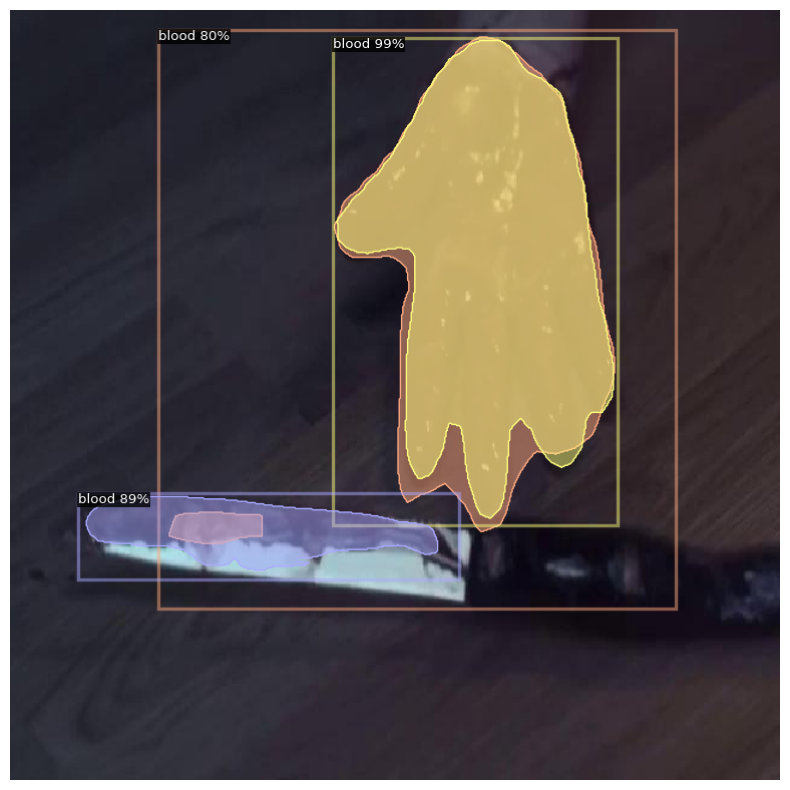

In [65]:

from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2

# ✅ Load trained model
cfg.MODEL.WEIGHTS = final_model_path  # Use the saved model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # Set confidence threshold
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

predictor = DefaultPredictor(cfg)

# ✅ Load test image
image_path = "/kaggle/input/blood-ds/test/1332_jpg.rf.dd018041d61fe93e90d5c5cefbaa62d0.jpg"  # Change to your test image path
image = cv2.imread(image_path)

# ✅ Make prediction
outputs = predictor(image)
pred_masks = outputs["instances"].pred_masks.cpu().numpy()
print("Predictions:", outputs)  # Print output for debugging

import matplotlib.pyplot as plt

# ✅ Visualize results
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# ✅ Show image
plt.figure(figsize=(10, 10))
plt.imshow(v.get_image())
plt.axis("off")
plt.show()

[02/12 21:33:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/model2_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Predictions: {'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[579.4816, 495.5471, 618.9344, 569.7050],
        [236.4920, 202.9954, 275.9964, 263.9774]], device='cuda:0')), scores: tensor([0.9062, 0.8955], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ...

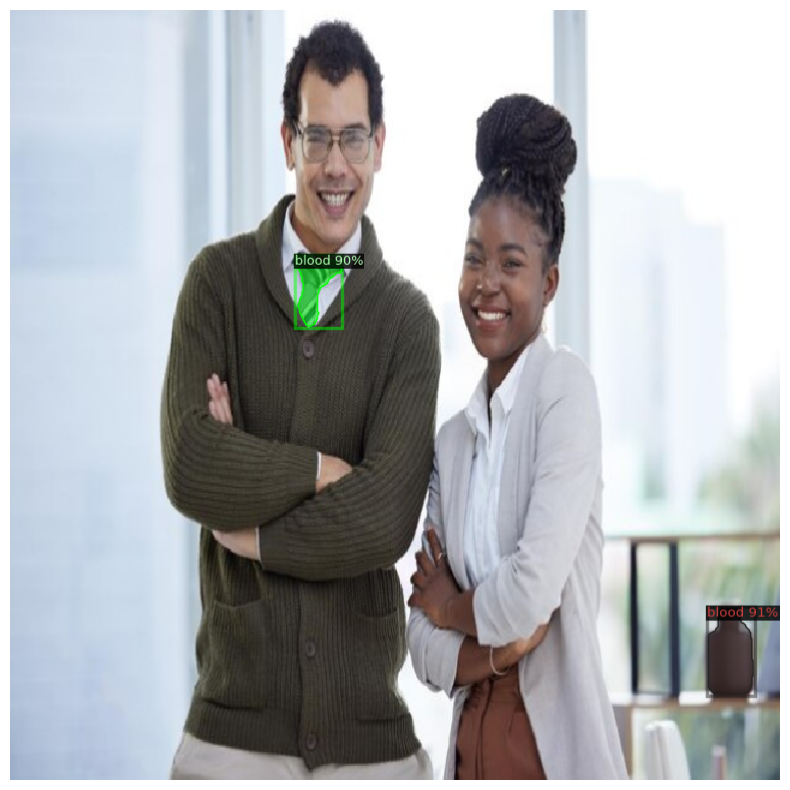

Instance 1 has 2313 pixels.
Instance 2 has 1177 pixels.
Total pixels in the image: 409600


In [98]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt
import numpy as np

# ✅ Load trained model
cfg.MODEL.WEIGHTS = final_model_path  # Use the saved model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # Set confidence threshold
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

predictor = DefaultPredictor(cfg)

# ✅ Load test image
image_path = "/kaggle/input/gendertest/1p.jpg"  # Change to your test image path
image = cv2.imread(image_path)
image=cv2.resize(image,(640,640))
# ✅ Make prediction
outputs = predictor(image)
pred_masks = outputs["instances"].pred_masks.cpu().numpy()
print("Predictions:", outputs)  # Print output for debugging

# ✅ Visualize results with only masks (no bounding boxes)
v = Visualizer(image[:, :, ::-1], 
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
               scale=1.2)

# Draw instance predictions without bounding boxes
# This should draw only the masks without the bounding boxes
v_output = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()

# ✅ Show image with only masks (no bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(v_output)
plt.axis("off")
plt.show()
for idx, mask in enumerate(pred_masks):
    # Count number of non-zero pixels (i.e., part of the object)
    mask_area = np.sum(mask)  # This will count the number of 1s in the mask (the object area)
    print(f"Instance {idx+1} has {mask_area} pixels.")
height, width, _ = image.shape
total_pixels = height * width
print(f"Total pixels in the image: {total_pixels}")

[02/12 20:49:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/model2_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Predictions: {'instances': Instances(num_instances=4, image_height=408, image_width=612, fields=[pred_boxes: Boxes(tensor([[371.3530,  83.8394, 483.0331, 301.1834],
        [  0.0000,   0.9385,  61.9683, 394.2971],
        [320.9690,  24.6344, 561.3112, 351.0125],
        [371.4852,  74.0188, 456.0563, 157.0809]], device='cuda:0')), scores: tensor([0.9775, 0.9745, 0.9527, 0.9465], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, F

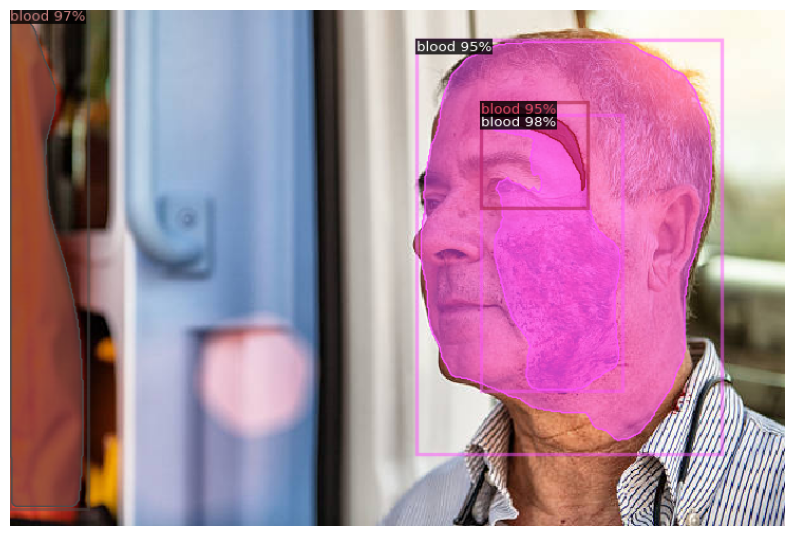

In [62]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# ✅ Load trained model
cfg.MODEL.WEIGHTS = final_model_path  # Use the saved model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # Set confidence threshold
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

predictor = DefaultPredictor(cfg)

# ✅ Load test image
image_path = "/kaggle/input/blmodeltest/bltest9.jpg"  # Change to your test image path
image = cv2.imread(image_path)

# ✅ Make prediction
outputs = predictor(image)
pred_masks = outputs["instances"].pred_masks.cpu().numpy()
print("Predictions:", outputs)  # Print output for debugging

# ✅ Visualize results with enhancements
v = Visualizer(image[:, :, ::-1], 
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
               scale=1.2)

# Draw instance predictions
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Retrieve the visualized image
v_output = v.get_image()

# ✅ Show image with improved segmentation clarity
plt.figure(figsize=(10, 10))
plt.imshow(v_output)
plt.axis("off")
plt.show()


In [37]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# ✅ Create COCO Evaluator
evaluator = COCOEvaluator("blood_valid", cfg, False, output_dir=cfg.OUTPUT_DIR)

# ✅ Create Data Loader
val_loader = build_detection_test_loader(cfg, "blood_valid")

# ✅ Run Evaluation
results = inference_on_dataset(trainer.model, val_loader, evaluator)

# ✅ Print Results
print("Evaluation Results:", results)

WARNING [02/12 20:29:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [02/12 20:29:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/12 20:29:59 d2.data.datasets.coco]: Loaded 232 images in COCO format from /kaggle/input/jsons11/fixedvalid_annotations.json
[02/12 20:29:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/12 20:29:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/12 20:29:59 d2.data.common]: Serializing 232 elements to byte tensors and concatenating them all ...
[02/12 20:29:59 d2.data.common]: Serialized dataset takes 0.18 MiB
[02/12 20:29:59 d2.evaluation.evaluator]: Start inference on 232 batches
[02/12 20:30:01 d2.eva

## Fine tune again

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import torch
import os

# ✅ Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ✅ Correct dataset paths
DATASET_PATH = "/kaggle/input/blood-sdataset/blood3"
TRAIN_JSON = "/kaggle/input/blood-sdataset/blood3/trainfixed2_annotation.json"
TRAIN_IMAGES = f"{DATASET_PATH}/train"  # ✅ No separate "images" folder
VALID_JSON = "/kaggle/input/blood-sdataset/blood3/validfixed2_annotation.json"
VALID_IMAGES = f"{DATASET_PATH}/valid"  # ✅ No separate "images" folder

# ✅ Ensure dataset paths exist
assert os.path.exists(TRAIN_JSON), f"Missing: {TRAIN_JSON}"
assert os.path.exists(TRAIN_IMAGES), f"Missing: {TRAIN_IMAGES}"
assert os.path.exists(VALID_JSON), f"Missing: {VALID_JSON}"
assert os.path.exists(VALID_IMAGES), f"Missing: {VALID_IMAGES}"

# ✅ Register datasets correctly
register_coco_instances("new_blood_train", {}, TRAIN_JSON, TRAIN_IMAGES)
register_coco_instances("new_blood_valid", {}, VALID_JSON, VALID_IMAGES)

Using device: cuda


In [4]:
import os
import logging
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo

# ✅ Set up logging
setup_logger()

# ✅ Load configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

# ✅ Update dataset (Replace with your new dataset)
cfg.DATASETS.TRAIN = ("new_blood_train",)
cfg.DATASETS.TEST = ("new_blood_valid",)

cfg.DATALOADER.NUM_WORKERS = 4  

# ✅ Load the last trained model instead of COCO weights
cfg.MODEL.WEIGHTS = "/kaggle/input/bloodmodel/pytorch/default/1/model2_final.pth"  # Path to last trained model

# ✅ Adjust hyperparameters for fine-tuning
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001  # Lower LR for fine-tuning
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 5000  # Continue training for more iterations
cfg.SOLVER.STEPS = [3000, 4500]  
cfg.SOLVER.GAMMA = 0.1  

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Update if number of classes changed

cfg.SOLVER.AMP.ENABLED = True

cfg.OUTPUT_DIR = "/kaggle/working/new_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# ✅ Enable detailed logging
cfg.LOG_LEVEL = logging.DEBUG  

# ✅ Train the model from last checkpoint
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)  # Resume training from the last saved weights
trainer.train()


[02/13 00:13:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start settin

[02/13 00:13:53 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with aut

[02/13 00:14:03 d2.utils.events]:  eta: 0:25:20  iter: 19  total_loss: 0.7391  loss_cls: 0.1767  loss_box_reg: 0.2643  loss_mask: 0.233  loss_rpn_cls: 0.02731  loss_rpn_loc: 0.03991    time: 0.3044  last_time: 0.3184  data_time: 0.0213  last_data_time: 0.0037   lr: 3.8962e-06  max_mem: 2343M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:14:24 d2.utils.events]:  eta: 0:25:43  iter: 39  total_loss: 1.037  loss_cls: 0.2079  loss_box_reg: 0.4256  loss_mask: 0.3081  loss_rpn_cls: 0.03008  loss_rpn_loc: 0.01583    time: 0.3082  last_time: 0.3132  data_time: 0.0061  last_data_time: 0.0103   lr: 7.8922e-06  max_mem: 2377M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:14:30 d2.utils.events]:  eta: 0:25:30  iter: 59  total_loss: 1.028  loss_cls: 0.1831  loss_box_reg: 0.4187  loss_mask: 0.3058  loss_rpn_cls: 0.01719  loss_rpn_loc: 0.01351    time: 0.3039  last_time: 0.2607  data_time: 0.0056  last_data_time: 0.0036   lr: 1.1888e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:14:36 d2.utils.events]:  eta: 0:25:28  iter: 79  total_loss: 0.9821  loss_cls: 0.2061  loss_box_reg: 0.4143  loss_mask: 0.2737  loss_rpn_cls: 0.02192  loss_rpn_loc: 0.01824    time: 0.3039  last_time: 0.3125  data_time: 0.0059  last_data_time: 0.0056   lr: 1.5884e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:14:42 d2.utils.events]:  eta: 0:25:17  iter: 99  total_loss: 0.905  loss_cls: 0.1949  loss_box_reg: 0.4108  loss_mask: 0.2661  loss_rpn_cls: 0.02016  loss_rpn_loc: 0.01538    time: 0.3020  last_time: 0.3277  data_time: 0.0058  last_data_time: 0.0041   lr: 1.988e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:14:48 d2.utils.events]:  eta: 0:25:05  iter: 119  total_loss: 0.8628  loss_cls: 0.1979  loss_box_reg: 0.3317  loss_mask: 0.2586  loss_rpn_cls: 0.01849  loss_rpn_loc: 0.0201    time: 0.3006  last_time: 0.2790  data_time: 0.0062  last_data_time: 0.0062   lr: 2.3876e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:14:54 d2.utils.events]:  eta: 0:24:53  iter: 139  total_loss: 0.9372  loss_cls: 0.16  loss_box_reg: 0.4152  loss_mask: 0.2456  loss_rpn_cls: 0.02576  loss_rpn_loc: 0.019    time: 0.2974  last_time: 0.2824  data_time: 0.0056  last_data_time: 0.0055   lr: 2.7872e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:00 d2.utils.events]:  eta: 0:24:46  iter: 159  total_loss: 0.905  loss_cls: 0.1956  loss_box_reg: 0.2811  loss_mask: 0.2318  loss_rpn_cls: 0.02241  loss_rpn_loc: 0.03696    time: 0.2978  last_time: 0.2865  data_time: 0.0061  last_data_time: 0.0079   lr: 3.1868e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:06 d2.utils.events]:  eta: 0:24:40  iter: 179  total_loss: 0.935  loss_cls: 0.2166  loss_box_reg: 0.3773  loss_mask: 0.2592  loss_rpn_cls: 0.01801  loss_rpn_loc: 0.0234    time: 0.2979  last_time: 0.3289  data_time: 0.0060  last_data_time: 0.0039   lr: 3.5864e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:12 d2.utils.events]:  eta: 0:24:36  iter: 199  total_loss: 0.9348  loss_cls: 0.1884  loss_box_reg: 0.3985  loss_mask: 0.2735  loss_rpn_cls: 0.02068  loss_rpn_loc: 0.02069    time: 0.2986  last_time: 0.3195  data_time: 0.0063  last_data_time: 0.0026   lr: 3.986e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:18 d2.utils.events]:  eta: 0:24:28  iter: 219  total_loss: 0.9317  loss_cls: 0.2178  loss_box_reg: 0.3818  loss_mask: 0.2829  loss_rpn_cls: 0.02363  loss_rpn_loc: 0.02124    time: 0.2980  last_time: 0.3263  data_time: 0.0063  last_data_time: 0.0055   lr: 4.3856e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:24 d2.utils.events]:  eta: 0:24:15  iter: 239  total_loss: 0.9877  loss_cls: 0.2298  loss_box_reg: 0.4052  loss_mask: 0.2875  loss_rpn_cls: 0.02541  loss_rpn_loc: 0.0245    time: 0.2980  last_time: 0.3229  data_time: 0.0107  last_data_time: 0.0085   lr: 4.7852e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:30 d2.utils.events]:  eta: 0:24:11  iter: 259  total_loss: 1.056  loss_cls: 0.2035  loss_box_reg: 0.4041  loss_mask: 0.2624  loss_rpn_cls: 0.02901  loss_rpn_loc: 0.03052    time: 0.2980  last_time: 0.2605  data_time: 0.0088  last_data_time: 0.0047   lr: 5.1848e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:36 d2.utils.events]:  eta: 0:24:11  iter: 279  total_loss: 1.121  loss_cls: 0.2016  loss_box_reg: 0.3729  loss_mask: 0.2954  loss_rpn_cls: 0.02506  loss_rpn_loc: 0.03635    time: 0.2986  last_time: 0.3084  data_time: 0.0059  last_data_time: 0.0041   lr: 5.5844e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:42 d2.utils.events]:  eta: 0:24:05  iter: 299  total_loss: 0.8836  loss_cls: 0.1803  loss_box_reg: 0.3692  loss_mask: 0.2441  loss_rpn_cls: 0.02958  loss_rpn_loc: 0.02065    time: 0.2994  last_time: 0.3318  data_time: 0.0062  last_data_time: 0.0081   lr: 5.984e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:48 d2.utils.events]:  eta: 0:23:59  iter: 319  total_loss: 0.9569  loss_cls: 0.1933  loss_box_reg: 0.3706  loss_mask: 0.2705  loss_rpn_cls: 0.03081  loss_rpn_loc: 0.01723    time: 0.2994  last_time: 0.2834  data_time: 0.0062  last_data_time: 0.0060   lr: 6.3836e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:15:54 d2.utils.events]:  eta: 0:23:54  iter: 339  total_loss: 1.132  loss_cls: 0.1674  loss_box_reg: 0.4948  loss_mask: 0.2686  loss_rpn_cls: 0.02714  loss_rpn_loc: 0.01834    time: 0.3001  last_time: 0.2717  data_time: 0.0164  last_data_time: 0.0043   lr: 6.7832e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:00 d2.utils.events]:  eta: 0:23:46  iter: 359  total_loss: 0.8989  loss_cls: 0.2093  loss_box_reg: 0.3486  loss_mask: 0.237  loss_rpn_cls: 0.02322  loss_rpn_loc: 0.02048    time: 0.2997  last_time: 0.2967  data_time: 0.0066  last_data_time: 0.0071   lr: 7.1828e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:06 d2.utils.events]:  eta: 0:23:40  iter: 379  total_loss: 0.6657  loss_cls: 0.1198  loss_box_reg: 0.255  loss_mask: 0.2271  loss_rpn_cls: 0.01878  loss_rpn_loc: 0.01018    time: 0.3002  last_time: 0.2954  data_time: 0.0059  last_data_time: 0.0059   lr: 7.5824e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:12 d2.utils.events]:  eta: 0:23:33  iter: 399  total_loss: 0.9844  loss_cls: 0.2285  loss_box_reg: 0.393  loss_mask: 0.2569  loss_rpn_cls: 0.03233  loss_rpn_loc: 0.01539    time: 0.2996  last_time: 0.3292  data_time: 0.0064  last_data_time: 0.0089   lr: 7.982e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:18 d2.utils.events]:  eta: 0:23:22  iter: 419  total_loss: 0.963  loss_cls: 0.1576  loss_box_reg: 0.3223  loss_mask: 0.2442  loss_rpn_cls: 0.02329  loss_rpn_loc: 0.02241    time: 0.3002  last_time: 0.2746  data_time: 0.0227  last_data_time: 0.0076   lr: 8.3816e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:24 d2.utils.events]:  eta: 0:23:16  iter: 439  total_loss: 0.9667  loss_cls: 0.2353  loss_box_reg: 0.4093  loss_mask: 0.2903  loss_rpn_cls: 0.02662  loss_rpn_loc: 0.01652    time: 0.3005  last_time: 0.3028  data_time: 0.0061  last_data_time: 0.0039   lr: 8.7812e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:31 d2.utils.events]:  eta: 0:23:13  iter: 459  total_loss: 0.9307  loss_cls: 0.175  loss_box_reg: 0.4031  loss_mask: 0.2704  loss_rpn_cls: 0.01868  loss_rpn_loc: 0.01409    time: 0.3007  last_time: 0.3286  data_time: 0.0062  last_data_time: 0.0056   lr: 9.1808e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:37 d2.utils.events]:  eta: 0:23:06  iter: 479  total_loss: 1.126  loss_cls: 0.2164  loss_box_reg: 0.4283  loss_mask: 0.2941  loss_rpn_cls: 0.0311  loss_rpn_loc: 0.017    time: 0.3005  last_time: 0.3310  data_time: 0.0061  last_data_time: 0.0047   lr: 9.5804e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:43 d2.utils.events]:  eta: 0:23:00  iter: 499  total_loss: 1.067  loss_cls: 0.2121  loss_box_reg: 0.412  loss_mask: 0.273  loss_rpn_cls: 0.03242  loss_rpn_loc: 0.03434    time: 0.3006  last_time: 0.2959  data_time: 0.0060  last_data_time: 0.0015   lr: 9.98e-05  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:49 d2.utils.events]:  eta: 0:22:54  iter: 519  total_loss: 0.8274  loss_cls: 0.1608  loss_box_reg: 0.3634  loss_mask: 0.2513  loss_rpn_cls: 0.02524  loss_rpn_loc: 0.02103    time: 0.3008  last_time: 0.2783  data_time: 0.0063  last_data_time: 0.0065   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:16:55 d2.utils.events]:  eta: 0:22:50  iter: 539  total_loss: 0.8698  loss_cls: 0.1612  loss_box_reg: 0.3921  loss_mask: 0.2219  loss_rpn_cls: 0.02692  loss_rpn_loc: 0.01775    time: 0.3007  last_time: 0.2631  data_time: 0.0066  last_data_time: 0.0059   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:01 d2.utils.events]:  eta: 0:22:44  iter: 559  total_loss: 1.076  loss_cls: 0.2135  loss_box_reg: 0.4592  loss_mask: 0.2876  loss_rpn_cls: 0.03482  loss_rpn_loc: 0.0305    time: 0.3009  last_time: 0.2502  data_time: 0.0058  last_data_time: 0.0053   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:07 d2.utils.events]:  eta: 0:22:40  iter: 579  total_loss: 0.891  loss_cls: 0.1862  loss_box_reg: 0.3757  loss_mask: 0.2772  loss_rpn_cls: 0.01519  loss_rpn_loc: 0.01097    time: 0.3013  last_time: 0.3517  data_time: 0.0064  last_data_time: 0.0084   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:13 d2.utils.events]:  eta: 0:22:32  iter: 599  total_loss: 0.9183  loss_cls: 0.197  loss_box_reg: 0.3752  loss_mask: 0.2506  loss_rpn_cls: 0.02073  loss_rpn_loc: 0.01715    time: 0.3010  last_time: 0.3445  data_time: 0.0058  last_data_time: 0.0048   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:19 d2.utils.events]:  eta: 0:22:26  iter: 619  total_loss: 0.9435  loss_cls: 0.2093  loss_box_reg: 0.4516  loss_mask: 0.2612  loss_rpn_cls: 0.01981  loss_rpn_loc: 0.01568    time: 0.3013  last_time: 0.3499  data_time: 0.0066  last_data_time: 0.0115   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:25 d2.utils.events]:  eta: 0:22:20  iter: 639  total_loss: 1.204  loss_cls: 0.224  loss_box_reg: 0.4599  loss_mask: 0.2995  loss_rpn_cls: 0.02774  loss_rpn_loc: 0.02801    time: 0.3013  last_time: 0.2983  data_time: 0.0059  last_data_time: 0.0053   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:32 d2.utils.events]:  eta: 0:22:15  iter: 659  total_loss: 0.9404  loss_cls: 0.1616  loss_box_reg: 0.422  loss_mask: 0.2799  loss_rpn_cls: 0.024  loss_rpn_loc: 0.03364    time: 0.3020  last_time: 0.2816  data_time: 0.0278  last_data_time: 0.0098   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:38 d2.utils.events]:  eta: 0:22:13  iter: 679  total_loss: 0.9478  loss_cls: 0.1953  loss_box_reg: 0.3964  loss_mask: 0.3038  loss_rpn_cls: 0.02342  loss_rpn_loc: 0.01856    time: 0.3025  last_time: 0.2989  data_time: 0.0059  last_data_time: 0.0062   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:44 d2.utils.events]:  eta: 0:22:08  iter: 699  total_loss: 0.9557  loss_cls: 0.2279  loss_box_reg: 0.3791  loss_mask: 0.3131  loss_rpn_cls: 0.01531  loss_rpn_loc: 0.01193    time: 0.3027  last_time: 0.3394  data_time: 0.0060  last_data_time: 0.0057   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:50 d2.utils.events]:  eta: 0:22:03  iter: 719  total_loss: 0.8965  loss_cls: 0.1713  loss_box_reg: 0.3664  loss_mask: 0.2407  loss_rpn_cls: 0.01946  loss_rpn_loc: 0.01693    time: 0.3027  last_time: 0.3494  data_time: 0.0063  last_data_time: 0.0087   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:17:57 d2.utils.events]:  eta: 0:21:56  iter: 739  total_loss: 0.8258  loss_cls: 0.1661  loss_box_reg: 0.3846  loss_mask: 0.2197  loss_rpn_cls: 0.01465  loss_rpn_loc: 0.02852    time: 0.3028  last_time: 0.3341  data_time: 0.0064  last_data_time: 0.0047   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:02 d2.utils.events]:  eta: 0:21:50  iter: 759  total_loss: 0.8448  loss_cls: 0.1738  loss_box_reg: 0.3311  loss_mask: 0.2476  loss_rpn_cls: 0.0219  loss_rpn_loc: 0.02755    time: 0.3026  last_time: 0.3242  data_time: 0.0059  last_data_time: 0.0077   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:09 d2.utils.events]:  eta: 0:21:46  iter: 779  total_loss: 0.8555  loss_cls: 0.1639  loss_box_reg: 0.3734  loss_mask: 0.2307  loss_rpn_cls: 0.01375  loss_rpn_loc: 0.009532    time: 0.3027  last_time: 0.3273  data_time: 0.0059  last_data_time: 0.0058   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:15 d2.utils.events]:  eta: 0:21:41  iter: 799  total_loss: 0.8142  loss_cls: 0.1911  loss_box_reg: 0.3096  loss_mask: 0.2344  loss_rpn_cls: 0.01652  loss_rpn_loc: 0.01644    time: 0.3028  last_time: 0.2894  data_time: 0.0060  last_data_time: 0.0097   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:21 d2.utils.events]:  eta: 0:21:37  iter: 819  total_loss: 0.7549  loss_cls: 0.1422  loss_box_reg: 0.3266  loss_mask: 0.2221  loss_rpn_cls: 0.01845  loss_rpn_loc: 0.03008    time: 0.3031  last_time: 0.2726  data_time: 0.0059  last_data_time: 0.0044   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:28 d2.utils.events]:  eta: 0:21:32  iter: 839  total_loss: 0.9949  loss_cls: 0.1902  loss_box_reg: 0.4028  loss_mask: 0.264  loss_rpn_cls: 0.01674  loss_rpn_loc: 0.02659    time: 0.3036  last_time: 0.3116  data_time: 0.0063  last_data_time: 0.0061   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:34 d2.utils.events]:  eta: 0:21:27  iter: 859  total_loss: 0.9617  loss_cls: 0.1959  loss_box_reg: 0.3949  loss_mask: 0.2677  loss_rpn_cls: 0.026  loss_rpn_loc: 0.01417    time: 0.3040  last_time: 0.3397  data_time: 0.0198  last_data_time: 0.0064   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:40 d2.utils.events]:  eta: 0:21:23  iter: 879  total_loss: 0.8727  loss_cls: 0.1689  loss_box_reg: 0.3786  loss_mask: 0.2845  loss_rpn_cls: 0.01709  loss_rpn_loc: 0.01629    time: 0.3044  last_time: 0.3485  data_time: 0.0064  last_data_time: 0.0064   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:47 d2.utils.events]:  eta: 0:21:17  iter: 899  total_loss: 0.9437  loss_cls: 0.2239  loss_box_reg: 0.418  loss_mask: 0.2581  loss_rpn_cls: 0.01854  loss_rpn_loc: 0.02019    time: 0.3047  last_time: 0.3234  data_time: 0.0060  last_data_time: 0.0054   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:53 d2.utils.events]:  eta: 0:21:11  iter: 919  total_loss: 0.7333  loss_cls: 0.1334  loss_box_reg: 0.3773  loss_mask: 0.1974  loss_rpn_cls: 0.02065  loss_rpn_loc: 0.01642    time: 0.3045  last_time: 0.3599  data_time: 0.0060  last_data_time: 0.0055   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:18:59 d2.utils.events]:  eta: 0:21:05  iter: 939  total_loss: 0.9254  loss_cls: 0.19  loss_box_reg: 0.425  loss_mask: 0.267  loss_rpn_cls: 0.02254  loss_rpn_loc: 0.03236    time: 0.3048  last_time: 0.3167  data_time: 0.0128  last_data_time: 0.0042   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:05 d2.utils.events]:  eta: 0:20:59  iter: 959  total_loss: 0.8418  loss_cls: 0.1536  loss_box_reg: 0.3451  loss_mask: 0.2607  loss_rpn_cls: 0.01696  loss_rpn_loc: 0.01916    time: 0.3051  last_time: 0.2608  data_time: 0.0063  last_data_time: 0.0067   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:12 d2.utils.events]:  eta: 0:20:54  iter: 979  total_loss: 0.7628  loss_cls: 0.1405  loss_box_reg: 0.3004  loss_mask: 0.2532  loss_rpn_cls: 0.01528  loss_rpn_loc: 0.01564    time: 0.3053  last_time: 0.3395  data_time: 0.0061  last_data_time: 0.0083   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:18 d2.utils.events]:  eta: 0:20:50  iter: 999  total_loss: 0.7764  loss_cls: 0.1418  loss_box_reg: 0.35  loss_mask: 0.2537  loss_rpn_cls: 0.01337  loss_rpn_loc: 0.02281    time: 0.3058  last_time: 0.3400  data_time: 0.0058  last_data_time: 0.0056   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:25 d2.utils.events]:  eta: 0:20:45  iter: 1019  total_loss: 0.862  loss_cls: 0.177  loss_box_reg: 0.3627  loss_mask: 0.227  loss_rpn_cls: 0.01895  loss_rpn_loc: 0.01859    time: 0.3058  last_time: 0.3076  data_time: 0.0060  last_data_time: 0.0058   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:30 d2.utils.events]:  eta: 0:20:39  iter: 1039  total_loss: 0.7631  loss_cls: 0.1742  loss_box_reg: 0.3778  loss_mask: 0.211  loss_rpn_cls: 0.02224  loss_rpn_loc: 0.01745    time: 0.3056  last_time: 0.3029  data_time: 0.0063  last_data_time: 0.0065   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:37 d2.utils.events]:  eta: 0:20:33  iter: 1059  total_loss: 0.9547  loss_cls: 0.1785  loss_box_reg: 0.4158  loss_mask: 0.2721  loss_rpn_cls: 0.02255  loss_rpn_loc: 0.01304    time: 0.3057  last_time: 0.2973  data_time: 0.0061  last_data_time: 0.0036   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:43 d2.utils.events]:  eta: 0:20:28  iter: 1079  total_loss: 0.7723  loss_cls: 0.1427  loss_box_reg: 0.3048  loss_mask: 0.2713  loss_rpn_cls: 0.01404  loss_rpn_loc: 0.02209    time: 0.3059  last_time: 0.2944  data_time: 0.0061  last_data_time: 0.0043   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:49 d2.utils.events]:  eta: 0:20:24  iter: 1099  total_loss: 1.008  loss_cls: 0.1878  loss_box_reg: 0.3877  loss_mask: 0.2748  loss_rpn_cls: 0.02431  loss_rpn_loc: 0.01504    time: 0.3061  last_time: 0.2037  data_time: 0.0062  last_data_time: 0.0059   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:19:56 d2.utils.events]:  eta: 0:20:19  iter: 1119  total_loss: 1.023  loss_cls: 0.2226  loss_box_reg: 0.4368  loss_mask: 0.2862  loss_rpn_cls: 0.0262  loss_rpn_loc: 0.02076    time: 0.3062  last_time: 0.3842  data_time: 0.0075  last_data_time: 0.0384   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:02 d2.utils.events]:  eta: 0:20:15  iter: 1139  total_loss: 0.8946  loss_cls: 0.1963  loss_box_reg: 0.385  loss_mask: 0.2678  loss_rpn_cls: 0.01999  loss_rpn_loc: 0.01121    time: 0.3062  last_time: 0.3446  data_time: 0.0059  last_data_time: 0.0062   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:08 d2.utils.events]:  eta: 0:20:11  iter: 1159  total_loss: 0.9621  loss_cls: 0.1708  loss_box_reg: 0.3855  loss_mask: 0.267  loss_rpn_cls: 0.01827  loss_rpn_loc: 0.0252    time: 0.3066  last_time: 0.3045  data_time: 0.0065  last_data_time: 0.0053   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:14 d2.utils.events]:  eta: 0:20:06  iter: 1179  total_loss: 0.8504  loss_cls: 0.1663  loss_box_reg: 0.379  loss_mask: 0.2544  loss_rpn_cls: 0.01807  loss_rpn_loc: 0.03637    time: 0.3065  last_time: 0.3235  data_time: 0.0061  last_data_time: 0.0073   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:21 d2.utils.events]:  eta: 0:20:00  iter: 1199  total_loss: 0.7768  loss_cls: 0.1712  loss_box_reg: 0.31  loss_mask: 0.1903  loss_rpn_cls: 0.0207  loss_rpn_loc: 0.01718    time: 0.3066  last_time: 0.3472  data_time: 0.0062  last_data_time: 0.0041   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:27 d2.utils.events]:  eta: 0:19:55  iter: 1219  total_loss: 0.8563  loss_cls: 0.176  loss_box_reg: 0.3287  loss_mask: 0.2429  loss_rpn_cls: 0.01854  loss_rpn_loc: 0.02191    time: 0.3066  last_time: 0.3421  data_time: 0.0063  last_data_time: 0.0074   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:33 d2.utils.events]:  eta: 0:19:50  iter: 1239  total_loss: 0.69  loss_cls: 0.1179  loss_box_reg: 0.2495  loss_mask: 0.2246  loss_rpn_cls: 0.0152  loss_rpn_loc: 0.01864    time: 0.3066  last_time: 0.3130  data_time: 0.0074  last_data_time: 0.0092   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:39 d2.utils.events]:  eta: 0:19:44  iter: 1259  total_loss: 0.8128  loss_cls: 0.167  loss_box_reg: 0.3978  loss_mask: 0.2017  loss_rpn_cls: 0.01828  loss_rpn_loc: 0.01466    time: 0.3068  last_time: 0.2906  data_time: 0.0064  last_data_time: 0.0044   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:46 d2.utils.events]:  eta: 0:19:36  iter: 1279  total_loss: 0.8182  loss_cls: 0.1634  loss_box_reg: 0.3244  loss_mask: 0.2303  loss_rpn_cls: 0.0159  loss_rpn_loc: 0.02232    time: 0.3069  last_time: 0.2843  data_time: 0.0062  last_data_time: 0.0083   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:52 d2.utils.events]:  eta: 0:19:32  iter: 1299  total_loss: 0.9177  loss_cls: 0.1614  loss_box_reg: 0.3936  loss_mask: 0.2629  loss_rpn_cls: 0.02035  loss_rpn_loc: 0.02043    time: 0.3070  last_time: 0.3426  data_time: 0.0061  last_data_time: 0.0049   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:20:58 d2.utils.events]:  eta: 0:19:23  iter: 1319  total_loss: 0.704  loss_cls: 0.1437  loss_box_reg: 0.3171  loss_mask: 0.2047  loss_rpn_cls: 0.01443  loss_rpn_loc: 0.01663    time: 0.3069  last_time: 0.3555  data_time: 0.0063  last_data_time: 0.0049   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:04 d2.utils.events]:  eta: 0:19:18  iter: 1339  total_loss: 1.001  loss_cls: 0.1828  loss_box_reg: 0.3804  loss_mask: 0.2442  loss_rpn_cls: 0.03293  loss_rpn_loc: 0.02373    time: 0.3071  last_time: 0.3551  data_time: 0.0068  last_data_time: 0.0073   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:11 d2.utils.events]:  eta: 0:19:16  iter: 1359  total_loss: 0.8359  loss_cls: 0.1418  loss_box_reg: 0.3338  loss_mask: 0.2384  loss_rpn_cls: 0.01718  loss_rpn_loc: 0.01714    time: 0.3072  last_time: 0.3420  data_time: 0.0070  last_data_time: 0.0071   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:17 d2.utils.events]:  eta: 0:19:09  iter: 1379  total_loss: 0.9451  loss_cls: 0.2262  loss_box_reg: 0.4471  loss_mask: 0.2408  loss_rpn_cls: 0.01515  loss_rpn_loc: 0.01608    time: 0.3074  last_time: 0.3382  data_time: 0.0064  last_data_time: 0.0082   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:23 d2.utils.events]:  eta: 0:19:03  iter: 1399  total_loss: 0.7528  loss_cls: 0.1491  loss_box_reg: 0.3108  loss_mask: 0.2314  loss_rpn_cls: 0.01479  loss_rpn_loc: 0.01555    time: 0.3073  last_time: 0.3174  data_time: 0.0061  last_data_time: 0.0061   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:29 d2.utils.events]:  eta: 0:18:59  iter: 1419  total_loss: 0.7724  loss_cls: 0.1868  loss_box_reg: 0.3239  loss_mask: 0.2118  loss_rpn_cls: 0.01416  loss_rpn_loc: 0.02078    time: 0.3075  last_time: 0.3407  data_time: 0.0061  last_data_time: 0.0058   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:36 d2.utils.events]:  eta: 0:18:55  iter: 1439  total_loss: 0.8793  loss_cls: 0.1594  loss_box_reg: 0.4195  loss_mask: 0.2516  loss_rpn_cls: 0.01757  loss_rpn_loc: 0.01211    time: 0.3075  last_time: 0.2904  data_time: 0.0062  last_data_time: 0.0064   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:42 d2.utils.events]:  eta: 0:18:50  iter: 1459  total_loss: 0.8462  loss_cls: 0.165  loss_box_reg: 0.3537  loss_mask: 0.2345  loss_rpn_cls: 0.01253  loss_rpn_loc: 0.01651    time: 0.3079  last_time: 0.3465  data_time: 0.0066  last_data_time: 0.0039   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:49 d2.utils.events]:  eta: 0:18:44  iter: 1479  total_loss: 0.7676  loss_cls: 0.1328  loss_box_reg: 0.3358  loss_mask: 0.2251  loss_rpn_cls: 0.01205  loss_rpn_loc: 0.01877    time: 0.3080  last_time: 0.3108  data_time: 0.0102  last_data_time: 0.0045   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:21:55 d2.utils.events]:  eta: 0:18:39  iter: 1499  total_loss: 0.954  loss_cls: 0.1974  loss_box_reg: 0.4266  loss_mask: 0.2931  loss_rpn_cls: 0.01562  loss_rpn_loc: 0.017    time: 0.3081  last_time: 0.3414  data_time: 0.0062  last_data_time: 0.0059   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:01 d2.utils.events]:  eta: 0:18:31  iter: 1519  total_loss: 0.754  loss_cls: 0.1691  loss_box_reg: 0.2876  loss_mask: 0.2182  loss_rpn_cls: 0.01924  loss_rpn_loc: 0.02046    time: 0.3081  last_time: 0.3437  data_time: 0.0062  last_data_time: 0.0068   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:07 d2.utils.events]:  eta: 0:18:24  iter: 1539  total_loss: 0.9553  loss_cls: 0.2105  loss_box_reg: 0.3703  loss_mask: 0.3258  loss_rpn_cls: 0.01901  loss_rpn_loc: 0.0323    time: 0.3082  last_time: 0.3768  data_time: 0.0063  last_data_time: 0.0052   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:14 d2.utils.events]:  eta: 0:18:17  iter: 1559  total_loss: 1.061  loss_cls: 0.2007  loss_box_reg: 0.452  loss_mask: 0.2655  loss_rpn_cls: 0.01953  loss_rpn_loc: 0.01898    time: 0.3082  last_time: 0.2998  data_time: 0.0064  last_data_time: 0.0089   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:20 d2.utils.events]:  eta: 0:18:10  iter: 1579  total_loss: 0.834  loss_cls: 0.1519  loss_box_reg: 0.3296  loss_mask: 0.256  loss_rpn_cls: 0.01913  loss_rpn_loc: 0.01397    time: 0.3081  last_time: 0.2983  data_time: 0.0059  last_data_time: 0.0058   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:26 d2.utils.events]:  eta: 0:18:05  iter: 1599  total_loss: 0.7739  loss_cls: 0.1615  loss_box_reg: 0.3587  loss_mask: 0.2202  loss_rpn_cls: 0.01453  loss_rpn_loc: 0.01128    time: 0.3083  last_time: 0.2776  data_time: 0.0065  last_data_time: 0.0091   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:33 d2.utils.events]:  eta: 0:17:59  iter: 1619  total_loss: 0.7919  loss_cls: 0.1655  loss_box_reg: 0.3404  loss_mask: 0.2519  loss_rpn_cls: 0.01923  loss_rpn_loc: 0.01704    time: 0.3085  last_time: 0.2952  data_time: 0.0063  last_data_time: 0.0084   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:39 d2.utils.events]:  eta: 0:17:53  iter: 1639  total_loss: 0.874  loss_cls: 0.164  loss_box_reg: 0.3991  loss_mask: 0.2338  loss_rpn_cls: 0.01742  loss_rpn_loc: 0.01693    time: 0.3085  last_time: 0.2344  data_time: 0.0063  last_data_time: 0.0063   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:45 d2.utils.events]:  eta: 0:17:49  iter: 1659  total_loss: 1.06  loss_cls: 0.2157  loss_box_reg: 0.4182  loss_mask: 0.2852  loss_rpn_cls: 0.01712  loss_rpn_loc: 0.01352    time: 0.3087  last_time: 0.2317  data_time: 0.0064  last_data_time: 0.0066   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:52 d2.utils.events]:  eta: 0:17:40  iter: 1679  total_loss: 1.007  loss_cls: 0.2535  loss_box_reg: 0.4247  loss_mask: 0.2817  loss_rpn_cls: 0.01961  loss_rpn_loc: 0.02254    time: 0.3086  last_time: 0.3038  data_time: 0.0063  last_data_time: 0.0034   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:22:58 d2.utils.events]:  eta: 0:17:37  iter: 1699  total_loss: 0.8763  loss_cls: 0.1558  loss_box_reg: 0.3821  loss_mask: 0.2731  loss_rpn_cls: 0.01477  loss_rpn_loc: 0.02455    time: 0.3088  last_time: 0.2050  data_time: 0.0064  last_data_time: 0.0076   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:04 d2.utils.events]:  eta: 0:17:28  iter: 1719  total_loss: 0.9961  loss_cls: 0.2035  loss_box_reg: 0.3548  loss_mask: 0.2536  loss_rpn_cls: 0.02001  loss_rpn_loc: 0.02267    time: 0.3088  last_time: 0.2223  data_time: 0.0064  last_data_time: 0.0089   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:10 d2.utils.events]:  eta: 0:17:22  iter: 1739  total_loss: 0.835  loss_cls: 0.1978  loss_box_reg: 0.3245  loss_mask: 0.256  loss_rpn_cls: 0.02067  loss_rpn_loc: 0.01658    time: 0.3088  last_time: 0.3428  data_time: 0.0059  last_data_time: 0.0041   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:17 d2.utils.events]:  eta: 0:17:18  iter: 1759  total_loss: 0.8469  loss_cls: 0.1515  loss_box_reg: 0.3679  loss_mask: 0.3008  loss_rpn_cls: 0.03542  loss_rpn_loc: 0.02126    time: 0.3088  last_time: 0.3537  data_time: 0.0067  last_data_time: 0.0092   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:23 d2.utils.events]:  eta: 0:17:12  iter: 1779  total_loss: 1.016  loss_cls: 0.2264  loss_box_reg: 0.4359  loss_mask: 0.2828  loss_rpn_cls: 0.02225  loss_rpn_loc: 0.02069    time: 0.3089  last_time: 0.3441  data_time: 0.0064  last_data_time: 0.0072   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:29 d2.utils.events]:  eta: 0:17:07  iter: 1799  total_loss: 0.8422  loss_cls: 0.1959  loss_box_reg: 0.3495  loss_mask: 0.2  loss_rpn_cls: 0.02492  loss_rpn_loc: 0.0355    time: 0.3089  last_time: 0.3484  data_time: 0.0064  last_data_time: 0.0049   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:35 d2.utils.events]:  eta: 0:17:01  iter: 1819  total_loss: 1.025  loss_cls: 0.219  loss_box_reg: 0.399  loss_mask: 0.2415  loss_rpn_cls: 0.02177  loss_rpn_loc: 0.02921    time: 0.3090  last_time: 0.3482  data_time: 0.0068  last_data_time: 0.0090   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:42 d2.utils.events]:  eta: 0:16:52  iter: 1839  total_loss: 0.7426  loss_cls: 0.1383  loss_box_reg: 0.3736  loss_mask: 0.2194  loss_rpn_cls: 0.009546  loss_rpn_loc: 0.01708    time: 0.3090  last_time: 0.3560  data_time: 0.0065  last_data_time: 0.0077   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:49 d2.utils.events]:  eta: 0:16:47  iter: 1859  total_loss: 0.941  loss_cls: 0.1692  loss_box_reg: 0.386  loss_mask: 0.2899  loss_rpn_cls: 0.0165  loss_rpn_loc: 0.01294    time: 0.3094  last_time: 0.3460  data_time: 0.0292  last_data_time: 0.0055   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:23:55 d2.utils.events]:  eta: 0:16:39  iter: 1879  total_loss: 0.938  loss_cls: 0.2268  loss_box_reg: 0.4035  loss_mask: 0.2576  loss_rpn_cls: 0.01586  loss_rpn_loc: 0.01754    time: 0.3096  last_time: 0.3416  data_time: 0.0066  last_data_time: 0.0089   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:02 d2.utils.events]:  eta: 0:16:35  iter: 1899  total_loss: 0.8813  loss_cls: 0.1908  loss_box_reg: 0.369  loss_mask: 0.2553  loss_rpn_cls: 0.01666  loss_rpn_loc: 0.02057    time: 0.3098  last_time: 0.3533  data_time: 0.0136  last_data_time: 0.0083   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:08 d2.utils.events]:  eta: 0:16:30  iter: 1919  total_loss: 0.807  loss_cls: 0.1439  loss_box_reg: 0.2994  loss_mask: 0.2341  loss_rpn_cls: 0.01543  loss_rpn_loc: 0.02675    time: 0.3099  last_time: 0.3003  data_time: 0.0064  last_data_time: 0.0093   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:14 d2.utils.events]:  eta: 0:16:24  iter: 1939  total_loss: 0.6944  loss_cls: 0.1443  loss_box_reg: 0.2738  loss_mask: 0.2076  loss_rpn_cls: 0.01542  loss_rpn_loc: 0.0174    time: 0.3098  last_time: 0.3266  data_time: 0.0064  last_data_time: 0.0091   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:21 d2.utils.events]:  eta: 0:16:18  iter: 1959  total_loss: 0.7449  loss_cls: 0.1399  loss_box_reg: 0.3122  loss_mask: 0.2235  loss_rpn_cls: 0.01593  loss_rpn_loc: 0.01556    time: 0.3099  last_time: 0.3750  data_time: 0.0063  last_data_time: 0.0046   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:27 d2.utils.events]:  eta: 0:16:09  iter: 1979  total_loss: 0.6867  loss_cls: 0.1402  loss_box_reg: 0.2762  loss_mask: 0.1996  loss_rpn_cls: 0.01067  loss_rpn_loc: 0.01165    time: 0.3100  last_time: 0.2644  data_time: 0.0064  last_data_time: 0.0096   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:33 d2.utils.events]:  eta: 0:15:59  iter: 1999  total_loss: 0.843  loss_cls: 0.1809  loss_box_reg: 0.3566  loss_mask: 0.2197  loss_rpn_cls: 0.01949  loss_rpn_loc: 0.01933    time: 0.3099  last_time: 0.2607  data_time: 0.0060  last_data_time: 0.0043   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:39 d2.utils.events]:  eta: 0:15:54  iter: 2019  total_loss: 0.7628  loss_cls: 0.1486  loss_box_reg: 0.3257  loss_mask: 0.1933  loss_rpn_cls: 0.01091  loss_rpn_loc: 0.01566    time: 0.3100  last_time: 0.3438  data_time: 0.0077  last_data_time: 0.0053   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:46 d2.utils.events]:  eta: 0:15:49  iter: 2039  total_loss: 0.6358  loss_cls: 0.1383  loss_box_reg: 0.2772  loss_mask: 0.2031  loss_rpn_cls: 0.01615  loss_rpn_loc: 0.01943    time: 0.3101  last_time: 0.2948  data_time: 0.0065  last_data_time: 0.0089   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:52 d2.utils.events]:  eta: 0:15:44  iter: 2059  total_loss: 0.8676  loss_cls: 0.1576  loss_box_reg: 0.345  loss_mask: 0.2421  loss_rpn_cls: 0.01564  loss_rpn_loc: 0.01923    time: 0.3101  last_time: 0.2699  data_time: 0.0063  last_data_time: 0.0045   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:24:58 d2.utils.events]:  eta: 0:15:37  iter: 2079  total_loss: 0.6596  loss_cls: 0.1253  loss_box_reg: 0.2798  loss_mask: 0.1874  loss_rpn_cls: 0.01001  loss_rpn_loc: 0.01092    time: 0.3101  last_time: 0.3210  data_time: 0.0063  last_data_time: 0.0045   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:05 d2.utils.events]:  eta: 0:15:30  iter: 2099  total_loss: 0.7379  loss_cls: 0.1253  loss_box_reg: 0.3384  loss_mask: 0.2358  loss_rpn_cls: 0.009725  loss_rpn_loc: 0.01887    time: 0.3102  last_time: 0.2329  data_time: 0.0066  last_data_time: 0.0091   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:11 d2.utils.events]:  eta: 0:15:24  iter: 2119  total_loss: 0.7733  loss_cls: 0.1387  loss_box_reg: 0.309  loss_mask: 0.2245  loss_rpn_cls: 0.01435  loss_rpn_loc: 0.01434    time: 0.3103  last_time: 0.3549  data_time: 0.0062  last_data_time: 0.0065   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:18 d2.utils.events]:  eta: 0:15:19  iter: 2139  total_loss: 0.7942  loss_cls: 0.1663  loss_box_reg: 0.3497  loss_mask: 0.2211  loss_rpn_cls: 0.01684  loss_rpn_loc: 0.02158    time: 0.3104  last_time: 0.2890  data_time: 0.0065  last_data_time: 0.0043   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:24 d2.utils.events]:  eta: 0:15:11  iter: 2159  total_loss: 0.967  loss_cls: 0.1831  loss_box_reg: 0.4316  loss_mask: 0.2469  loss_rpn_cls: 0.01934  loss_rpn_loc: 0.03021    time: 0.3104  last_time: 0.3516  data_time: 0.0064  last_data_time: 0.0066   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:30 d2.utils.events]:  eta: 0:15:05  iter: 2179  total_loss: 0.6995  loss_cls: 0.1309  loss_box_reg: 0.3292  loss_mask: 0.2378  loss_rpn_cls: 0.01716  loss_rpn_loc: 0.01582    time: 0.3105  last_time: 0.3371  data_time: 0.0064  last_data_time: 0.0070   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:37 d2.utils.events]:  eta: 0:14:58  iter: 2199  total_loss: 0.8245  loss_cls: 0.1577  loss_box_reg: 0.3565  loss_mask: 0.2747  loss_rpn_cls: 0.01607  loss_rpn_loc: 0.01213    time: 0.3106  last_time: 0.3046  data_time: 0.0063  last_data_time: 0.0040   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:42 d2.utils.events]:  eta: 0:14:52  iter: 2219  total_loss: 0.7621  loss_cls: 0.1395  loss_box_reg: 0.3498  loss_mask: 0.2023  loss_rpn_cls: 0.01147  loss_rpn_loc: 0.01784    time: 0.3104  last_time: 0.3393  data_time: 0.0063  last_data_time: 0.0067   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:49 d2.utils.events]:  eta: 0:14:46  iter: 2239  total_loss: 0.9214  loss_cls: 0.1509  loss_box_reg: 0.3734  loss_mask: 0.293  loss_rpn_cls: 0.01937  loss_rpn_loc: 0.01281    time: 0.3104  last_time: 0.3423  data_time: 0.0063  last_data_time: 0.0048   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:25:55 d2.utils.events]:  eta: 0:14:39  iter: 2259  total_loss: 0.9144  loss_cls: 0.2019  loss_box_reg: 0.4019  loss_mask: 0.2692  loss_rpn_cls: 0.02659  loss_rpn_loc: 0.02658    time: 0.3104  last_time: 0.3164  data_time: 0.0064  last_data_time: 0.0065   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:01 d2.utils.events]:  eta: 0:14:33  iter: 2279  total_loss: 0.7012  loss_cls: 0.1439  loss_box_reg: 0.2931  loss_mask: 0.2086  loss_rpn_cls: 0.01703  loss_rpn_loc: 0.01307    time: 0.3105  last_time: 0.3525  data_time: 0.0064  last_data_time: 0.0077   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:08 d2.utils.events]:  eta: 0:14:28  iter: 2299  total_loss: 0.6648  loss_cls: 0.1297  loss_box_reg: 0.2866  loss_mask: 0.2039  loss_rpn_cls: 0.01645  loss_rpn_loc: 0.009371    time: 0.3106  last_time: 0.3808  data_time: 0.0064  last_data_time: 0.0071   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:14 d2.utils.events]:  eta: 0:14:21  iter: 2319  total_loss: 0.8738  loss_cls: 0.1741  loss_box_reg: 0.3497  loss_mask: 0.2459  loss_rpn_cls: 0.02456  loss_rpn_loc: 0.01763    time: 0.3106  last_time: 0.3099  data_time: 0.0064  last_data_time: 0.0106   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:20 d2.utils.events]:  eta: 0:14:13  iter: 2339  total_loss: 0.6431  loss_cls: 0.1203  loss_box_reg: 0.3095  loss_mask: 0.197  loss_rpn_cls: 0.0117  loss_rpn_loc: 0.01098    time: 0.3105  last_time: 0.3450  data_time: 0.0063  last_data_time: 0.0036   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:26 d2.utils.events]:  eta: 0:14:06  iter: 2359  total_loss: 0.7224  loss_cls: 0.1657  loss_box_reg: 0.3306  loss_mask: 0.2169  loss_rpn_cls: 0.01545  loss_rpn_loc: 0.009765    time: 0.3105  last_time: 0.3500  data_time: 0.0069  last_data_time: 0.0103   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:33 d2.utils.events]:  eta: 0:14:00  iter: 2379  total_loss: 0.7374  loss_cls: 0.1268  loss_box_reg: 0.3582  loss_mask: 0.2194  loss_rpn_cls: 0.01422  loss_rpn_loc: 0.01031    time: 0.3105  last_time: 0.2821  data_time: 0.0060  last_data_time: 0.0046   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:39 d2.utils.events]:  eta: 0:13:54  iter: 2399  total_loss: 0.8475  loss_cls: 0.1433  loss_box_reg: 0.3865  loss_mask: 0.2245  loss_rpn_cls: 0.0169  loss_rpn_loc: 0.01532    time: 0.3107  last_time: 0.2696  data_time: 0.0272  last_data_time: 0.0098   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:45 d2.utils.events]:  eta: 0:13:48  iter: 2419  total_loss: 0.9624  loss_cls: 0.1546  loss_box_reg: 0.3513  loss_mask: 0.2156  loss_rpn_cls: 0.01621  loss_rpn_loc: 0.02181    time: 0.3108  last_time: 0.2634  data_time: 0.0064  last_data_time: 0.0066   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:52 d2.utils.events]:  eta: 0:13:41  iter: 2439  total_loss: 0.6965  loss_cls: 0.1346  loss_box_reg: 0.2951  loss_mask: 0.2429  loss_rpn_cls: 0.01428  loss_rpn_loc: 0.01666    time: 0.3108  last_time: 0.2603  data_time: 0.0063  last_data_time: 0.0035   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:26:58 d2.utils.events]:  eta: 0:13:34  iter: 2459  total_loss: 0.761  loss_cls: 0.1756  loss_box_reg: 0.326  loss_mask: 0.2214  loss_rpn_cls: 0.01812  loss_rpn_loc: 0.008672    time: 0.3109  last_time: 0.3450  data_time: 0.0068  last_data_time: 0.0080   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:05 d2.utils.events]:  eta: 0:13:28  iter: 2479  total_loss: 0.7734  loss_cls: 0.1672  loss_box_reg: 0.3554  loss_mask: 0.242  loss_rpn_cls: 0.01408  loss_rpn_loc: 0.0118    time: 0.3110  last_time: 0.2991  data_time: 0.0062  last_data_time: 0.0085   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:11 d2.utils.events]:  eta: 0:13:22  iter: 2499  total_loss: 0.9416  loss_cls: 0.1812  loss_box_reg: 0.4353  loss_mask: 0.2544  loss_rpn_cls: 0.01548  loss_rpn_loc: 0.0187    time: 0.3111  last_time: 0.3461  data_time: 0.0063  last_data_time: 0.0061   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:17 d2.utils.events]:  eta: 0:13:16  iter: 2519  total_loss: 0.6679  loss_cls: 0.1455  loss_box_reg: 0.2956  loss_mask: 0.2053  loss_rpn_cls: 0.009979  loss_rpn_loc: 0.01807    time: 0.3111  last_time: 0.3538  data_time: 0.0066  last_data_time: 0.0063   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:24 d2.utils.events]:  eta: 0:13:12  iter: 2539  total_loss: 0.7146  loss_cls: 0.1457  loss_box_reg: 0.3  loss_mask: 0.2181  loss_rpn_cls: 0.02169  loss_rpn_loc: 0.0203    time: 0.3112  last_time: 0.3617  data_time: 0.0065  last_data_time: 0.0075   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:30 d2.utils.events]:  eta: 0:13:06  iter: 2559  total_loss: 0.9892  loss_cls: 0.2088  loss_box_reg: 0.3664  loss_mask: 0.2509  loss_rpn_cls: 0.02179  loss_rpn_loc: 0.02671    time: 0.3113  last_time: 0.3438  data_time: 0.0068  last_data_time: 0.0043   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:37 d2.utils.events]:  eta: 0:13:01  iter: 2579  total_loss: 0.5705  loss_cls: 0.1157  loss_box_reg: 0.2474  loss_mask: 0.184  loss_rpn_cls: 0.01236  loss_rpn_loc: 0.02127    time: 0.3113  last_time: 0.3429  data_time: 0.0065  last_data_time: 0.0060   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:43 d2.utils.events]:  eta: 0:12:56  iter: 2599  total_loss: 0.7372  loss_cls: 0.1235  loss_box_reg: 0.3348  loss_mask: 0.219  loss_rpn_cls: 0.009323  loss_rpn_loc: 0.01696    time: 0.3114  last_time: 0.3458  data_time: 0.0062  last_data_time: 0.0063   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:49 d2.utils.events]:  eta: 0:12:47  iter: 2619  total_loss: 0.8396  loss_cls: 0.1478  loss_box_reg: 0.3729  loss_mask: 0.1975  loss_rpn_cls: 0.01542  loss_rpn_loc: 0.02846    time: 0.3113  last_time: 0.3538  data_time: 0.0064  last_data_time: 0.0072   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:27:55 d2.utils.events]:  eta: 0:12:40  iter: 2639  total_loss: 0.903  loss_cls: 0.1724  loss_box_reg: 0.3506  loss_mask: 0.2492  loss_rpn_cls: 0.02005  loss_rpn_loc: 0.01304    time: 0.3113  last_time: 0.3537  data_time: 0.0063  last_data_time: 0.0062   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:02 d2.utils.events]:  eta: 0:12:34  iter: 2659  total_loss: 0.8637  loss_cls: 0.1687  loss_box_reg: 0.3763  loss_mask: 0.2502  loss_rpn_cls: 0.02089  loss_rpn_loc: 0.01604    time: 0.3114  last_time: 0.3445  data_time: 0.0066  last_data_time: 0.0064   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:08 d2.utils.events]:  eta: 0:12:27  iter: 2679  total_loss: 0.7068  loss_cls: 0.1474  loss_box_reg: 0.2886  loss_mask: 0.1887  loss_rpn_cls: 0.0145  loss_rpn_loc: 0.01778    time: 0.3113  last_time: 0.2853  data_time: 0.0060  last_data_time: 0.0077   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:14 d2.utils.events]:  eta: 0:12:20  iter: 2699  total_loss: 0.8559  loss_cls: 0.1615  loss_box_reg: 0.3534  loss_mask: 0.2399  loss_rpn_cls: 0.01827  loss_rpn_loc: 0.0196    time: 0.3114  last_time: 0.3580  data_time: 0.0062  last_data_time: 0.0094   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:21 d2.utils.events]:  eta: 0:12:14  iter: 2719  total_loss: 0.628  loss_cls: 0.1128  loss_box_reg: 0.259  loss_mask: 0.1858  loss_rpn_cls: 0.01652  loss_rpn_loc: 0.02098    time: 0.3114  last_time: 0.3047  data_time: 0.0062  last_data_time: 0.0047   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:27 d2.utils.events]:  eta: 0:12:08  iter: 2739  total_loss: 0.862  loss_cls: 0.1718  loss_box_reg: 0.3709  loss_mask: 0.2589  loss_rpn_cls: 0.01777  loss_rpn_loc: 0.02338    time: 0.3116  last_time: 0.2894  data_time: 0.0061  last_data_time: 0.0057   lr: 0.0001  max_mem: 2567M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:34 d2.utils.events]:  eta: 0:12:02  iter: 2759  total_loss: 0.8118  loss_cls: 0.1621  loss_box_reg: 0.3203  loss_mask: 0.2173  loss_rpn_cls: 0.01762  loss_rpn_loc: 0.03566    time: 0.3116  last_time: 0.3499  data_time: 0.0066  last_data_time: 0.0040   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:40 d2.utils.events]:  eta: 0:11:54  iter: 2779  total_loss: 0.6477  loss_cls: 0.1337  loss_box_reg: 0.2345  loss_mask: 0.2173  loss_rpn_cls: 0.02068  loss_rpn_loc: 0.009995    time: 0.3115  last_time: 0.3157  data_time: 0.0064  last_data_time: 0.0064   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:46 d2.utils.events]:  eta: 0:11:47  iter: 2799  total_loss: 0.7759  loss_cls: 0.1134  loss_box_reg: 0.3133  loss_mask: 0.2074  loss_rpn_cls: 0.01796  loss_rpn_loc: 0.02006    time: 0.3115  last_time: 0.3471  data_time: 0.0066  last_data_time: 0.0059   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:52 d2.utils.events]:  eta: 0:11:39  iter: 2819  total_loss: 0.6107  loss_cls: 0.1193  loss_box_reg: 0.2689  loss_mask: 0.194  loss_rpn_cls: 0.01427  loss_rpn_loc: 0.01732    time: 0.3114  last_time: 0.2970  data_time: 0.0065  last_data_time: 0.0058   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:28:58 d2.utils.events]:  eta: 0:11:32  iter: 2839  total_loss: 0.7709  loss_cls: 0.1419  loss_box_reg: 0.3393  loss_mask: 0.2011  loss_rpn_cls: 0.01467  loss_rpn_loc: 0.01129    time: 0.3114  last_time: 0.3439  data_time: 0.0061  last_data_time: 0.0068   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:04 d2.utils.events]:  eta: 0:11:25  iter: 2859  total_loss: 0.6318  loss_cls: 0.1167  loss_box_reg: 0.2898  loss_mask: 0.1822  loss_rpn_cls: 0.01126  loss_rpn_loc: 0.01081    time: 0.3113  last_time: 0.3509  data_time: 0.0063  last_data_time: 0.0055   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:10 d2.utils.events]:  eta: 0:11:19  iter: 2879  total_loss: 0.8187  loss_cls: 0.1648  loss_box_reg: 0.3365  loss_mask: 0.2273  loss_rpn_cls: 0.01684  loss_rpn_loc: 0.02036    time: 0.3114  last_time: 0.3439  data_time: 0.0060  last_data_time: 0.0056   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:17 d2.utils.events]:  eta: 0:11:12  iter: 2899  total_loss: 0.9445  loss_cls: 0.1888  loss_box_reg: 0.4056  loss_mask: 0.2882  loss_rpn_cls: 0.02326  loss_rpn_loc: 0.01295    time: 0.3114  last_time: 0.3459  data_time: 0.0063  last_data_time: 0.0047   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:23 d2.utils.events]:  eta: 0:11:06  iter: 2919  total_loss: 0.7408  loss_cls: 0.1285  loss_box_reg: 0.3036  loss_mask: 0.24  loss_rpn_cls: 0.009979  loss_rpn_loc: 0.018    time: 0.3115  last_time: 0.3378  data_time: 0.0064  last_data_time: 0.0060   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:30 d2.utils.events]:  eta: 0:11:00  iter: 2939  total_loss: 0.7322  loss_cls: 0.139  loss_box_reg: 0.2513  loss_mask: 0.2201  loss_rpn_cls: 0.01072  loss_rpn_loc: 0.01208    time: 0.3115  last_time: 0.3441  data_time: 0.0063  last_data_time: 0.0070   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:36 d2.utils.events]:  eta: 0:10:53  iter: 2959  total_loss: 0.7397  loss_cls: 0.1222  loss_box_reg: 0.2989  loss_mask: 0.2947  loss_rpn_cls: 0.01574  loss_rpn_loc: 0.03388    time: 0.3115  last_time: 0.3024  data_time: 0.0097  last_data_time: 0.0115   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:42 d2.utils.events]:  eta: 0:10:47  iter: 2979  total_loss: 0.6967  loss_cls: 0.125  loss_box_reg: 0.3116  loss_mask: 0.1849  loss_rpn_cls: 0.01172  loss_rpn_loc: 0.01773    time: 0.3114  last_time: 0.2375  data_time: 0.0060  last_data_time: 0.0041   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:48 d2.utils.events]:  eta: 0:10:40  iter: 2999  total_loss: 0.6052  loss_cls: 0.1024  loss_box_reg: 0.22  loss_mask: 0.2215  loss_rpn_cls: 0.01435  loss_rpn_loc: 0.01627    time: 0.3113  last_time: 0.2740  data_time: 0.0062  last_data_time: 0.0010   lr: 0.0001  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:29:54 d2.utils.events]:  eta: 0:10:32  iter: 3019  total_loss: 0.9617  loss_cls: 0.1763  loss_box_reg: 0.3818  loss_mask: 0.2724  loss_rpn_cls: 0.01797  loss_rpn_loc: 0.02305    time: 0.3113  last_time: 0.3564  data_time: 0.0064  last_data_time: 0.0015   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:00 d2.utils.events]:  eta: 0:10:25  iter: 3039  total_loss: 0.8713  loss_cls: 0.1585  loss_box_reg: 0.3684  loss_mask: 0.2496  loss_rpn_cls: 0.0196  loss_rpn_loc: 0.01711    time: 0.3113  last_time: 0.2989  data_time: 0.0062  last_data_time: 0.0089   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:07 d2.utils.events]:  eta: 0:10:19  iter: 3059  total_loss: 0.9412  loss_cls: 0.1681  loss_box_reg: 0.3808  loss_mask: 0.2679  loss_rpn_cls: 0.01787  loss_rpn_loc: 0.0256    time: 0.3114  last_time: 0.2708  data_time: 0.0066  last_data_time: 0.0077   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:13 d2.utils.events]:  eta: 0:10:13  iter: 3079  total_loss: 0.8315  loss_cls: 0.1535  loss_box_reg: 0.3883  loss_mask: 0.2864  loss_rpn_cls: 0.01354  loss_rpn_loc: 0.01589    time: 0.3114  last_time: 0.3459  data_time: 0.0063  last_data_time: 0.0054   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:19 d2.utils.events]:  eta: 0:10:06  iter: 3099  total_loss: 0.8034  loss_cls: 0.1539  loss_box_reg: 0.3031  loss_mask: 0.2204  loss_rpn_cls: 0.01296  loss_rpn_loc: 0.01511    time: 0.3115  last_time: 0.3435  data_time: 0.0083  last_data_time: 0.0041   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:26 d2.utils.events]:  eta: 0:09:59  iter: 3119  total_loss: 0.8373  loss_cls: 0.1571  loss_box_reg: 0.3456  loss_mask: 0.2411  loss_rpn_cls: 0.0155  loss_rpn_loc: 0.02024    time: 0.3114  last_time: 0.3273  data_time: 0.0064  last_data_time: 0.0063   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:32 d2.utils.events]:  eta: 0:09:53  iter: 3139  total_loss: 0.8691  loss_cls: 0.1801  loss_box_reg: 0.3529  loss_mask: 0.2852  loss_rpn_cls: 0.01256  loss_rpn_loc: 0.01666    time: 0.3114  last_time: 0.2950  data_time: 0.0065  last_data_time: 0.0090   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:38 d2.utils.events]:  eta: 0:09:48  iter: 3159  total_loss: 0.6738  loss_cls: 0.1233  loss_box_reg: 0.3038  loss_mask: 0.2121  loss_rpn_cls: 0.009409  loss_rpn_loc: 0.009707    time: 0.3116  last_time: 0.3557  data_time: 0.0064  last_data_time: 0.0089   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:45 d2.utils.events]:  eta: 0:09:40  iter: 3179  total_loss: 0.6892  loss_cls: 0.1031  loss_box_reg: 0.3741  loss_mask: 0.2086  loss_rpn_cls: 0.01452  loss_rpn_loc: 0.01497    time: 0.3115  last_time: 0.3289  data_time: 0.0062  last_data_time: 0.0069   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:51 d2.utils.events]:  eta: 0:09:34  iter: 3199  total_loss: 0.7178  loss_cls: 0.1233  loss_box_reg: 0.3566  loss_mask: 0.1995  loss_rpn_cls: 0.01231  loss_rpn_loc: 0.009695    time: 0.3117  last_time: 0.2006  data_time: 0.0249  last_data_time: 0.0072   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:30:58 d2.utils.events]:  eta: 0:09:29  iter: 3219  total_loss: 0.8534  loss_cls: 0.1766  loss_box_reg: 0.3708  loss_mask: 0.2426  loss_rpn_cls: 0.01951  loss_rpn_loc: 0.02304    time: 0.3117  last_time: 0.3557  data_time: 0.0062  last_data_time: 0.0041   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:04 d2.utils.events]:  eta: 0:09:22  iter: 3239  total_loss: 0.9953  loss_cls: 0.1883  loss_box_reg: 0.43  loss_mask: 0.3207  loss_rpn_cls: 0.01594  loss_rpn_loc: 0.02073    time: 0.3117  last_time: 0.3441  data_time: 0.0060  last_data_time: 0.0066   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:10 d2.utils.events]:  eta: 0:09:16  iter: 3259  total_loss: 0.8214  loss_cls: 0.2294  loss_box_reg: 0.3168  loss_mask: 0.2202  loss_rpn_cls: 0.01551  loss_rpn_loc: 0.01751    time: 0.3117  last_time: 0.2042  data_time: 0.0067  last_data_time: 0.0060   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:17 d2.utils.events]:  eta: 0:09:10  iter: 3279  total_loss: 1.009  loss_cls: 0.2187  loss_box_reg: 0.4363  loss_mask: 0.2806  loss_rpn_cls: 0.01202  loss_rpn_loc: 0.02161    time: 0.3118  last_time: 0.3461  data_time: 0.0068  last_data_time: 0.0067   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:23 d2.utils.events]:  eta: 0:09:03  iter: 3299  total_loss: 0.9396  loss_cls: 0.1512  loss_box_reg: 0.379  loss_mask: 0.323  loss_rpn_cls: 0.02183  loss_rpn_loc: 0.01846    time: 0.3118  last_time: 0.3169  data_time: 0.0064  last_data_time: 0.0049   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:29 d2.utils.events]:  eta: 0:08:57  iter: 3319  total_loss: 0.8712  loss_cls: 0.1484  loss_box_reg: 0.3583  loss_mask: 0.255  loss_rpn_cls: 0.01211  loss_rpn_loc: 0.02248    time: 0.3119  last_time: 0.2918  data_time: 0.0065  last_data_time: 0.0069   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:36 d2.utils.events]:  eta: 0:08:51  iter: 3339  total_loss: 0.6731  loss_cls: 0.1326  loss_box_reg: 0.3062  loss_mask: 0.2085  loss_rpn_cls: 0.01898  loss_rpn_loc: 0.02765    time: 0.3119  last_time: 0.3183  data_time: 0.0066  last_data_time: 0.0085   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:42 d2.utils.events]:  eta: 0:08:45  iter: 3359  total_loss: 0.7332  loss_cls: 0.1421  loss_box_reg: 0.2931  loss_mask: 0.205  loss_rpn_cls: 0.01174  loss_rpn_loc: 0.02788    time: 0.3119  last_time: 0.2880  data_time: 0.0065  last_data_time: 0.0067   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:48 d2.utils.events]:  eta: 0:08:39  iter: 3379  total_loss: 0.8012  loss_cls: 0.1474  loss_box_reg: 0.3435  loss_mask: 0.2365  loss_rpn_cls: 0.01617  loss_rpn_loc: 0.01791    time: 0.3119  last_time: 0.3288  data_time: 0.0064  last_data_time: 0.0059   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:31:55 d2.utils.events]:  eta: 0:08:34  iter: 3399  total_loss: 0.6078  loss_cls: 0.1171  loss_box_reg: 0.2767  loss_mask: 0.191  loss_rpn_cls: 0.013  loss_rpn_loc: 0.02621    time: 0.3119  last_time: 0.3519  data_time: 0.0066  last_data_time: 0.0046   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:01 d2.utils.events]:  eta: 0:08:26  iter: 3419  total_loss: 0.7466  loss_cls: 0.1318  loss_box_reg: 0.3078  loss_mask: 0.213  loss_rpn_cls: 0.01893  loss_rpn_loc: 0.01537    time: 0.3119  last_time: 0.3126  data_time: 0.0064  last_data_time: 0.0090   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:07 d2.utils.events]:  eta: 0:08:20  iter: 3439  total_loss: 0.7233  loss_cls: 0.1525  loss_box_reg: 0.299  loss_mask: 0.2111  loss_rpn_cls: 0.01389  loss_rpn_loc: 0.01281    time: 0.3119  last_time: 0.3478  data_time: 0.0064  last_data_time: 0.0074   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:13 d2.utils.events]:  eta: 0:08:12  iter: 3459  total_loss: 0.6941  loss_cls: 0.09871  loss_box_reg: 0.3589  loss_mask: 0.2184  loss_rpn_cls: 0.006345  loss_rpn_loc: 0.009086    time: 0.3119  last_time: 0.2114  data_time: 0.0131  last_data_time: 0.0051   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:19 d2.utils.events]:  eta: 0:08:06  iter: 3479  total_loss: 0.6769  loss_cls: 0.1384  loss_box_reg: 0.383  loss_mask: 0.2385  loss_rpn_cls: 0.01805  loss_rpn_loc: 0.02331    time: 0.3119  last_time: 0.3518  data_time: 0.0065  last_data_time: 0.0074   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:26 d2.utils.events]:  eta: 0:07:59  iter: 3499  total_loss: 0.7493  loss_cls: 0.1439  loss_box_reg: 0.3788  loss_mask: 0.2388  loss_rpn_cls: 0.01718  loss_rpn_loc: 0.01686    time: 0.3120  last_time: 0.3463  data_time: 0.0064  last_data_time: 0.0062   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:32 d2.utils.events]:  eta: 0:07:54  iter: 3519  total_loss: 0.7549  loss_cls: 0.1195  loss_box_reg: 0.3419  loss_mask: 0.2162  loss_rpn_cls: 0.01281  loss_rpn_loc: 0.02088    time: 0.3120  last_time: 0.3442  data_time: 0.0068  last_data_time: 0.0092   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:39 d2.utils.events]:  eta: 0:07:47  iter: 3539  total_loss: 0.6676  loss_cls: 0.1102  loss_box_reg: 0.2886  loss_mask: 0.1822  loss_rpn_cls: 0.01258  loss_rpn_loc: 0.01443    time: 0.3120  last_time: 0.2633  data_time: 0.0061  last_data_time: 0.0045   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:45 d2.utils.events]:  eta: 0:07:39  iter: 3559  total_loss: 0.7171  loss_cls: 0.1441  loss_box_reg: 0.3002  loss_mask: 0.2358  loss_rpn_cls: 0.01228  loss_rpn_loc: 0.01125    time: 0.3120  last_time: 0.2969  data_time: 0.0064  last_data_time: 0.0107   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:51 d2.utils.events]:  eta: 0:07:32  iter: 3579  total_loss: 0.7945  loss_cls: 0.1686  loss_box_reg: 0.3565  loss_mask: 0.2301  loss_rpn_cls: 0.01745  loss_rpn_loc: 0.01145    time: 0.3120  last_time: 0.3454  data_time: 0.0063  last_data_time: 0.0053   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:32:57 d2.utils.events]:  eta: 0:07:25  iter: 3599  total_loss: 0.7576  loss_cls: 0.1684  loss_box_reg: 0.3279  loss_mask: 0.2437  loss_rpn_cls: 0.02318  loss_rpn_loc: 0.02032    time: 0.3120  last_time: 0.2478  data_time: 0.0062  last_data_time: 0.0090   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:04 d2.utils.events]:  eta: 0:07:19  iter: 3619  total_loss: 0.6076  loss_cls: 0.09454  loss_box_reg: 0.2804  loss_mask: 0.1917  loss_rpn_cls: 0.01098  loss_rpn_loc: 0.01474    time: 0.3120  last_time: 0.3825  data_time: 0.0065  last_data_time: 0.0065   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:10 d2.utils.events]:  eta: 0:07:14  iter: 3639  total_loss: 0.754  loss_cls: 0.121  loss_box_reg: 0.3002  loss_mask: 0.3  loss_rpn_cls: 0.01353  loss_rpn_loc: 0.0157    time: 0.3121  last_time: 0.2738  data_time: 0.0062  last_data_time: 0.0068   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:17 d2.utils.events]:  eta: 0:07:07  iter: 3659  total_loss: 0.8232  loss_cls: 0.1789  loss_box_reg: 0.3431  loss_mask: 0.2451  loss_rpn_cls: 0.01662  loss_rpn_loc: 0.0224    time: 0.3121  last_time: 0.3173  data_time: 0.0067  last_data_time: 0.0016   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:23 d2.utils.events]:  eta: 0:07:01  iter: 3679  total_loss: 0.7791  loss_cls: 0.1152  loss_box_reg: 0.3349  loss_mask: 0.2541  loss_rpn_cls: 0.01698  loss_rpn_loc: 0.01721    time: 0.3121  last_time: 0.3465  data_time: 0.0066  last_data_time: 0.0083   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:29 d2.utils.events]:  eta: 0:06:53  iter: 3699  total_loss: 1.043  loss_cls: 0.1971  loss_box_reg: 0.4304  loss_mask: 0.2811  loss_rpn_cls: 0.01489  loss_rpn_loc: 0.01642    time: 0.3121  last_time: 0.3475  data_time: 0.0062  last_data_time: 0.0078   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:35 d2.utils.events]:  eta: 0:06:48  iter: 3719  total_loss: 0.7757  loss_cls: 0.1128  loss_box_reg: 0.3398  loss_mask: 0.2306  loss_rpn_cls: 0.01383  loss_rpn_loc: 0.01301    time: 0.3121  last_time: 0.3451  data_time: 0.0066  last_data_time: 0.0035   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:41 d2.utils.events]:  eta: 0:06:40  iter: 3739  total_loss: 0.6885  loss_cls: 0.1272  loss_box_reg: 0.3098  loss_mask: 0.1817  loss_rpn_cls: 0.01131  loss_rpn_loc: 0.01642    time: 0.3120  last_time: 0.3420  data_time: 0.0060  last_data_time: 0.0064   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:48 d2.utils.events]:  eta: 0:06:34  iter: 3759  total_loss: 0.8481  loss_cls: 0.1723  loss_box_reg: 0.3669  loss_mask: 0.2488  loss_rpn_cls: 0.01915  loss_rpn_loc: 0.02065    time: 0.3121  last_time: 0.2633  data_time: 0.0069  last_data_time: 0.0062   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:33:54 d2.utils.events]:  eta: 0:06:29  iter: 3779  total_loss: 0.7479  loss_cls: 0.1293  loss_box_reg: 0.3011  loss_mask: 0.2328  loss_rpn_cls: 0.01479  loss_rpn_loc: 0.01041    time: 0.3120  last_time: 0.2665  data_time: 0.0062  last_data_time: 0.0045   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:00 d2.utils.events]:  eta: 0:06:23  iter: 3799  total_loss: 0.6464  loss_cls: 0.1295  loss_box_reg: 0.2759  loss_mask: 0.1801  loss_rpn_cls: 0.01486  loss_rpn_loc: 0.01872    time: 0.3120  last_time: 0.2367  data_time: 0.0062  last_data_time: 0.0016   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:06 d2.utils.events]:  eta: 0:06:17  iter: 3819  total_loss: 0.5389  loss_cls: 0.1091  loss_box_reg: 0.2266  loss_mask: 0.1969  loss_rpn_cls: 0.008107  loss_rpn_loc: 0.01863    time: 0.3120  last_time: 0.2643  data_time: 0.0074  last_data_time: 0.0060   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:13 d2.utils.events]:  eta: 0:06:11  iter: 3839  total_loss: 0.8756  loss_cls: 0.1659  loss_box_reg: 0.3514  loss_mask: 0.2537  loss_rpn_cls: 0.01784  loss_rpn_loc: 0.02139    time: 0.3120  last_time: 0.3454  data_time: 0.0065  last_data_time: 0.0056   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:19 d2.utils.events]:  eta: 0:06:05  iter: 3859  total_loss: 0.7056  loss_cls: 0.1493  loss_box_reg: 0.3229  loss_mask: 0.1788  loss_rpn_cls: 0.02179  loss_rpn_loc: 0.009934    time: 0.3121  last_time: 0.3050  data_time: 0.0148  last_data_time: 0.0047   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:25 d2.utils.events]:  eta: 0:05:58  iter: 3879  total_loss: 0.6796  loss_cls: 0.1268  loss_box_reg: 0.2506  loss_mask: 0.194  loss_rpn_cls: 0.0117  loss_rpn_loc: 0.02143    time: 0.3121  last_time: 0.3419  data_time: 0.0064  last_data_time: 0.0051   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:32 d2.utils.events]:  eta: 0:05:52  iter: 3899  total_loss: 0.8715  loss_cls: 0.1767  loss_box_reg: 0.3832  loss_mask: 0.2524  loss_rpn_cls: 0.01465  loss_rpn_loc: 0.01735    time: 0.3121  last_time: 0.2808  data_time: 0.0065  last_data_time: 0.0022   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:38 d2.utils.events]:  eta: 0:05:45  iter: 3919  total_loss: 0.877  loss_cls: 0.1441  loss_box_reg: 0.3719  loss_mask: 0.2859  loss_rpn_cls: 0.01277  loss_rpn_loc: 0.01963    time: 0.3121  last_time: 0.3113  data_time: 0.0065  last_data_time: 0.0041   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:44 d2.utils.events]:  eta: 0:05:38  iter: 3939  total_loss: 0.8717  loss_cls: 0.1639  loss_box_reg: 0.3801  loss_mask: 0.236  loss_rpn_cls: 0.02197  loss_rpn_loc: 0.01681    time: 0.3121  last_time: 0.3457  data_time: 0.0062  last_data_time: 0.0062   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:51 d2.utils.events]:  eta: 0:05:33  iter: 3959  total_loss: 0.7691  loss_cls: 0.1535  loss_box_reg: 0.3471  loss_mask: 0.2386  loss_rpn_cls: 0.01611  loss_rpn_loc: 0.01853    time: 0.3122  last_time: 0.3435  data_time: 0.0101  last_data_time: 0.0031   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:34:57 d2.utils.events]:  eta: 0:05:27  iter: 3979  total_loss: 0.8495  loss_cls: 0.1325  loss_box_reg: 0.3612  loss_mask: 0.2625  loss_rpn_cls: 0.01637  loss_rpn_loc: 0.02278    time: 0.3122  last_time: 0.2267  data_time: 0.0064  last_data_time: 0.0090   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:03 d2.utils.events]:  eta: 0:05:22  iter: 3999  total_loss: 0.8514  loss_cls: 0.168  loss_box_reg: 0.3644  loss_mask: 0.2736  loss_rpn_cls: 0.01619  loss_rpn_loc: 0.02054    time: 0.3123  last_time: 0.3121  data_time: 0.0064  last_data_time: 0.0045   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:10 d2.utils.events]:  eta: 0:05:16  iter: 4019  total_loss: 0.835  loss_cls: 0.1536  loss_box_reg: 0.3763  loss_mask: 0.2532  loss_rpn_cls: 0.01901  loss_rpn_loc: 0.01602    time: 0.3122  last_time: 0.3028  data_time: 0.0063  last_data_time: 0.0053   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:16 d2.utils.events]:  eta: 0:05:10  iter: 4039  total_loss: 0.7394  loss_cls: 0.1831  loss_box_reg: 0.2998  loss_mask: 0.1989  loss_rpn_cls: 0.01436  loss_rpn_loc: 0.02155    time: 0.3123  last_time: 0.3140  data_time: 0.0069  last_data_time: 0.0041   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:22 d2.utils.events]:  eta: 0:05:02  iter: 4059  total_loss: 0.6085  loss_cls: 0.146  loss_box_reg: 0.2629  loss_mask: 0.1994  loss_rpn_cls: 0.01672  loss_rpn_loc: 0.01556    time: 0.3123  last_time: 0.3403  data_time: 0.0070  last_data_time: 0.0081   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:29 d2.utils.events]:  eta: 0:04:57  iter: 4079  total_loss: 0.5841  loss_cls: 0.1293  loss_box_reg: 0.2464  loss_mask: 0.2082  loss_rpn_cls: 0.008684  loss_rpn_loc: 0.01227    time: 0.3123  last_time: 0.3292  data_time: 0.0064  last_data_time: 0.0070   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:35 d2.utils.events]:  eta: 0:04:50  iter: 4099  total_loss: 0.7421  loss_cls: 0.1518  loss_box_reg: 0.2744  loss_mask: 0.2271  loss_rpn_cls: 0.01456  loss_rpn_loc: 0.009617    time: 0.3123  last_time: 0.3434  data_time: 0.0064  last_data_time: 0.0050   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:41 d2.utils.events]:  eta: 0:04:43  iter: 4119  total_loss: 0.9383  loss_cls: 0.16  loss_box_reg: 0.4302  loss_mask: 0.2676  loss_rpn_cls: 0.02333  loss_rpn_loc: 0.01671    time: 0.3123  last_time: 0.2174  data_time: 0.0064  last_data_time: 0.0054   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:47 d2.utils.events]:  eta: 0:04:37  iter: 4139  total_loss: 0.7319  loss_cls: 0.136  loss_box_reg: 0.3186  loss_mask: 0.2221  loss_rpn_cls: 0.01134  loss_rpn_loc: 0.01357    time: 0.3123  last_time: 0.3482  data_time: 0.0073  last_data_time: 0.0049   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:35:54 d2.utils.events]:  eta: 0:04:30  iter: 4159  total_loss: 0.79  loss_cls: 0.1506  loss_box_reg: 0.3193  loss_mask: 0.2112  loss_rpn_cls: 0.01861  loss_rpn_loc: 0.01739    time: 0.3123  last_time: 0.2843  data_time: 0.0068  last_data_time: 0.0069   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:00 d2.utils.events]:  eta: 0:04:24  iter: 4179  total_loss: 0.7729  loss_cls: 0.1321  loss_box_reg: 0.3312  loss_mask: 0.2155  loss_rpn_cls: 0.01125  loss_rpn_loc: 0.01285    time: 0.3123  last_time: 0.2737  data_time: 0.0061  last_data_time: 0.0062   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:07 d2.utils.events]:  eta: 0:04:18  iter: 4199  total_loss: 0.6094  loss_cls: 0.1218  loss_box_reg: 0.2878  loss_mask: 0.1801  loss_rpn_cls: 0.01174  loss_rpn_loc: 0.009629    time: 0.3124  last_time: 0.4108  data_time: 0.0218  last_data_time: 0.1731   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:13 d2.utils.events]:  eta: 0:04:12  iter: 4219  total_loss: 0.7781  loss_cls: 0.1531  loss_box_reg: 0.3689  loss_mask: 0.2325  loss_rpn_cls: 0.01234  loss_rpn_loc: 0.01353    time: 0.3124  last_time: 0.2869  data_time: 0.0061  last_data_time: 0.0081   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:19 d2.utils.events]:  eta: 0:04:05  iter: 4239  total_loss: 0.7904  loss_cls: 0.1551  loss_box_reg: 0.352  loss_mask: 0.232  loss_rpn_cls: 0.01023  loss_rpn_loc: 0.02366    time: 0.3124  last_time: 0.3137  data_time: 0.0064  last_data_time: 0.0045   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:25 d2.utils.events]:  eta: 0:03:59  iter: 4259  total_loss: 0.7329  loss_cls: 0.1238  loss_box_reg: 0.2343  loss_mask: 0.2313  loss_rpn_cls: 0.01596  loss_rpn_loc: 0.01483    time: 0.3124  last_time: 0.3563  data_time: 0.0066  last_data_time: 0.0058   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:32 d2.utils.events]:  eta: 0:03:52  iter: 4279  total_loss: 0.7438  loss_cls: 0.1225  loss_box_reg: 0.3173  loss_mask: 0.2541  loss_rpn_cls: 0.01225  loss_rpn_loc: 0.01277    time: 0.3125  last_time: 0.3381  data_time: 0.0064  last_data_time: 0.0061   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:38 d2.utils.events]:  eta: 0:03:46  iter: 4299  total_loss: 0.7511  loss_cls: 0.1407  loss_box_reg: 0.337  loss_mask: 0.2434  loss_rpn_cls: 0.009454  loss_rpn_loc: 0.01576    time: 0.3125  last_time: 0.3348  data_time: 0.0068  last_data_time: 0.0034   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:44 d2.utils.events]:  eta: 0:03:39  iter: 4319  total_loss: 0.6375  loss_cls: 0.1026  loss_box_reg: 0.2763  loss_mask: 0.1966  loss_rpn_cls: 0.01223  loss_rpn_loc: 0.0195    time: 0.3125  last_time: 0.2483  data_time: 0.0065  last_data_time: 0.0021   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:51 d2.utils.events]:  eta: 0:03:34  iter: 4339  total_loss: 0.7751  loss_cls: 0.1546  loss_box_reg: 0.3131  loss_mask: 0.2506  loss_rpn_cls: 0.0284  loss_rpn_loc: 0.03105    time: 0.3125  last_time: 0.3631  data_time: 0.0064  last_data_time: 0.0079   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:36:57 d2.utils.events]:  eta: 0:03:27  iter: 4359  total_loss: 0.6707  loss_cls: 0.1085  loss_box_reg: 0.2714  loss_mask: 0.2238  loss_rpn_cls: 0.01764  loss_rpn_loc: 0.01127    time: 0.3125  last_time: 0.3471  data_time: 0.0063  last_data_time: 0.0044   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:03 d2.utils.events]:  eta: 0:03:20  iter: 4379  total_loss: 0.7824  loss_cls: 0.1163  loss_box_reg: 0.337  loss_mask: 0.2482  loss_rpn_cls: 0.02226  loss_rpn_loc: 0.0245    time: 0.3125  last_time: 0.3042  data_time: 0.0067  last_data_time: 0.0070   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:10 d2.utils.events]:  eta: 0:03:13  iter: 4399  total_loss: 0.7209  loss_cls: 0.1498  loss_box_reg: 0.3034  loss_mask: 0.2173  loss_rpn_cls: 0.01518  loss_rpn_loc: 0.02222    time: 0.3125  last_time: 0.3118  data_time: 0.0061  last_data_time: 0.0059   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:16 d2.utils.events]:  eta: 0:03:08  iter: 4419  total_loss: 0.6953  loss_cls: 0.1411  loss_box_reg: 0.2661  loss_mask: 0.2262  loss_rpn_cls: 0.01363  loss_rpn_loc: 0.03029    time: 0.3125  last_time: 0.3843  data_time: 0.0063  last_data_time: 0.0061   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:22 d2.utils.events]:  eta: 0:03:01  iter: 4439  total_loss: 0.579  loss_cls: 0.1064  loss_box_reg: 0.2505  loss_mask: 0.1998  loss_rpn_cls: 0.01457  loss_rpn_loc: 0.0151    time: 0.3125  last_time: 0.2891  data_time: 0.0063  last_data_time: 0.0082   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:28 d2.utils.events]:  eta: 0:02:55  iter: 4459  total_loss: 0.6734  loss_cls: 0.1224  loss_box_reg: 0.2526  loss_mask: 0.1961  loss_rpn_cls: 0.01376  loss_rpn_loc: 0.01818    time: 0.3125  last_time: 0.2030  data_time: 0.0064  last_data_time: 0.0022   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:35 d2.utils.events]:  eta: 0:02:49  iter: 4479  total_loss: 0.8353  loss_cls: 0.1547  loss_box_reg: 0.2876  loss_mask: 0.2617  loss_rpn_cls: 0.01657  loss_rpn_loc: 0.01534    time: 0.3126  last_time: 0.3668  data_time: 0.0063  last_data_time: 0.0025   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:41 d2.utils.events]:  eta: 0:02:42  iter: 4499  total_loss: 0.657  loss_cls: 0.1134  loss_box_reg: 0.2596  loss_mask: 0.1845  loss_rpn_cls: 0.01296  loss_rpn_loc: 0.01138    time: 0.3126  last_time: 0.3164  data_time: 0.0060  last_data_time: 0.0036   lr: 1e-05  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:48 d2.utils.events]:  eta: 0:02:35  iter: 4519  total_loss: 0.7064  loss_cls: 0.1457  loss_box_reg: 0.3085  loss_mask: 0.1984  loss_rpn_cls: 0.01777  loss_rpn_loc: 0.0241    time: 0.3126  last_time: 0.3763  data_time: 0.0064  last_data_time: 0.0072   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:54 d2.utils.events]:  eta: 0:02:29  iter: 4539  total_loss: 0.8492  loss_cls: 0.1435  loss_box_reg: 0.3485  loss_mask: 0.2145  loss_rpn_cls: 0.01209  loss_rpn_loc: 0.01837    time: 0.3126  last_time: 0.3041  data_time: 0.0061  last_data_time: 0.0078   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:37:59 d2.utils.events]:  eta: 0:02:22  iter: 4559  total_loss: 0.5872  loss_cls: 0.1025  loss_box_reg: 0.1976  loss_mask: 0.1742  loss_rpn_cls: 0.01544  loss_rpn_loc: 0.01516    time: 0.3125  last_time: 0.2056  data_time: 0.0060  last_data_time: 0.0018   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:06 d2.utils.events]:  eta: 0:02:16  iter: 4579  total_loss: 0.7064  loss_cls: 0.1132  loss_box_reg: 0.307  loss_mask: 0.2484  loss_rpn_cls: 0.01462  loss_rpn_loc: 0.02308    time: 0.3125  last_time: 0.3074  data_time: 0.0066  last_data_time: 0.0084   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:12 d2.utils.events]:  eta: 0:02:10  iter: 4599  total_loss: 0.5695  loss_cls: 0.101  loss_box_reg: 0.2173  loss_mask: 0.22  loss_rpn_cls: 0.01262  loss_rpn_loc: 0.01223    time: 0.3125  last_time: 0.3523  data_time: 0.0065  last_data_time: 0.0084   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:18 d2.utils.events]:  eta: 0:02:03  iter: 4619  total_loss: 0.8502  loss_cls: 0.1702  loss_box_reg: 0.3524  loss_mask: 0.2063  loss_rpn_cls: 0.01434  loss_rpn_loc: 0.009906    time: 0.3125  last_time: 0.3019  data_time: 0.0066  last_data_time: 0.0164   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:25 d2.utils.events]:  eta: 0:01:56  iter: 4639  total_loss: 0.6276  loss_cls: 0.121  loss_box_reg: 0.2839  loss_mask: 0.2088  loss_rpn_cls: 0.01306  loss_rpn_loc: 0.0231    time: 0.3125  last_time: 0.3440  data_time: 0.0059  last_data_time: 0.0081   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:31 d2.utils.events]:  eta: 0:01:49  iter: 4659  total_loss: 0.7961  loss_cls: 0.1492  loss_box_reg: 0.3411  loss_mask: 0.2601  loss_rpn_cls: 0.01601  loss_rpn_loc: 0.02101    time: 0.3126  last_time: 0.3277  data_time: 0.0238  last_data_time: 0.0075   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:38 d2.utils.events]:  eta: 0:01:43  iter: 4679  total_loss: 0.6765  loss_cls: 0.1232  loss_box_reg: 0.3085  loss_mask: 0.2007  loss_rpn_cls: 0.01168  loss_rpn_loc: 0.008507    time: 0.3126  last_time: 0.3637  data_time: 0.0066  last_data_time: 0.0059   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:44 d2.utils.events]:  eta: 0:01:37  iter: 4699  total_loss: 0.7239  loss_cls: 0.1227  loss_box_reg: 0.2573  loss_mask: 0.2206  loss_rpn_cls: 0.01323  loss_rpn_loc: 0.01829    time: 0.3126  last_time: 0.2841  data_time: 0.0059  last_data_time: 0.0048   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:50 d2.utils.events]:  eta: 0:01:31  iter: 4719  total_loss: 0.7294  loss_cls: 0.1357  loss_box_reg: 0.3017  loss_mask: 0.2067  loss_rpn_cls: 0.01264  loss_rpn_loc: 0.0195    time: 0.3126  last_time: 0.2551  data_time: 0.0071  last_data_time: 0.0053   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:38:57 d2.utils.events]:  eta: 0:01:24  iter: 4739  total_loss: 0.7936  loss_cls: 0.1543  loss_box_reg: 0.2937  loss_mask: 0.2094  loss_rpn_cls: 0.01268  loss_rpn_loc: 0.0215    time: 0.3126  last_time: 0.2713  data_time: 0.0065  last_data_time: 0.0041   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:03 d2.utils.events]:  eta: 0:01:17  iter: 4759  total_loss: 0.9075  loss_cls: 0.1747  loss_box_reg: 0.4245  loss_mask: 0.2704  loss_rpn_cls: 0.01366  loss_rpn_loc: 0.01786    time: 0.3126  last_time: 0.3219  data_time: 0.0065  last_data_time: 0.0047   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:09 d2.utils.events]:  eta: 0:01:11  iter: 4779  total_loss: 0.8596  loss_cls: 0.1709  loss_box_reg: 0.3586  loss_mask: 0.2214  loss_rpn_cls: 0.01647  loss_rpn_loc: 0.01354    time: 0.3127  last_time: 0.3155  data_time: 0.0062  last_data_time: 0.0058   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:16 d2.utils.events]:  eta: 0:01:05  iter: 4799  total_loss: 0.8756  loss_cls: 0.1858  loss_box_reg: 0.3741  loss_mask: 0.2308  loss_rpn_cls: 0.01419  loss_rpn_loc: 0.01366    time: 0.3127  last_time: 0.3175  data_time: 0.0064  last_data_time: 0.0088   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:22 d2.utils.events]:  eta: 0:00:58  iter: 4819  total_loss: 0.5873  loss_cls: 0.1236  loss_box_reg: 0.2111  loss_mask: 0.1582  loss_rpn_cls: 0.01816  loss_rpn_loc: 0.01417    time: 0.3126  last_time: 0.2861  data_time: 0.0061  last_data_time: 0.0070   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:28 d2.utils.events]:  eta: 0:00:51  iter: 4839  total_loss: 0.7968  loss_cls: 0.1615  loss_box_reg: 0.3302  loss_mask: 0.1992  loss_rpn_cls: 0.02132  loss_rpn_loc: 0.02719    time: 0.3127  last_time: 0.2742  data_time: 0.0064  last_data_time: 0.0055   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:35 d2.utils.events]:  eta: 0:00:45  iter: 4859  total_loss: 0.748  loss_cls: 0.1245  loss_box_reg: 0.3369  loss_mask: 0.2432  loss_rpn_cls: 0.01165  loss_rpn_loc: 0.02507    time: 0.3127  last_time: 0.3275  data_time: 0.0088  last_data_time: 0.0066   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:41 d2.utils.events]:  eta: 0:00:38  iter: 4879  total_loss: 0.841  loss_cls: 0.149  loss_box_reg: 0.3899  loss_mask: 0.2797  loss_rpn_cls: 0.01252  loss_rpn_loc: 0.01251    time: 0.3127  last_time: 0.3294  data_time: 0.0061  last_data_time: 0.0054   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:47 d2.utils.events]:  eta: 0:00:32  iter: 4899  total_loss: 0.7505  loss_cls: 0.1104  loss_box_reg: 0.3363  loss_mask: 0.2479  loss_rpn_cls: 0.009398  loss_rpn_loc: 0.0159    time: 0.3127  last_time: 0.3487  data_time: 0.0070  last_data_time: 0.0132   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:39:53 d2.utils.events]:  eta: 0:00:26  iter: 4919  total_loss: 0.8953  loss_cls: 0.143  loss_box_reg: 0.351  loss_mask: 0.2387  loss_rpn_cls: 0.01456  loss_rpn_loc: 0.02971    time: 0.3127  last_time: 0.2047  data_time: 0.0065  last_data_time: 0.0067   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:40:00 d2.utils.events]:  eta: 0:00:19  iter: 4939  total_loss: 0.8745  loss_cls: 0.15  loss_box_reg: 0.3633  loss_mask: 0.2736  loss_rpn_cls: 0.01091  loss_rpn_loc: 0.02059    time: 0.3127  last_time: 0.2671  data_time: 0.0064  last_data_time: 0.0084   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:40:06 d2.utils.events]:  eta: 0:00:13  iter: 4959  total_loss: 0.6107  loss_cls: 0.09888  loss_box_reg: 0.2792  loss_mask: 0.2023  loss_rpn_cls: 0.0106  loss_rpn_loc: 0.01627    time: 0.3128  last_time: 0.3509  data_time: 0.0068  last_data_time: 0.0066   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:40:13 d2.utils.events]:  eta: 0:00:06  iter: 4979  total_loss: 0.9322  loss_cls: 0.1476  loss_box_reg: 0.4412  loss_mask: 0.2617  loss_rpn_cls: 0.01559  loss_rpn_loc: 0.01916    time: 0.3128  last_time: 0.3144  data_time: 0.0063  last_data_time: 0.0071   lr: 1e-06  max_mem: 2641M


/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.10/dist-packages/dete

[02/13 00:40:20 d2.utils.events]:  eta: 0:00:00  iter: 4999  total_loss: 0.5505  loss_cls: 0.09823  loss_box_reg: 0.2222  loss_mask: 0.1972  loss_rpn_cls: 0.01356  loss_rpn_loc: 0.01889    time: 0.3128  last_time: 0.3596  data_time: 0.0064  last_data_time: 0.0069   lr: 1e-06  max_mem: 2641M
[02/13 00:40:20 d2.engine.hooks]: Overall training speed: 4998 iterations in 0:26:03 (0.3128 s / it)
[02/13 00:40:20 d2.engine.hooks]: Total training time: 0:26:22 (0:00:19 on hooks)
WARNING [02/13 00:40:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/13 00:40:20 d2.data.datasets.coco]: Loaded 650 images in COCO format from /kaggle/input/blood-sdataset/blood3/validfixed2_annotation.json
[02/13 00:40:20 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   blood    | 2633         |
|            |              |
[02/13 00:40:20 d2.data.dataset_mapper]: [D

In [6]:
# Save final model weights
final2_model_path = os.path.join(cfg.OUTPUT_DIR, "model2finetuned.pth")
torch.save(trainer.model.state_dict(), final2_model_path)

print(f"Model saved at: {final2_model_path}")

Model saved at: /kaggle/working/new_output/model2finetuned.pth


In [7]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# ✅ Create COCO Evaluator
evaluator = COCOEvaluator("new_blood_valid", cfg, False, output_dir=cfg.OUTPUT_DIR)

# ✅ Create Data Loader
val_loader = build_detection_test_loader(cfg, "new_blood_valid")

# ✅ Run Evaluation
results = inference_on_dataset(trainer.model, val_loader, evaluator)

# ✅ Print Results
print("Evaluation Results:", results)

WARNING [02/13 00:42:00 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [02/13 00:42:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/13 00:42:01 d2.data.datasets.coco]: Loaded 650 images in COCO format from /kaggle/input/blood-sdataset/blood3/validfixed2_annotation.json
[02/13 00:42:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/13 00:42:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/13 00:42:01 d2.data.common]: Serializing 650 elements to byte tensors and concatenating them all ...
[02/13 00:42:01 d2.data.common]: Serialized dataset takes 1.30 MiB
[02/13 00:42:01 d2.evaluation.evaluator]: Start inference on 650 batches
[02/13 0

[02/13 00:56:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/new_output/model2finetuned.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Predictions: {'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[312.3333, 239.7352, 370.4490, 547.5703]], device='cuda:0')), scores: tensor([0.9905], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


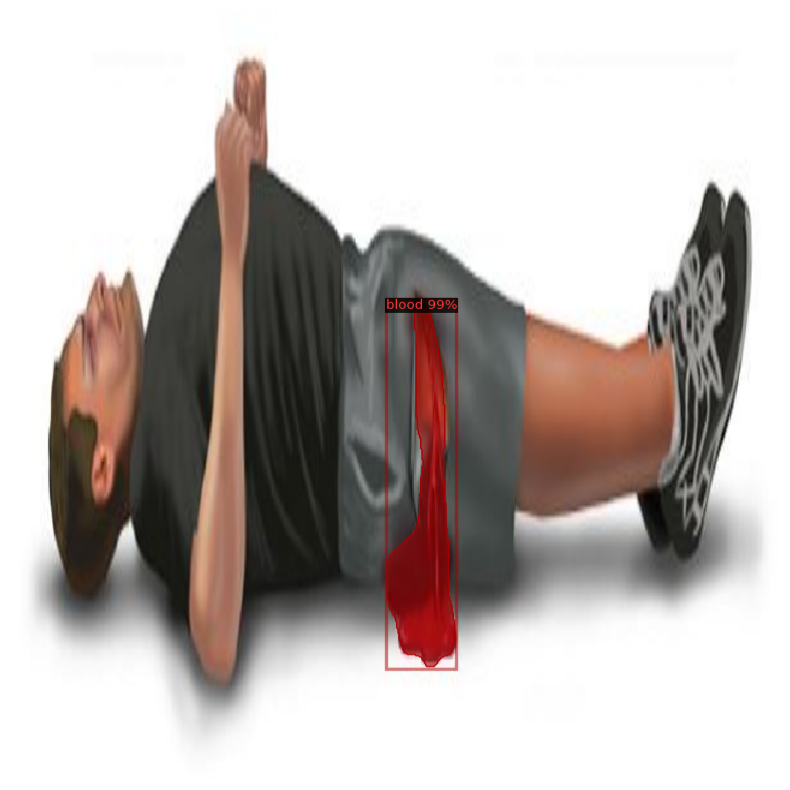

Instance 1 has 8984 pixels.
Total pixels in the image: 409600


In [27]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt
import numpy as np

# ✅ Load trained model
cfg.MODEL.WEIGHTS = final2_model_path  # Use the saved model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # Set confidence threshold
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

predictor = DefaultPredictor(cfg)

# ✅ Load test image
image_path = "/kaggle/input/blmodeltest/bltest3.jfif"  # Change to your test image path
image = cv2.imread(image_path)
image=cv2.resize(image,(640,640))
# ✅ Make prediction
outputs = predictor(image)
pred_masks = outputs["instances"].pred_masks.cpu().numpy()
print("Predictions:", outputs)  # Print output for debugging

# ✅ Visualize results with only masks (no bounding boxes)
v = Visualizer(image[:, :, ::-1], 
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
               scale=1.2)

# Draw instance predictions without bounding boxes
# This should draw only the masks without the bounding boxes
v_output = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()

# ✅ Show image with only masks (no bounding boxes)
plt.figure(figsize=(10, 10))
plt.imshow(v_output)
plt.axis("off")
plt.show()
for idx, mask in enumerate(pred_masks):
    # Count number of non-zero pixels (i.e., part of the object)
    mask_area = np.sum(mask)  # This will count the number of 1s in the mask (the object area)
    print(f"Instance {idx+1} has {mask_area} pixels.")
height, width, _ = image.shape
total_pixels = height * width
print(f"Total pixels in the image: {total_pixels}")

## Simple archi